Last Revised: 07/22/2025

Point of Contact: Abigayle Hodson, Scientific Engineering Associate, Abigayle_Hodson@lbl.gov

Principle Investigator: Dr. Jennifer Stokes-Draut, Energy/Environmental Policy Research Scientist/Engineer

Organization: Lawrence Berkeley National Lab, Energy Analysis and Environmental Impacts Division

Purpose: The purpose of this notebook is to assess the accuracy of different methods for estimating wastewater treatment plant energy consumption and recovery. Methods for estimating electricity consumption, energy consumption, and electricity generation from biogas utilization are applied herein to an inventory of U.S. wastewater treatment plants derived from the U.S. EPA's Clean Watersheds Needs Survey (CWNS). Using reported energy consumption/recovery values for select U.S. cities published in the 2018 study "[The State of U.S. Urban Water: Data and the Energy-Water Nexus,](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1002/2017WR022265)" the error associated with each of the estimation methods is calculated and visualized using kernel density estimation (KDE) plots. Error is also evaluated based on facility characteristics such as size, effluent treatment level (ETL), and latitude.

Data Sources:
*   Clean Watersheds Needs Survey (CWNS) (U.S. EPA, [2004](https://www.epa.gov/cwns/clean-watersheds-needs-survey-cwns-2004-report-and-data), [2008](https://ordspub.epa.gov/ords/cwns2008/f?p=cwns2008:25:), [2012](https://ordspub.epa.gov/ords/cwns2012/f?p=cwns2012:25:), and [2022](https://sdwis.epa.gov/ords/sfdw_pub/r/sfdw/cwns_pub/data-download?session=9748529459785))
*   Department of Energy Combined Heat and Power Database
([U.S. DOE, 2024](https://doe.icfwebservices.com/downloads/chp))
*   U.S. Energy Information Administration Survey Form EIA-923, 2012
([U.S. EIA, 2012](https://www.eia.gov/electricity/data/eia923/))
*   Water Environment Federation Biogas Database ([WEF, 2024](https://app.powerbi.com/view?r=eyJrIjoiMGFjZDFjZmItMjQ5Yi00ZTlhLWJmNTQtODFiNjlkYjFlODJjIiwidCI6ImI3ZTk3ODAyLTJhNjktNDc3ZS1iN2QyLWY0ZDE2MWMyMTBjYiIsImMiOjF9))
*   Electric Power Research Institute (EPRI) Electricity Intensity Based on Flow Rate, ETL, and Key Unit Processes ([Pabi et. al, 2013](https://www.sciencetheearth.com/uploads/2/4/6/5/24658156/electricity_use_and_management_in_the_municipal_water_supply_and_wastewater_industries.pdf))
*   Electricity Intensity Based on ETL ([Li et al. 2025](https://pubs.acs.org/doi/10.1021/acs.estlett.4c00893))
*   Electricity/Energy Intensity Based on Treatment Configuration, Original ([Tarallo et. al, 2015](https://iwaponline.com/ebooks/book/293/A-Guide-to-Net-Zero-Energy-Solutions-for-Water))
*   Electricity/Energy Intensity Based on Treatment Configuration, Updated ( [El Abbadi et al., 2025](https://eartharxiv.org/repository/view/7980/))
*   Electricity Intensity Based on Key Unit Processes ([Plappally and Leinhard, 2012](https://www.sciencedirect.com/science/article/pii/S1364032112003541))
*   Electricity Generation Intensity Based on Prime Mover ([EPA 2011](https://www.epa.gov/sites/default/files/2015-07/documents/opportunities_for_combined_heat_and_power_at_wastewater_treatment_facilities_market_analysis_and_lessons_from_the_field.pdf))
*   Regression Model of Energy Use ([Carlson and Walburger 2007](https://www.nyserda.ny.gov/-/media/Project/Nyserda/Files/EERP/Commercial/Sector/Municipal-Water-Wastewater-Facilities/benchmarking-water-wastewater-utilities.pdf))








# Set up notebook

In [ ]:
#import necessary libraries and packages
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import math as math
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import matplotlib.font_manager as fm

#display all columns in dataframe
pd.set_option('display.max_columns', None)

#establish file path for ease of imports and exports
path = './'

Mounted at /content/gdrive/


# Create 2012 and 2042 inventories of U.S. wastewater treatment plants

In [ ]:
def create_wwtp_inventory(scenario):
  '''
  Function that creates an inventory of active wwtps in the United States for a given year using CWNS data
    Parameters:
      scenario = year (2012 or 2042)
    Returns:
      wwtps_all = dataframe containing the active wwtps and relevant characteristics (ie. location, flow rate, ETL, etc.) for given scenario
  '''
  if scenario == 2012:
    #upload facility flow rates from the 2012 CWNS
    flow = pd.read_excel(path + 'input_data/facility_information/cwns/2012/SUMMARY_FLOW.xlsx', sheet_name = 'SUMMARY_FLOW', dtype = {'CWNS_NUMBER':str})

    #filter to facilities that reported non-zero, non-nan flow in 2012
    flow = flow.loc[(flow['EXIST_TOTAL'] != 0) & (~pd.isna(flow['EXIST_TOTAL']))]
    flow.reset_index(inplace = True, drop = True)

    #create dataframe of active wwtps based on facilities that reported flow in 2012
    wwtps_all = flow[['CWNS_NUMBER', 'EXIST_TOTAL']].rename(columns = {'EXIST_TOTAL':'2012_FLOW_MGD'})

    #upload facility ETLs
    etl = pd.read_excel(path + 'input_data/facility_information/cwns/2012/SUMMARY_EFFLUENT.xlsx', sheet_name = 'SUMMARY_EFFLUENT', dtype = {'CWNS_NUMBER':str})[['CWNS_NUMBER','PRES_EFFLUENT_TREATMENT_LEVEL']]

    #merge ETL information with main dataframe and rename columns
    wwtps_all = wwtps_all.merge(etl, on = 'CWNS_NUMBER', how = 'left')
    wwtps_all.rename(columns = {'CWNS_NUMBER':'CWNS_NUM','PRES_EFFLUENT_TREATMENT_LEVEL':'2012_EFFLUENT_TREATMENT_LEVEL'}, inplace = True)

    #upload facility locations from 2012 CWNS
    location = pd.read_excel(path + 'input_data/facility_information/cwns/2012/SUMMARY_FACILITY.xlsx', dtype = {'CWNS_NUMBER':str})

    #merge location information with main dataframe
    wwtps_all = wwtps_all.merge(location[['CWNS_NUMBER','LATITUDE','LONGITUDE','STATE']].rename(columns = {'CWNS_NUMBER':'CWNS_NUM'}), how = 'left', on = 'CWNS_NUM')

    #convert latitude and longitude coordinates to from str to float
    wwtps_all['LATITUDE'] = wwtps_all['LATITUDE'].fillna('Unknown')
    wwtps_all['LATITUDE'] = [lat.replace(' N','') for lat in wwtps_all['LATITUDE']]
    wwtps_all['LATITUDE'] = [lat.replace(' S','') for lat in wwtps_all['LATITUDE']]
    wwtps_all['LATITUDE'] = [float(lat) if lat != 'Unknown' else lat for lat in wwtps_all['LATITUDE']]
    wwtps_all['LONGITUDE'] = wwtps_all['LONGITUDE'].fillna('Unknown')
    wwtps_all['LONGITUDE'] = [lon.replace(' W','') for lon in wwtps_all['LONGITUDE']]
    wwtps_all['LONGITUDE'] = [lon.replace(' E','') for lon in wwtps_all['LONGITUDE']]
    wwtps_all['LONGITUDE'] = [-float(lon) if lon != 'Unknown' else lon for lon in wwtps_all['LONGITUDE']]

    #correct Wichita, KS coordinates; needed for figures
    wwtps_all.loc[wwtps_all['CWNS_NUM'] == '20000193001', 'LATITUDE'] = 37.588139
    wwtps_all.loc[wwtps_all['CWNS_NUM'] == '20000193001', 'LONGITUDE'] = -97.309484

    #filter out facilities in U.S. territories and reset index
    wwtps_all = wwtps_all.loc[~wwtps_all['STATE'].isin(['AS','GU','MP','PR','VI'])]
    wwtps_all.reset_index(inplace = True, drop = True)

    #categorize average daily flow rate in 2012
    wwtps_all.loc[wwtps_all['2012_FLOW_MGD'] < 2, '2012_FLOW_CAT_MGD'] = 'LESS THAN 2'
    wwtps_all.loc[(wwtps_all['2012_FLOW_MGD'] >= 2) & (wwtps_all['2012_FLOW_MGD'] < 4), '2012_FLOW_CAT_MGD'] = '2 TO 4'
    wwtps_all.loc[(wwtps_all['2012_FLOW_MGD'] >= 4) & (wwtps_all['2012_FLOW_MGD'] < 7), '2012_FLOW_CAT_MGD'] = '4 TO 7'
    wwtps_all.loc[(wwtps_all['2012_FLOW_MGD'] >= 7) & (wwtps_all['2012_FLOW_MGD'] < 16), '2012_FLOW_CAT_MGD'] = '7 TO 16'
    wwtps_all.loc[(wwtps_all['2012_FLOW_MGD'] >= 16) & (wwtps_all['2012_FLOW_MGD'] < 46), '2012_FLOW_CAT_MGD'] = '16 TO 46'
    wwtps_all.loc[(wwtps_all['2012_FLOW_MGD'] >= 46) & (wwtps_all['2012_FLOW_MGD'] < 100), '2012_FLOW_CAT_MGD'] = '46 TO 100'
    wwtps_all.loc[(wwtps_all['2012_FLOW_MGD'] >= 100), '2012_FLOW_CAT_MGD'] = '100 AND ABOVE'

    #convert daily flow rate to annual volume of water processed (million m3)
    wwtps_all['2012_FLOW_MM3'] = wwtps_all['2012_FLOW_MGD'] * 365 / 264.172

    #upload facility type data from 2012 CWNS
    types = pd.read_excel(path + 'input_data/facility_information/cwns/2012/SUMMARY_FACILITY_TYPE.xlsx', sheet_name = 'SUMMARY_FACILITY_TYPE', dtype = {'CWNS_NUMBER':str})

    #filter to just treatment plants and lagoons
    types = types.loc[(types['FACILITY_TYPE'] == 'Treatment Plant') | (types['FACILITY_TYPE'] == 'Treatment Lagoon or Pond')].drop_duplicates(subset = 'CWNS_NUMBER').rename(columns = {'CWNS_NUMBER':'CWNS_NUM'})

    #merge facility type information with main dataframe to screen out non-treatment plants/lagoons
    wwtps_all = wwtps_all.merge(types[['CWNS_NUM','FACILITY_TYPE']], on = 'CWNS_NUM', how = 'inner')

    #check for facilities with duplicate entries
    assert wwtps_all['CWNS_NUM'].value_counts().max() == 1

  elif scenario == 2042:
    #upload projected facility flow rates from the 2022 CWNS and filter to total flow
    flow = pd.read_csv(path + 'input_data/facility_information/cwns/2022/FLOW.csv', dtype = {'CWNS_ID':str})
    flow = flow.loc[flow['FLOW_TYPE'] == 'Total Flow']

    #filter to facilities that project non-zero, non-nan flow in 2042
    flow = flow.loc[(flow['FUTURE_DESIGN_FLOW'] != 0) & (~pd.isna(flow['FUTURE_DESIGN_FLOW']))]
    flow.reset_index(inplace = True, drop = True)

    #create dataframe of active wwtps based on facilities that project flow in 2042
    wwtps_all = flow[['CWNS_ID', 'FUTURE_DESIGN_FLOW']].rename(columns = {'FUTURE_DESIGN_FLOW':'2042_FLOW_MGD'})

    #upload projected ETL from 2022 CWNS
    etl = pd.read_csv(path + 'input_data/facility_information/cwns/2022/EFFLUENT.csv', dtype = {'CWNS_ID':str})[['CWNS_ID','FUTURE_EFFLUENT_TREATMENT_LEVEL']]

    #merge ETL information with main dataframe and rename columns
    wwtps_all = wwtps_all.merge(etl, on = 'CWNS_ID', how = 'left')
    wwtps_all.rename(columns = {'CWNS_ID':'CWNS_NUM','FUTURE_EFFLUENT_TREATMENT_LEVEL':'2042_EFFLUENT_TREATMENT_LEVEL'}, inplace = True)

    #upload facility locations from 2022 CWNS
    location = pd.read_csv(path + 'input_data/facility_information/cwns/2022/PHYSICAL_LOCATION.csv', dtype = {'CWNS_ID':str, 'LATITUDE':str, 'LONGITUDE':str})

    #merge location information with main dataframe
    wwtps_all = wwtps_all.merge(location[['CWNS_ID','STATE_CODE','LONGITUDE','LATITUDE']].rename(columns = {'CWNS_ID':'CWNS_NUM', 'STATE_CODE':'STATE'}), how = 'left', on = 'CWNS_NUM')

    #convert latitude and longitude coordinates from str to float
    wwtps_all['LATITUDE'] = wwtps_all['LATITUDE'].fillna('Unknown')
    wwtps_all['LATITUDE'] = [lat.replace(' N','') for lat in wwtps_all['LATITUDE']]
    wwtps_all['LATITUDE'] = [lat.replace(' S','') for lat in wwtps_all['LATITUDE']]
    wwtps_all['LATITUDE'] = [float(lat) if lat != 'Unknown' else lat for lat in wwtps_all['LATITUDE']]
    wwtps_all['LONGITUDE'] = wwtps_all['LONGITUDE'].fillna('Unknown')
    wwtps_all['LONGITUDE'] = [lon.replace(' W','') for lon in wwtps_all['LONGITUDE']]
    wwtps_all['LONGITUDE'] = [lon.replace(' E','') for lon in wwtps_all['LONGITUDE']]
    wwtps_all['LONGITUDE'] = [-float(lon) if lon != 'Unknown' else lon for lon in wwtps_all['LONGITUDE']]

    #filter out facilities in U.S. territories and reset index
    wwtps_all = wwtps_all.loc[~wwtps_all['STATE'].isin(['AS','GU','MP','PR','VI'])]
    wwtps_all.reset_index(inplace = True, drop = True)

    #categorize average daily flow rate in 2042
    wwtps_all.loc[wwtps_all['2042_FLOW_MGD'] < 2, '2042_FLOW_CAT_MGD'] = 'LESS THAN 2'
    wwtps_all.loc[(wwtps_all['2042_FLOW_MGD'] >= 2) & (wwtps_all['2042_FLOW_MGD'] < 4), '2042_FLOW_CAT_MGD'] = '2 TO 4'
    wwtps_all.loc[(wwtps_all['2042_FLOW_MGD'] >= 4) & (wwtps_all['2042_FLOW_MGD'] < 7), '2042_FLOW_CAT_MGD'] = '4 TO 7'
    wwtps_all.loc[(wwtps_all['2042_FLOW_MGD'] >= 7) & (wwtps_all['2042_FLOW_MGD'] < 16), '2042_FLOW_CAT_MGD'] = '7 TO 16'
    wwtps_all.loc[(wwtps_all['2042_FLOW_MGD'] >= 16) & (wwtps_all['2042_FLOW_MGD'] < 46), '2042_FLOW_CAT_MGD'] = '16 TO 46'
    wwtps_all.loc[(wwtps_all['2042_FLOW_MGD'] >= 46) & (wwtps_all['2042_FLOW_MGD'] < 100), '2042_FLOW_CAT_MGD'] = '46 TO 100'
    wwtps_all.loc[(wwtps_all['2042_FLOW_MGD'] >= 100), '2042_FLOW_CAT_MGD'] = '100 AND ABOVE'

    #convert daily flow rate to annual volume of water processed (million m3)
    wwtps_all['2042_FLOW_MM3'] = wwtps_all['2042_FLOW_MGD'] * 365 / 264.172

    #upload facility type data from 2022 CWNS
    types = pd.read_csv(path + 'input_data/facility_information/cwns/2022/FACILITY_TYPES.csv', dtype = {'CWNS_ID':str})

    #filter to just treatment plants and lagoons
    types = types.loc[(types['FACILITY_TYPE'] == 'Treatment Plant') | (types['FACILITY_TYPE'] == 'Honey Bucket Lagoon')].drop_duplicates(subset = 'CWNS_ID').rename(columns = {'CWNS_ID':'CWNS_NUM'})

    #merge facility type information with main dataframe to screen out non-treatment plants/lagoons
    wwtps_all = wwtps_all.merge(types[['CWNS_NUM','FACILITY_TYPE']], on = 'CWNS_NUM', how = 'inner')

    #check for facilities with duplicate entries
    assert wwtps_all['CWNS_NUM'].value_counts().max() == 1

  else:
    print('Please select a relevant scenario year (2012 or 2042)')

  return wwtps_all

In [ ]:
def add_biogas_info(wwtps_all, scenario):
  '''
  Function that identifies wwtps that utilize biogas for electricity production for a given scenario year based on the 2022 CWNS and external databases from DOE, WEF, and EIA
    Parameters:
    wwtps_all = dataframe containing the active wwtps and relevant characteristics (ie. location, flow rate, ETL, etc.) for given scenario
      scenario = year (2012 or 2042)
    Returns:
      wwtps_biogas = dataframe containing the active wwtps and relevant characteristics, including whether digester biogas is used to produce electricity, for given scenario
  '''
  #upload facilities identified as producing electricity in DOE's Combined Heat and Power Installation database, pre-filtered to wastewater treatment plants and manually assigned a CWNS number based on facility name and location
  doe_biogas = pd.read_csv(path + 'input_data/facility_information/biogas/biogas_wwtps_doe.csv', dtype = {'CWNS_NUM':str})

  #drop facilities without an identified CWNS number
  doe_biogas = doe_biogas.dropna(subset = ['CWNS_NUM'])

  #add a leading zero to facilities with improperly recorded CWNS number
  doe_biogas['CWNS_NUM'] = ['0' + str(cwns) if len(str(cwns)) < 11 else str(cwns) for cwns in doe_biogas['CWNS_NUM']]

  #filter to relevant columns
  doe_biogas = doe_biogas[['CWNS_NUM','Prime Mover','BIOGAS_DOE_2012','BIOGAS_DOE_PROJ']]

  #for the purpose of electricity production calculations, assume combustion and steam turbines have same production rate as microturbines
  doe_biogas.loc[(doe_biogas['Prime Mover'] == 'Combustion Turbine') | (doe_biogas['Prime Mover'] == 'Boiler/Steam Turbine'), 'Prime Mover'] = 'Microturbine'

  #upload facilities identified as producing electricity in WEF's Biogas Database, obtained prior to website update which removed option to download data
  wef_biogas = pd.read_csv(path + 'input_data/facility_information/biogas/biogas_wwtps_wef.csv', dtype = {'CWNS_NUM':str})

  #drop facilities without an identified CWNS number
  wef_biogas = wef_biogas.dropna(subset = 'CWNS_NUM')

  #add a leading zero to facilities with improperly recorded CWNS number
  wef_biogas['CWNS_NUM'] = ['0' + str(cwns) if len(str(cwns)) < 11 else str(cwns) for cwns in wef_biogas['CWNS_NUM']]

  #add a column to indicate if electricity is produced from biogas
  wef_biogas.replace('yes', 1, inplace = True)
  wef_biogas.replace('no', 0, inplace = True)
  wef_biogas.replace('unknown', 0, inplace = True)
  wef_biogas['Electricity Produced?'] = wef_biogas['Electricity_from_combustion-engine'] + wef_biogas['Electricity_from_microturbine'] + wef_biogas['Electricity_from_turbine'] + wef_biogas['Electricity_from_fuelcell'] + wef_biogas['Electricity_supplied_to_grid']
  wef_biogas.loc[wef_biogas['Electricity Produced?'] > 0, 'BIOGAS_WEF_2012'] = 1
  wef_biogas.loc[wef_biogas['Electricity Produced?'] > 0, 'BIOGAS_WEF_PROJ'] = 1

  #filter to facilities that use biogas for electricity production
  wef_biogas = wef_biogas.loc[wef_biogas['Electricity Produced?'] > 0]

  #add column for prime mover and populate based on electricity source columns
  wef_biogas.loc[wef_biogas['Electricity_from_combustion-engine'] == 1, 'Prime Mover'] = 'Reciprocating Engine'
  wef_biogas.loc[wef_biogas['Electricity_from_turbine'] == 1, 'Prime Mover'] = 'Microturbine'
  wef_biogas.loc[wef_biogas['Electricity_from_microturbine'] == 1, 'Prime Mover'] = 'Microturbine'
  wef_biogas.loc[wef_biogas['Electricity_from_fuelcell'] == 1, 'Prime Mover'] = 'Fuel Cell'

  #filter to relevant columns
  wef_biogas = wef_biogas[['CWNS_NUM','Prime Mover','BIOGAS_WEF_2012','BIOGAS_WEF_PROJ']]

  #upload facilities that project using energy recovery from the 2022 CWNS- previous versions of the CWNS do not have specific enough naming conventions to determine whether biogas is used for electricity production or to offset heating needs
  cwns_biogas = pd.read_csv(path + 'input_data/facility_information/cwns/2022/UNIT_PROCESSES.csv', dtype = {'CWNS_NUM':str})

  #rename columns
  cwns_biogas.rename(columns = {'CWNS_ID':'CWNS_NUM'}, inplace = True)

  #add a leading zero to facilities with improperly recorded CWNS number
  cwns_biogas['CWNS_NUM'] = ['0' + str(cwns) if len(str(cwns)) < 11 else str(cwns) for cwns in cwns_biogas['CWNS_NUM']]

  #filter to facilities that project using biogas for electricity production
  cwns_biogas = cwns_biogas.loc[(cwns_biogas['UNIT_PROCESS'] == 'Biosolids Anaerobic Digestion with Energy Recovery') & ((cwns_biogas['EXISTING_FLAG'] == 'Y') | (cwns_biogas['PLANNED_FLAG'] == 'Y'))]
  cwns_biogas['BIOGAS_CWNS_PROJ'] = 1
  cwns_biogas['Prime Mover'] = 'Unknown'
  cwns_biogas = cwns_biogas[['CWNS_NUM','Prime Mover','BIOGAS_CWNS_PROJ']]

  #combine DOE, WEF, and CWNS biogas dataframes
  biogas_all = pd.concat([cwns_biogas, doe_biogas, wef_biogas])

  #create columns that indicate if facility was flagged as producing electricity across all databases
  biogas_all.fillna(0, inplace = True)
  biogas_all.loc[biogas_all['BIOGAS_DOE_2012'] + biogas_all['BIOGAS_WEF_2012'] > 0, 'BIOGAS_2012'] = 1
  biogas_all.loc[biogas_all['BIOGAS_CWNS_PROJ'] + biogas_all['BIOGAS_DOE_PROJ'] + biogas_all['BIOGAS_WEF_PROJ'] > 0, 'BIOGAS_2042'] = 1

  #filter to relevant columns and drop duplicates
  biogas_all = biogas_all[['CWNS_NUM','Prime Mover','BIOGAS_2012','BIOGAS_2042']]
  biogas_all.drop_duplicates(subset = 'CWNS_NUM', inplace = True)
  biogas_all.reset_index(inplace = True, drop = True)

  #assume unknown prime movers are reciprocating engines, the most common type of prime mover for this application
  biogas_all.loc[biogas_all['Prime Mover'] == 'Unknown', 'Prime Mover'] = 'Reciprocating Engine'

  #add biogas facilties from EIA 2012 survey not included in other data sources
  biogas_all.loc[biogas_all['CWNS_NUM'] == '25000128001', 'Prime Mover'] = 'Microturbine' #Boston
  biogas_all.loc[biogas_all['CWNS_NUM'] == '25000128001', 'BIOGAS_2012'] = 1 #Boston
  biogas_all.loc[biogas_all['CWNS_NUM'] == '19000226001', 'Prime Mover'] = 'Reciprocating Engine' #Des Moines
  biogas_all.loc[biogas_all['CWNS_NUM'] == '19000226001', 'BIOGAS_2012'] = 1 #Des Moines
  biogas_all.loc[biogas_all['CWNS_NUM'] == '12000017004', 'Prime Mover'] = 'Reciprocating Engine' #Miami-Dade
  biogas_all.loc[biogas_all['CWNS_NUM'] == '12000017004', 'BIOGAS_2012'] = 1 #Miami-Dade
  biogas_all.loc[biogas_all['CWNS_NUM'] == '12000017028', 'Prime Mover'] = 'Reciprocating Engine' #Miami-Dade
  biogas_all.loc[biogas_all['CWNS_NUM'] == '12000017028', 'BIOGAS_2012'] = 1 #Miami-Dade

  #retain only biogas flag for selected scenario
  if scenario == 2012:
    biogas_all.drop(columns = 'BIOGAS_2042', inplace = True)
  elif scenario == 2042:
    biogas_all.drop(columns = 'BIOGAS_2012', inplace = True)

  #merge biogas flag with main wwtps_all dataframe
  wwtps_biogas = wwtps_all.merge(biogas_all, on = 'CWNS_NUM', how = 'left')

  return wwtps_biogas

In [ ]:
#create dataframe of active wwtps in 2012
wwtps_2012 = create_wwtp_inventory(2012)

#create dataframe of wwtps projected to be active in 2042
wwtps_proj = create_wwtp_inventory(2042)

# Estimate energy use and recovery of U.S. wastewater treatment plants in 2012 and 2042

In [ ]:
#create dataframes to hold the national energy consumption and recovery totals for each method and scenario (2012 vs 2042)
national_tot_2012 = pd.DataFrame(columns = ['Method', 'National Electricity Consumption (TWh/year)', 'National Energy Consumption (TJ/year)','National Electricity Generation (TWh/year)'])
national_tot_proj = pd.DataFrame(columns = ['Method', 'National Electricity Consumption (TWh/year)', 'National Energy Consumption (TJ/year)','National Electricity Generation (TWh/year)'])

## Flow Rate Method

Estimate electricity consumption for U.S. wastewater treatment plants using intensity values from EPRI categorized by average daily flow rate. Electricity consumption intensity is assigned for seven scales (in MGD): <2, 2-4, 4-7, 7-16, 16-46, 46-100, and >100. This method captures the economies of scale observed in wastewater treatment.

In [ ]:
#import electricity intensity values based on flow rate from EPRI
ei_taf = pd.read_excel(path + 'input_data/flow_method/epri_flow_ei.xlsx', sheet_name = 'EPRI_FLOW_EI')

#merge electricity intensity and total annual flow columns
taf_2012 = wwtps_2012.merge(ei_taf, how = 'left', left_on = '2012_FLOW_CAT_MGD', right_on = 'Average Daily Flow (MGD)')[['CWNS_NUM','2012_FLOW_MM3','Electricity Intensity (kWh/m3)']]
taf_2042 = wwtps_proj.merge(ei_taf, how = 'left', left_on = '2042_FLOW_CAT_MGD', right_on = 'Average Daily Flow (MGD)')[['CWNS_NUM','2042_FLOW_MM3','Electricity Intensity (kWh/m3)']]

#calculate total annual electricity use (MWh) for each wwtp
taf_2012['2012_FLOW_MWH'] = taf_2012['2012_FLOW_MM3'] * 10**6 * taf_2012['Electricity Intensity (kWh/m3)'] * 0.001
taf_2042['2042_FLOW_MWH'] = taf_2042['2042_FLOW_MM3'] * 10**6 * taf_2042['Electricity Intensity (kWh/m3)'] * 0.001

#print total national electricity use (TWh)
print('National Electricity Use (TWh/year) (2012): ' + str(taf_2012['2012_FLOW_MWH'].sum() / 10**6))
print('National Electricity Use (TWh/year) (2042): ' + str(taf_2042['2042_FLOW_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Flow', 'National Electricity Consumption (TWh/year)':taf_2012['2012_FLOW_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Flow', 'National Electricity Consumption (TWh/year)':taf_2042['2042_FLOW_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}

#check that all wwtps were assigned an electricity consumption
assert taf_2012.loc[pd.isna(taf_2012['2012_FLOW_MWH'])].shape[0] == 0
assert taf_2042.loc[pd.isna(taf_2042['2042_FLOW_MWH'])].shape[0] == 0

National Electricity Use (TWh/year) (2012): 24.39732967668791
National Electricity Use (TWh/year) (2042): 39.646329636941076


## Effluent Treatment Level (A) Method

Estimate electricity consumption for U.S. wastewater treatment plants using intensity values from EPRI categorized by ETL. Electricity consumption intensity is assigned for five effluent treatment levels: raw discharge, primary treatment, advanced primary, secondary treatment, and advanced treatment.

In [ ]:
#import electricity intensity values based on ETL from EPRI
ei_etl_a = pd.read_excel(path + 'input_data/effluent_methods/epri_effluent_a_ei.xlsx')

#change CWNS naming convention of projected ETL to match that of EPRI
wwtps_proj.loc[wwtps_proj['2042_EFFLUENT_TREATMENT_LEVEL'] == 'Advanced', '2042_EFFLUENT_TREATMENT_LEVEL'] = 'Advanced Treatment'
wwtps_proj.loc[wwtps_proj['2042_EFFLUENT_TREATMENT_LEVEL'] == 'Primary', '2042_EFFLUENT_TREATMENT_LEVEL'] = 'Primary (45mg/l< BOD)'
wwtps_proj.loc[wwtps_proj['2042_EFFLUENT_TREATMENT_LEVEL'] == 'Raw', '2042_EFFLUENT_TREATMENT_LEVEL'] = 'Raw Discharge'

#assume wwtps without a recorded ETL have secondary treatment, at a minimum
wwtps_2012.loc[pd.isna(wwtps_2012['2012_EFFLUENT_TREATMENT_LEVEL']), '2012_EFFLUENT_TREATMENT_LEVEL'] = 'Secondary'
wwtps_proj.loc[pd.isna(wwtps_proj['2042_EFFLUENT_TREATMENT_LEVEL']), '2042_EFFLUENT_TREATMENT_LEVEL'] = 'Secondary'

#merge electricity intensity and total annual flow columns
etl_a_2012 = wwtps_2012.merge(ei_etl_a, how = 'left', left_on = '2012_EFFLUENT_TREATMENT_LEVEL', right_on = 'Effluent Treatment Level')[['CWNS_NUM','2012_FLOW_MM3','Electricity Intensity (kWh/m3)']]
etl_a_2042 = wwtps_proj.merge(ei_etl_a, how = 'left', left_on = '2042_EFFLUENT_TREATMENT_LEVEL', right_on = 'Effluent Treatment Level')[['CWNS_NUM','2042_FLOW_MM3','Electricity Intensity (kWh/m3)']]

#calculate total annual electricity use (MWh) for each wwtp
etl_a_2012['2012_EFFLUENT_A_MWH'] = etl_a_2012['2012_FLOW_MM3'] * 10**6 * etl_a_2012['Electricity Intensity (kWh/m3)'] * 0.001
etl_a_2042['2042_EFFLUENT_A_MWH'] = etl_a_2042['2042_FLOW_MM3'] * 10**6 * etl_a_2042['Electricity Intensity (kWh/m3)'] * 0.001

#print total national electricity consumption (TWh)
print('National Electricity Use (TWh/year) (2012): ' + str(etl_a_2012['2012_EFFLUENT_A_MWH'].sum() / 10**6))
print('National Electricity Use (TWh/year) (2042): ' + str(etl_a_2042['2042_EFFLUENT_A_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Effluent A', 'National Electricity Consumption (TWh/year)':etl_a_2012['2012_EFFLUENT_A_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Effluent A', 'National Electricity Consumption (TWh/year)':etl_a_2042['2042_EFFLUENT_A_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}

#check that all wwtps were assigned an electricity consumption
assert etl_a_2012.loc[pd.isna(etl_a_2012['2012_EFFLUENT_A_MWH'])].shape[0] == 0
assert etl_a_2042.loc[pd.isna(etl_a_2042['2042_EFFLUENT_A_MWH'])].shape[0] == 0

National Electricity Use (TWh/year) (2012): 29.003865855458262
National Electricity Use (TWh/year) (2042): 49.93320886656188


## Effluent Treatment Level (B) Method

Estimate electricity consumption for U.S. wastewater treatment plants using electricity consumption intensity values from Li et al., 2025 categorized by ETL. Electricity consumption intensity is assigned for five effluent treatment levels: raw discharge, primary treatment, advanced primary, secondary treatment, and advanced treatment.

In [ ]:
#import electricity consumption intensity values based on ETL from Li et al., 2025
ei_etl_b = pd.read_excel(path + 'input_data/effluent_methods/li_effluent_b_ei.xlsx')

#merge electricity intensity and total annual flow columns
etl_b_2012 = wwtps_2012.merge(ei_etl_b, how = 'left', left_on = '2012_EFFLUENT_TREATMENT_LEVEL', right_on = 'Effluent Treatment Level')[['CWNS_NUM','2012_FLOW_MM3','Electricity Intensity (kWh/m3)']]
etl_b_2042 = wwtps_proj.merge(ei_etl_b, how = 'left', left_on = '2042_EFFLUENT_TREATMENT_LEVEL', right_on = 'Effluent Treatment Level')[['CWNS_NUM','2042_FLOW_MM3','Electricity Intensity (kWh/m3)']]

#calculate total annual electricity use (MWh) for each wwtp
etl_b_2012['2012_EFFLUENT_B_MWH'] = etl_b_2012['2012_FLOW_MM3'] * 10**6 * etl_b_2012['Electricity Intensity (kWh/m3)'] * 0.001
etl_b_2042['2042_EFFLUENT_B_MWH'] = etl_b_2042['2042_FLOW_MM3'] * 10**6 * etl_b_2042['Electricity Intensity (kWh/m3)'] * 0.001

#print total national electricity consumption (TWh)
print('National Electricity Use (TWh/year) (2012): ' + str(etl_b_2012['2012_EFFLUENT_B_MWH'].sum() / 10**6))
print('National Electricity Use (TWh/year) (2042): ' + str(etl_b_2042['2042_EFFLUENT_B_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Effluent B', 'National Electricity Consumption (TWh/year)':etl_b_2012['2012_EFFLUENT_B_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Effluent B', 'National Electricity Consumption (TWh/year)':etl_b_2042['2042_EFFLUENT_B_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}

#check that all wwtps were assigned an electricity consumption
assert etl_b_2012.loc[pd.isna(etl_b_2012['2012_EFFLUENT_B_MWH'])].shape[0] == 0
assert etl_b_2042.loc[pd.isna(etl_b_2042['2042_EFFLUENT_B_MWH'])].shape[0] == 0

National Electricity Use (TWh/year) (2012): 19.452399650935
National Electricity Use (TWh/year) (2042): 33.63572405141


## Treatment Train Configuration (T) Methods

Based on unit processes reported in CWNS and external biogas databases, each WWTP was assigned one or more treatment trains, as defined by (Tarallo et al., 2015), in a separate script (tt_assignment.ipynb). The intensities for electricity consumption, total energy consumption (which includes natural gas use), and, when relevant, electricity production from biogas, for each WWTP were assigned based on the most closely represented treatment train(s), assuming typical configurations. When multiple treatment trains were equally well-matched, the intensities for all identified treatment trains were averaged. Note that (El Abbadi et al., 2025) expanded this method to include a wider range of possible treatment configurations and, in the absence of sufficient unit process data, assign treatment trains based on common configurations in different regions of the United States.

In [ ]:
#iterate through treatment train configuration methods (Tarallo et al. 2015 = original, El Abbadi et al. 2025 = expanded)
for method in ['Tarallo et al., 2015','El Abbadi et al., 2025']:
  #upload energy consumption/recovery intensity table for treatment trains assuming typical configurations
  ei_tt = pd.read_excel(path + f'input_data/configuration_methods/configuration_t_ei.xlsx', sheet_name = 'All Trains (For Code)')
  ei_tt.rename(columns = {'Unnamed: 0':'Energy Intensity'}, inplace = True)

  #identify which treatment trains are assigned in selected method
  if method == 'Tarallo et al., 2015':
    tt_list = ['O1','N1','N2','I3','I2','H1','G1','G1E','F1','E2','E2P', 'D1','C3','B6','B5','B4','B1E','B1']
  elif method == 'El Abbadi et al., 2025':
    tt_list = ['LAGOON_OTHER','LAGOON_AER','LAGOON_ANAER','LAGOON_FAC','STBL_POND','I1E','G6','I6','O5','O6','O3','O1E','G5','I5','C5','C6','O2','O1','N1','N1E','N2','I3','I2','I1','H1','H1E','G3','G2','G1','G1E','F1','F1E','E2','E2P','D5','D6','D1','D1E','D3','D2','C3','C2','C1','C1E','B6','B5','B4','B3','B1E','B1','B2']
  else:
    print('Please select a relevant method')

  ei_tt_method = ei_tt[['Energy Intensity'] + tt_list]

  #filter to intensities that exclude energy from production of chemicals
  ei_tt_method = ei_tt_method.iloc[[1,4,9]]

  #convert intensities from (kWh/d) to (kWh/m3) and change row names accordingly
  ei_tt_method[tt_list] = ei_tt_method[tt_list] / 10 * 264.172 / 10**6
  ei_tt_method.at[1, 'Energy Intensity'] = 'Electricity Consumption (kWh/m3)'
  ei_tt_method.at[4, 'Energy Intensity'] = 'Electricity Production (kWh/m3)'
  ei_tt_method.at[9, 'Energy Intensity'] = 'Energy Consumption (MJ/m3)'

  #import 2012 treatment train assignments via the selected method
  tt_assignments_2012 = pd.read_csv(path + f'input_data/configuration_methods/{method}/tt_assignments_2012.csv', dtype = {'CWNS_NUM':str})

  #if using El Abbadi et al. method, convert treatment train naming conventions
  if method == 'El Abbadi et al., 2025':
    crosswalk = {
    '*A1': 'B1',
    '*A1e': 'B1E',
    '*A3': 'B2',
    '*A4': 'B3',
    '*A2': 'B4',
    '*A5': 'B5',
    '*A6': 'B6',
    'A1': 'C1',
    'A1e': 'C1E',
    'A3': 'C2',
    'A4': 'C3',
    'A5': 'C5',
    'A6': 'C6',
    '*C1': 'D1',
    '*C1e': 'D1E',
    '*C3': 'D2',
    '*C4': 'D3',
    '*C5': 'D5',
    '*C6': 'D6',
    'E3': 'E2',
    '*E3': 'E2P',
    '*E1': 'F1',
    '*E1e': 'F1E',
    '*G1': 'G1',
    '*G1e': 'G1E',
    '*G3': 'G2',
    '*G4': 'G3',
    '*G5': 'G5',
    '*G6': 'G6',
    '*G1-p': 'H1',
    '*G1e-p': 'H1E',
    'F1': 'I1',
    'F1e': 'I1E',
    'F3': 'I2',
    'F4': 'I3',
    'F5': 'I5',
    'F6': 'I6',
    'L-a': 'LAGOON_AER',
    'L-n': 'LAGOON_ANAER',
    'L-f': 'LAGOON_FAC',
    'L-u': 'LAGOON_UNCATEGORIZED',
    '*D1': 'N1',
    '*D1e': 'N1E',
    '*D3': 'N2',
    '*B1': 'O1',
    '*B1e': 'O1E',
    '*B3': 'O2',
    '*B4': 'O3',
    '*B5': 'O5',
    '*B6': 'O6'
    }
    tt_assignments_2012.rename(columns = crosswalk, inplace = True)

  #merge with main wwtps dataframe
  tt_t_2012 = wwtps_2012.merge(tt_assignments_2012[['CWNS_NUM'] + tt_list], how = 'left', on = 'CWNS_NUM')

  #recalculate the number of treatment trains identified per wwtp, excluding lagoons for Tarallo et al., 2015 method
  tt_t_2012['TT_IDENTIFIED'] = tt_t_2012[tt_list].sum(axis = 1)

  #filter to only facilities that received a treatment train assignment and reset index
  tt_t_2012 = tt_t_2012.loc[tt_t_2012['TT_IDENTIFIED'] > 0]
  tt_t_2012.reset_index(inplace = True, drop = True)

  #iterate through wwtps in 2012 national inventory
  for index, row in tt_t_2012.iterrows():
    #identify treatment train assignment(s) for current wwtp and store in array curr_tts
    curr_tts = list()
    for col in tt_list:
      if row[col] == 1:
        curr_tts = curr_tts + [col]
    #iterate through treatment trains for current wwtp and calculate average intensities from ei_tt
    elec_use = 0
    elec_gen = 0
    energy_use = 0
    num_tts = len(curr_tts)
    for tt in curr_tts:
      #add intensity values for each treatment train to running sum
      elec_use = elec_use + ei_tt_method.at[1, tt]
      elec_gen = elec_gen + ei_tt_method.at[4, tt]
      energy_use = energy_use + ei_tt_method.at[9, tt]

    #calculate average intensity values for treatment trains in curr_tt
    tt_t_2012.at[index, 'elec_use_T [kWh/m3]'] = (elec_use / num_tts) - (elec_gen / num_tts)
    tt_t_2012.at[index, 'elec_gen_T [kWh/m3]'] = elec_gen / num_tts
    tt_t_2012.at[index, 'energy_use_T [MJ/m3]'] = energy_use / num_tts

  #calculate 2012 electricity consumption (MWh), total energy use (MJ), and electricity generation (MWh) for each wwtp
  tt_t_2012['2012_TT_T_ELEC_USE_MWH'] = tt_t_2012['elec_use_T [kWh/m3]'] * tt_t_2012['2012_FLOW_MM3'] * 10**6 / 1000
  tt_t_2012['2012_TT_T_ELEC_GEN_MWH'] = tt_t_2012['elec_gen_T [kWh/m3]'] * tt_t_2012['2012_FLOW_MM3'] * 10**6 / 1000
  tt_t_2012['2012_TT_T_ENERGY_USE_MJ'] = tt_t_2012['energy_use_T [MJ/m3]'] * tt_t_2012['2012_FLOW_MM3'] * 10**6

  #print national electricity consumption (TWh), total energy use (TJ), and electricity generation (TWh)
  print('National Electricity Use (TWh/year) (2012): ' + str(tt_t_2012['2012_TT_T_ELEC_USE_MWH'].sum() / 10**6))
  print('National Electricity Generation (TWh/year) (2012): ' + str(tt_t_2012['2012_TT_T_ELEC_GEN_MWH'].sum() / 10**6))
  print('National Energy Use (TJ/year) (2012): ' + str(tt_t_2012['2012_TT_T_ENERGY_USE_MJ'].sum() / 10**6))

  #import 2042 treatment train assignments via the selected method
  tt_assignments_2042 = pd.read_csv(path + f'input_data/configuration_methods/{method}/tt_assignments_2042.csv', dtype = {'CWNS_NUM':str})

  #if using El Abbadi et al. method, convert naming convention
  if method == 'El Abbadi et al., 2025':
    crosswalk = {
    '*A1': 'B1',
    '*A1e': 'B1E',
    '*A3': 'B2',
    '*A4': 'B3',
    '*A2': 'B4',
    '*A5': 'B5',
    '*A6': 'B6',
    'A1': 'C1',
    'A1e': 'C1E',
    'A3': 'C2',
    'A4': 'C3',
    'A5': 'C5',
    'A6': 'C6',
    '*C1': 'D1',
    '*C1e': 'D1E',
    '*C3': 'D2',
    '*C4': 'D3',
    '*C5': 'D5',
    '*C6': 'D6',
    'E3': 'E2',
    '*E3': 'E2P',
    '*E1': 'F1',
    '*E1e': 'F1E',
    '*G1': 'G1',
    '*G1e': 'G1E',
    '*G3': 'G2',
    '*G4': 'G3',
    '*G5': 'G5',
    '*G6': 'G6',
    '*G1-p': 'H1',
    '*G1e-p': 'H1E',
    'F1': 'I1',
    'F1e': 'I1E',
    'F3': 'I2',
    'F4': 'I3',
    'F5': 'I5',
    'F6': 'I6',
    'L-a': 'LAGOON_AER',
    'L-n': 'LAGOON_ANAER',
    'L-f': 'LAGOON_FAC',
    'L-u': 'LAGOON_UNCATEGORIZED',
    '*D1': 'N1',
    '*D1e': 'N1E',
    '*D3': 'N2',
    '*B1': 'O1',
    '*B1e': 'O1E',
    '*B3': 'O2',
    '*B4': 'O3',
    '*B5': 'O5',
    '*B6': 'O6'
    }
    tt_assignments_2042.rename(columns = crosswalk, inplace = True)

  #merge with main wwtps_proj dataframe
  tt_t_2042 = wwtps_proj.merge(tt_assignments_2042[['CWNS_NUM'] + tt_list], how = 'left', on = 'CWNS_NUM')

  #create new column for the number of trains identified per wwtp, excluding lagoons for Tarallo et al., 2015 method
  tt_t_2042['TT_IDENTIFIED'] = tt_t_2042[tt_list].sum(axis = 1)

  #filter to only facilities that received a treatment train assignment and reset indexing
  tt_t_2042 = tt_t_2042.loc[tt_t_2042['TT_IDENTIFIED'] > 0]
  tt_t_2042.reset_index(inplace = True, drop = True)

  #iterate through wwtps in 2042 national inventory
  for index, row in tt_t_2042.iterrows():
    #identify treatment train assignment(s) for current wwtp and store in array curr_tts
    curr_tts = list()
    for col in tt_list:
      if row[col] == 1:
        curr_tts = curr_tts + [col]
    #iterate through treatment trains for current wwtp and calculate average intensities from ei_tt
    elec_use = 0
    elec_gen = 0
    energy_use = 0
    num_tts = len(curr_tts)
    for tt in curr_tts:
      #add intensity values for each treatment train to running sum
      elec_use = elec_use + ei_tt_method.at[1, tt]
      elec_gen = elec_gen + ei_tt_method.at[4, tt]
      energy_use = energy_use + ei_tt_method.at[9, tt]

    #calculate average intensity values for treatment trains in curr_tt
    tt_t_2042.at[index, 'elec_use_T [kWh/m3]'] = (elec_use / num_tts) - (elec_gen / num_tts)
    tt_t_2042.at[index, 'elec_gen_T [kWh/m3]'] = elec_gen / num_tts
    tt_t_2042.at[index, 'energy_use_T [MJ/m3]'] = energy_use / num_tts

  #calculate 2042 electricity consumption (MWh), total energy use (MJ), and electricity generation (MWh) for each wwtp
  tt_t_2042['2042_TT_T_ELEC_USE_MWH'] = tt_t_2042['elec_use_T [kWh/m3]'] * tt_t_2042['2042_FLOW_MM3'] * 10**6 / 1000
  tt_t_2042['2042_TT_T_ELEC_GEN_MWH'] = tt_t_2042['elec_gen_T [kWh/m3]'] * tt_t_2042['2042_FLOW_MM3'] * 10**6 / 1000
  tt_t_2042['2042_TT_T_ENERGY_USE_MJ'] = tt_t_2042['energy_use_T [MJ/m3]'] * tt_t_2042['2042_FLOW_MM3'] * 10**6

  #print national electricity consumption (TWh), total energy use (TJ), and electricity generation (TWh)
  print('National Electricity Use (TWh/year) (2042): ' + str(tt_t_2042['2042_TT_T_ELEC_USE_MWH'].sum() / 10**6))
  print('National Electricity Generation (TWh/year) (2042): ' + str(tt_t_2042['2042_TT_T_ELEC_GEN_MWH'].sum() / 10**6))
  print('National Energy Use (TJ/year) (2042): ' + str(tt_t_2042['2042_TT_T_ENERGY_USE_MJ'].sum() / 10**6))

  #add results national dataframes and save temporary variables for later use
  if method == 'Tarallo et al., 2015':
    national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Configuration A (T)', 'National Electricity Consumption (TWh/year)':tt_t_2012['2012_TT_T_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_t_2012['2012_TT_T_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_t_2012['2012_TT_T_ENERGY_USE_MJ'].sum() / 10**6}
    national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Configuration A (T)', 'National Electricity Consumption (TWh/year)':tt_t_2042['2042_TT_T_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_t_2042['2042_TT_T_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_t_2042['2042_TT_T_ENERGY_USE_MJ'].sum() / 10**6}
    tt_a_t_2012 = tt_t_2012.rename(columns = {'2012_TT_T_ELEC_USE_MWH':'2012_CONFIGURATION_A_T_ELEC_USE_MWH','2012_TT_T_ELEC_GEN_MWH':'2012_CONFIGURATION_A_T_ELEC_GEN_MWH','2012_TT_T_ENERGY_USE_MJ':'2012_CONFIGURATION_A_T_ENERGY_USE_MJ'})
    tt_a_t_2042 = tt_t_2042.rename(columns = {'2042_TT_T_ELEC_USE_MWH':'2042_CONFIGURATION_A_T_ELEC_USE_MWH','2042_TT_T_ELEC_GEN_MWH':'2042_CONFIGURATION_A_T_ELEC_GEN_MWH','2042_TT_T_ENERGY_USE_MJ':'2042_CONFIGURATION_A_T_ENERGY_USE_MJ'})
  else:
    national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Configuration B (T)', 'National Electricity Consumption (TWh/year)':tt_t_2012['2012_TT_T_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_t_2012['2012_TT_T_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_t_2012['2012_TT_T_ENERGY_USE_MJ'].sum() / 10**6}
    national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Configuration B (T)', 'National Electricity Consumption (TWh/year)':tt_t_2042['2042_TT_T_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_t_2042['2042_TT_T_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_t_2042['2042_TT_T_ENERGY_USE_MJ'].sum() / 10**6}
    tt_b_t_2012 = tt_t_2012.rename(columns = {'2012_TT_T_ELEC_USE_MWH':'2012_CONFIGURATION_B_T_ELEC_USE_MWH','2012_TT_T_ELEC_GEN_MWH':'2012_CONFIGURATION_B_T_ELEC_GEN_MWH','2012_TT_T_ENERGY_USE_MJ':'2012_CONFIGURATION_B_T_ENERGY_USE_MJ'})
    tt_b_t_2042 = tt_t_2042.rename(columns = {'2042_TT_T_ELEC_USE_MWH':'2042_CONFIGURATION_B_T_ELEC_USE_MWH','2042_TT_T_ELEC_GEN_MWH':'2042_CONFIGURATION_B_T_ELEC_GEN_MWH','2042_TT_T_ENERGY_USE_MJ':'2042_CONFIGURATION_B_T_ENERGY_USE_MJ'})

/tmp/ipython-input-25-4141252532.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_t_2012.at[index, 'elec_use_T [kWh/m3]'] = (elec_use / num_tts) - (elec_gen / num_tts)
/tmp/ipython-input-25-4141252532.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt_t_2012.at[index, 'elec_gen_T [kWh/m3]'] = elec_gen / num_tts
/tmp/ipython-input-25-4141252532.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

National Electricity Use (TWh/year) (2012): 10.641324956871667
National Electricity Generation (TWh/year) (2012): 0.387497913435
National Energy Use (TJ/year) (2012): 46495.535429163254
National Electricity Use (TWh/year) (2042): 17.01047420961425
National Electricity Generation (TWh/year) (2042): 0.823772835835
National Energy Use (TJ/year) (2042): 71641.52432852963
National Electricity Use (TWh/year) (2012): 17.502136974874094
National Electricity Generation (TWh/year) (2012): 0.8956586623854867
National Energy Use (TJ/year) (2012): 77096.91616150424
National Electricity Use (TWh/year) (2042): 27.887746122871405
National Electricity Generation (TWh/year) (2042): 3.0677723173792235
National Energy Use (TJ/year) (2042): 123373.03464527684


## Treatment Train Configuration (BP) Methods

Based on unit processes reported in CWNS and external biogas databases, each WWTP was assigned one or more treatment trains, as defined by (Tarallo et al., 2015), in a separate script. The intensities for electricity consumption, total energy consumption (which includes natural gas use), and, when relevant, electricity production from biogas, for each WWTP were assigned based on the most closely represented treatment train(s), assuming best practice configurations. When multiple treatment trains were equally well-matched, the intensities for all identified treatment trains were averaged. Note that (El Abbadi et al., 2025) expanded this method to include a wider range of possible treatment configurations and, in the absence of sufficient unit process data, assign treatment trains based on common configurations in different regions of the United States.

In [ ]:
#iterate through treatment train configuration methods- Tarallo et al. 2015 = original, El Abbadi et al. 2025 = expanded
for method in ['Tarallo et al., 2015','El Abbadi et al., 2025']:
  #upload intensity table for treatment trains assuming best practice configurations
  ei_tt = pd.read_excel(path + f'input_data/configuration_methods/configuration_bp_ei.xlsx', sheet_name = 'All Trains (For Code)')
  ei_tt.rename(columns = {'Unnamed: 0':'Energy Intensity'}, inplace = True)

  #identify which treatment trains are assigned in selected method
  if method == 'Tarallo et al., 2015':
    tt_list = ['O1','N1','N2','I3','I2','H1','G1','G1E','F1','E2','E2P', 'D1','C3','B6','B5','B4','B1E','B1']
  elif method == 'El Abbadi et al., 2025':
    tt_list = ['LAGOON_OTHER','LAGOON_AER','LAGOON_ANAER','LAGOON_FAC','STBL_POND','I1E','G6','I6','O5','O6','O3','O1E','G5','I5','C5','C6','O2','O1','N1','N1E','N2','I3','I2','I1','H1','H1E','G3','G2','G1','G1E','F1','F1E','E2','E2P','D5','D6','D1','D1E','D3','D2','C3','C2','C1','C1E','B6','B5','B4','B3','B1E','B1','B2']
  else:
    print('Please select a relevant method')

  #filter to treatment trains relevant to selected method
  ei_tt_method = ei_tt[['Energy Intensity'] + tt_list]

  #filter to intensities that exclude energy from production of chemicals
  ei_tt_method = ei_tt_method.iloc[[1,4,9]]

  #convert intensities from (kWh/d) to (kWh/m3) and change row names accordingly- note, intensities are based on an assumed flow rate of 10 MGD
  ei_tt_method[tt_list] = ei_tt_method[tt_list] / 10 * 264.172 / 10**6
  ei_tt_method.at[1, 'Energy Intensity'] = 'Electricity Consumption (kWh/m3)'
  ei_tt_method.at[4, 'Energy Intensity'] = 'Electricity Production (kWh/m3)'
  ei_tt_method.at[9, 'Energy Intensity'] = 'Energy Consumption (MJ/m3)'

  #import 2012 treatment train assignments via the selected method
  tt_assignments_2012 = pd.read_csv(path + f'input_data/configuration_methods/{method}/tt_assignments_2012.csv', dtype = {'CWNS_NUM':str})

  #if using El Abbadi et al. method, convert naming convention
  if method == 'El Abbadi et al., 2025':
    crosswalk = {
    '*A1': 'B1',
    '*A1e': 'B1E',
    '*A3': 'B2',
    '*A4': 'B3',
    '*A2': 'B4',
    '*A5': 'B5',
    '*A6': 'B6',
    'A1': 'C1',
    'A1e': 'C1E',
    'A3': 'C2',
    'A4': 'C3',
    'A5': 'C5',
    'A6': 'C6',
    '*C1': 'D1',
    '*C1e': 'D1E',
    '*C3': 'D2',
    '*C4': 'D3',
    '*C5': 'D5',
    '*C6': 'D6',
    'E3': 'E2',
    '*E3': 'E2P',
    '*E1': 'F1',
    '*E1e': 'F1E',
    '*G1': 'G1',
    '*G1e': 'G1E',
    '*G3': 'G2',
    '*G4': 'G3',
    '*G5': 'G5',
    '*G6': 'G6',
    '*G1-p': 'H1',
    '*G1e-p': 'H1E',
    'F1': 'I1',
    'F1e': 'I1E',
    'F3': 'I2',
    'F4': 'I3',
    'F5': 'I5',
    'F6': 'I6',
    'L-a': 'LAGOON_AER',
    'L-n': 'LAGOON_ANAER',
    'L-f': 'LAGOON_FAC',
    'L-u': 'LAGOON_UNCATEGORIZED',
    '*D1': 'N1',
    '*D1e': 'N1E',
    '*D3': 'N2',
    '*B1': 'O1',
    '*B1e': 'O1E',
    '*B3': 'O2',
    '*B4': 'O3',
    '*B5': 'O5',
    '*B6': 'O6'
    }
    tt_assignments_2012.rename(columns = crosswalk, inplace = True)

  #merge with main wwtps dataframe
  tt_bp_2012 = wwtps_2012.merge(tt_assignments_2012[['CWNS_NUM'] + tt_list], how = 'left', on = 'CWNS_NUM')

  #recalculate the number of treatment trains identified per wwtp, excluding lagoons for Tarallo et al., 2015 method
  tt_bp_2012['TT_IDENTIFIED'] = tt_bp_2012[tt_list].sum(axis = 1)

  #filter to only facilities that received a treatment train assignment and reset indexing
  tt_bp_2012 = tt_bp_2012.loc[tt_bp_2012['TT_IDENTIFIED'] > 0]
  tt_bp_2012.reset_index(inplace = True, drop = True)

  #iterate through wwtps in 2012 national inventory
  for index, row in tt_bp_2012.iterrows():
    #identify treatment train assignment(s) for current wwtp and store in array curr_tts
    curr_tts = list()
    for col in tt_list:
      if row[col] == 1:
        curr_tts = curr_tts + [col]
    #iterate through treatment trains for current wwtp and calculate average intensity from ei_tt
    elec_use = 0
    elec_gen = 0
    energy_use = 0
    num_tts = len(curr_tts)
    for tt in curr_tts:
      #add intensity values for each treatment train to running sum
      elec_use = elec_use + ei_tt_method.at[1, tt]
      elec_gen = elec_gen + ei_tt_method.at[4, tt]
      energy_use = energy_use + ei_tt_method.at[9, tt]

    #calculate average intensity values for treatment trains in curr_tt
    tt_bp_2012.at[index, 'elec_use_BP [kWh/m3]'] = (elec_use / num_tts) - (elec_gen / num_tts)
    tt_bp_2012.at[index, 'elec_gen_BP [kWh/m3]'] = elec_gen / num_tts
    tt_bp_2012.at[index, 'energy_use_BP [MJ/m3]'] = energy_use / num_tts

  #calculate 2012 electricity consumption (MWh), total energy use (MJ), and electricity generation (MWh) for each wwtp
  tt_bp_2012['2012_TT_BP_ELEC_USE_MWH'] = tt_bp_2012['elec_use_BP [kWh/m3]'] * tt_bp_2012['2012_FLOW_MM3'] * 10**6 / 1000
  tt_bp_2012['2012_TT_BP_ELEC_GEN_MWH'] = tt_bp_2012['elec_gen_BP [kWh/m3]'] * tt_bp_2012['2012_FLOW_MM3'] * 10**6 / 1000
  tt_bp_2012['2012_TT_BP_ENERGY_USE_MJ'] = tt_bp_2012['energy_use_BP [MJ/m3]'] * tt_bp_2012['2012_FLOW_MM3'] * 10**6

  #print national electricity consumption (TWh), total energy use (TJ), and electricity generation (TWh)
  print('National Electricity Use (TWh/year) (2012): ' + str(tt_bp_2012['2012_TT_BP_ELEC_USE_MWH'].sum() / 10**6))
  print('National Electricity Generation (TWh/year) (2012): ' + str(tt_bp_2012['2012_TT_BP_ELEC_GEN_MWH'].sum() / 10**6))
  print('National Energy Use (TJ/year) (2012): ' + str(tt_bp_2012['2012_TT_BP_ENERGY_USE_MJ'].sum() / 10**6))

  #import 2042 treatment train assignments via the selected method
  tt_assignments_2042 = pd.read_csv(path + f'input_data/configuration_methods/{method}/tt_assignments_2042.csv', dtype = {'CWNS_NUM':str})

  #if using El Abbadi et al. method, convert naming convention
  if method == 'El Abbadi et al., 2025':
    crosswalk = {
    '*A1': 'B1',
    '*A1e': 'B1E',
    '*A3': 'B2',
    '*A4': 'B3',
    '*A2': 'B4',
    '*A5': 'B5',
    '*A6': 'B6',
    'A1': 'C1',
    'A1e': 'C1E',
    'A3': 'C2',
    'A4': 'C3',
    'A5': 'C5',
    'A6': 'C6',
    '*C1': 'D1',
    '*C1e': 'D1E',
    '*C3': 'D2',
    '*C4': 'D3',
    '*C5': 'D5',
    '*C6': 'D6',
    'E3': 'E2',
    '*E3': 'E2P',
    '*E1': 'F1',
    '*E1e': 'F1E',
    '*G1': 'G1',
    '*G1e': 'G1E',
    '*G3': 'G2',
    '*G4': 'G3',
    '*G5': 'G5',
    '*G6': 'G6',
    '*G1-p': 'H1',
    '*G1e-p': 'H1E',
    'F1': 'I1',
    'F1e': 'I1E',
    'F3': 'I2',
    'F4': 'I3',
    'F5': 'I5',
    'F6': 'I6',
    'L-a': 'LAGOON_AER',
    'L-n': 'LAGOON_ANAER',
    'L-f': 'LAGOON_FAC',
    'L-u': 'LAGOON_UNCATEGORIZED',
    '*D1': 'N1',
    '*D1e': 'N1E',
    '*D3': 'N2',
    '*B1': 'O1',
    '*B1e': 'O1E',
    '*B3': 'O2',
    '*B4': 'O3',
    '*B5': 'O5',
    '*B6': 'O6'
    }
    tt_assignments_2042.rename(columns = crosswalk, inplace = True)

  #merge with main wwtps_proj dataframe
  tt_bp_2042 = wwtps_proj.merge(tt_assignments_2042[['CWNS_NUM'] + tt_list], how = 'left', on = 'CWNS_NUM')

  #recalculate the number of treatment trains identified per wwtp, excluding lagoons for Tarallo et al., 2015 method
  tt_bp_2042['TT_IDENTIFIED'] = tt_bp_2042[tt_list].sum(axis = 1)

  #filter to only facilities that received a treatment train assignment and reset indexing
  tt_bp_2042 = tt_bp_2042.loc[tt_bp_2042['TT_IDENTIFIED'] > 0]
  tt_bp_2042.reset_index(inplace = True, drop = True)

  #iterate through wwtps in 2042 national inventory
  for index, row in tt_bp_2042.iterrows():
    #identify treatment train assignment(s) for current wwtp and store in array curr_tts
    curr_tts = list()
    for col in tt_list:
      if row[col] == 1:
        curr_tts = curr_tts + [col]
    #iterate through treatment trains for current wwtp and calculate average intensity from ei_tt
    elec_use = 0
    elec_gen = 0
    energy_use = 0
    num_tts = len(curr_tts)
    for tt in curr_tts:
      #add intensity values for each treatment train to running sum
      elec_use = elec_use + ei_tt_method.at[1, tt]
      elec_gen = elec_gen + ei_tt_method.at[4, tt]
      energy_use = energy_use + ei_tt_method.at[9, tt]

    #calculate average intensity values for treatment trains in curr_tt
    tt_bp_2042.at[index, 'elec_use_BP [kWh/m3]'] = (elec_use / num_tts) - (elec_gen / num_tts)
    tt_bp_2042.at[index, 'elec_gen_BP [kWh/m3]'] = elec_gen / num_tts
    tt_bp_2042.at[index, 'energy_use_BP [MJ/m3]'] = energy_use / num_tts

  #calculate 2042 electricity consumption (MWh), total energy use (MJ), and electricity generation (MWh) for each wwtp
  tt_bp_2042['2042_TT_BP_ELEC_USE_MWH'] = tt_bp_2042['elec_use_BP [kWh/m3]'] * tt_bp_2042['2042_FLOW_MM3'] * 10**6 / 1000
  tt_bp_2042['2042_TT_BP_ELEC_GEN_MWH'] = tt_bp_2042['elec_gen_BP [kWh/m3]'] * tt_bp_2042['2042_FLOW_MM3'] * 10**6 / 1000
  tt_bp_2042['2042_TT_BP_ENERGY_USE_MJ'] = tt_bp_2042['energy_use_BP [MJ/m3]'] * tt_bp_2042['2042_FLOW_MM3'] * 10**6

  #print national electricity consumption, (TWh), total energy use (TJ), and electricity generation (TWh)
  print('National Electricity Use (TWh/year) (2042): ' + str(tt_bp_2042['2042_TT_BP_ELEC_USE_MWH'].sum() / 10**6))
  print('National Electricity Generation (TWh/year) (2042): ' + str(tt_bp_2042['2042_TT_BP_ELEC_GEN_MWH'].sum() / 10**6))
  print('National Energy Use (TJ/year) (2042): ' + str(tt_bp_2042['2042_TT_BP_ENERGY_USE_MJ'].sum() / 10**6))

  #add results national dataframes and save temporary variables for later use
  if method == 'Tarallo et al., 2015':
    national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Configuration A (BP)', 'National Electricity Consumption (TWh/year)':tt_bp_2012['2012_TT_BP_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_bp_2012['2012_TT_BP_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_bp_2012['2012_TT_BP_ENERGY_USE_MJ'].sum() / 10**6}
    national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Configuration A (BP)', 'National Electricity Consumption (TWh/year)':tt_bp_2042['2042_TT_BP_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_bp_2042['2042_TT_BP_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_bp_2042['2042_TT_BP_ENERGY_USE_MJ'].sum() / 10**6}
    tt_a_bp_2012 = tt_bp_2012.rename(columns = {'2012_TT_BP_ELEC_USE_MWH':'2012_CONFIGURATION_A_BP_ELEC_USE_MWH','2012_TT_BP_ELEC_GEN_MWH':'2012_CONFIGURATION_A_BP_ELEC_GEN_MWH','2012_TT_BP_ENERGY_USE_MJ':'2012_CONFIGURATION_A_BP_ENERGY_USE_MJ'})
    tt_a_bp_2042 = tt_bp_2042.rename(columns = {'2042_TT_BP_ELEC_USE_MWH':'2042_CONFIGURATION_A_BP_ELEC_USE_MWH','2042_TT_BP_ELEC_GEN_MWH':'2042_CONFIGURATION_A_BP_ELEC_GEN_MWH','2042_TT_BP_ENERGY_USE_MJ':'2042_CONFIGURATION_A_BP_ENERGY_USE_MJ'})
  else:
    national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Configuration B (BP)', 'National Electricity Consumption (TWh/year)':tt_bp_2012['2012_TT_BP_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_bp_2012['2012_TT_BP_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_bp_2012['2012_TT_BP_ENERGY_USE_MJ'].sum() / 10**6}
    national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Configuration B (BP)', 'National Electricity Consumption (TWh/year)':tt_bp_2042['2042_TT_BP_ELEC_USE_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':tt_bp_2042['2042_TT_BP_ELEC_GEN_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':tt_bp_2042['2042_TT_BP_ENERGY_USE_MJ'].sum() / 10**6}
    tt_b_bp_2012 = tt_bp_2012.rename(columns = {'2012_TT_BP_ELEC_USE_MWH':'2012_CONFIGURATION_B_BP_ELEC_USE_MWH','2012_TT_BP_ELEC_GEN_MWH':'2012_CONFIGURATION_B_BP_ELEC_GEN_MWH','2012_TT_BP_ENERGY_USE_MJ':'2012_CONFIGURATION_B_BP_ENERGY_USE_MJ'})
    tt_b_bp_2042 = tt_bp_2042.rename(columns = {'2042_TT_BP_ELEC_USE_MWH':'2042_CONFIGURATION_B_BP_ELEC_USE_MWH','2042_TT_BP_ELEC_GEN_MWH':'2042_CONFIGURATION_B_BP_ELEC_GEN_MWH','2042_TT_BP_ENERGY_USE_MJ':'2042_CONFIGURATION_B_BP_ENERGY_USE_MJ'})

National Electricity Use (TWh/year) (2012): 6.966686273553833
National Electricity Generation (TWh/year) (2012): 0.505119366375
National Energy Use (TJ/year) (2012): 31037.944430598298
National Electricity Use (TWh/year) (2042): 10.939119233273
National Electricity Generation (TWh/year) (2042): 1.0684959082499998
National Energy Use (TJ/year) (2042): 47630.8587550963
National Electricity Use (TWh/year) (2012): 11.107106505432728
National Electricity Generation (TWh/year) (2012): 1.15113685471929
National Energy Use (TJ/year) (2012): 50883.83457408029
National Electricity Use (TWh/year) (2042): 16.461739314079715
National Electricity Generation (TWh/year) (2042): 3.9350712485181227
National Energy Use (TJ/year) (2042): 81069.34998506516


## Unit Process A Method

Estimate electricity consumption for WWTPs using electricity consumption intensity values from a previous study (Plappally and Leinhard, 2012) in which electricity consumption intensities were assigned to key unit processes. Unit processes not reported by Plappally and Leinhard were assigned an electricity consumption of zero. If multiple activated sludge configurations were reported, the average of their intensities was used.


In [ ]:
#import cumulative 2012 unit process list, created by combining the 2004, 2008, and 2012 CWNS and information from external biogas databases in the script create_unit_process_lists.ipynb
up_2012 = pd.read_csv(path + 'input_data/process_methods/cumulative_unit_process_list_2012.csv', dtype = {'CWNS_NUM': str})

#import intensity values for key unit processes from (Plappally and Leinhard, 2012) and drop duplicates
ei_upl = pd.read_excel(path + 'input_data/process_methods/process_a_ei.xlsx')
ei_upl.drop_duplicates(subset = 'Code', inplace = True)

#merge unit processes with main wwtp dataframe
upl_2012 = wwtps_2012.merge(up_2012[['CWNS_NUM','WERF_CODE']].drop_duplicates(), on = 'CWNS_NUM', how = 'left')

#merge with intensity values for unit processes and drop unit processes without an intensity in (Plappally and Leinhard, 2012)
upl_2012 = upl_2012.merge(ei_upl[['Code','Electricity Intensity (Average) (kWh/m3)']], left_on = 'WERF_CODE', right_on = 'Code', how = 'left')
upl_2012.dropna(subset = ['Electricity Intensity (Average) (kWh/m3)'], inplace = True)

#create new dataframe to hold final summed energy intensity for each wwtp
wwtps_upl_2012 = pd.DataFrame(columns = ['CWNS_NUM','Total Electricity Intensity (kWh/m3)'])
wwtps_upl_2012['CWNS_NUM'] = upl_2012['CWNS_NUM'].unique()

#initialize list of possible activated sludge configurations
as_configurations = ['AS','AS-A2O','AS-EA','AS-PUREO','AS-SA','AS_BDENIT','AS-OD','AS-SBR','AS-P']

#iterate through wwtps and sum intensity for all reported unit processes; note, non-process loads and influent pumping were not added to every wwtp in this method
for wwtp in wwtps_upl_2012['CWNS_NUM']:
  #pull out all unit processes associated with current wwtp
  subset = upl_2012.loc[upl_2012['CWNS_NUM'] == wwtp]
  #if one or fewer activated sludge processes identified, sum energy intensity of all unit processes
  if subset.loc[subset['WERF_CODE'].isin(as_configurations)].shape[0] < 2:
    wwtps_upl_2012.loc[wwtps_upl_2012['CWNS_NUM'] == wwtp, 'Total Electricity Intensity (kWh/m3)'] = sum(subset['Electricity Intensity (Average) (kWh/m3)'])
  #if more than one activated sludge process is identified, use average energy intensity of all activated sludge processes
  else:
    avg_as_ei = sum(subset.loc[subset['WERF_CODE'].isin(as_configurations)]['Electricity Intensity (Average) (kWh/m3)'])/subset.loc[subset['WERF_CODE'].isin(as_configurations)].shape[0]
    dropped = subset.drop(index = subset.loc[subset['WERF_CODE'].isin(as_configurations)].index)
    wwtps_upl_2012.loc[wwtps_upl_2012['CWNS_NUM'] == wwtp, 'Total Electricity Intensity (kWh/m3)'] = sum(dropped['Electricity Intensity (Average) (kWh/m3)']) + avg_as_ei

#calculate total annual electricity use (MWh) for each wwtp
upl_2012 = wwtps_upl_2012.merge(wwtps_2012[['CWNS_NUM','2012_FLOW_MM3']], how = 'left', on = 'CWNS_NUM')
upl_2012['2012_PROCESS_A_MWH'] = upl_2012['Total Electricity Intensity (kWh/m3)'] * upl_2012['2012_FLOW_MM3'] * 10**6 / 1000

#import cumulative 2042 unit process list, created by combining the 2004, 2008, 2012, and 2022 CWNS and information from external biogas databases in the script create_unit_process_lists.ipynb
up_2042 = pd.read_csv(path + 'input_data/process_methods/cumulative_unit_process_list_2042.csv', dtype = {'CWNS_NUM': str})[['CWNS_NUM','WERF_CODE']]

#merge unit processes with main wwtps datafame
upl_2042 = wwtps_proj[['CWNS_NUM','2042_FLOW_MM3']].merge(up_2042[['CWNS_NUM','WERF_CODE']].drop_duplicates(), on = 'CWNS_NUM', how = 'left')

#merge with intensity values for unit processes and drop unit processes without an intensity in (Plappally and Leinhard, 2012)
upl_2042 = upl_2042.merge(ei_upl[['Code','Electricity Intensity (Average) (kWh/m3)']], left_on = 'WERF_CODE', right_on = 'Code', how = 'left')
upl_2042.dropna(subset = ['Electricity Intensity (Average) (kWh/m3)'], inplace = True)

#create new dataframe to hold final summed energy intensity for each wwtp
wwtps_upl_2042 = pd.DataFrame(columns = ['CWNS_NUM','Total Electricity Intensity (kWh/m3)'])
wwtps_upl_2042['CWNS_NUM'] = upl_2042['CWNS_NUM'].unique()

#iterate through wwtps and sum intensities for all CWNS-reported unit processes; note, non-process loads and influent pumping were not added to every wwtp in this method
for wwtp in wwtps_upl_2042['CWNS_NUM']:
  #pull out all unit processes associated with current wwtp
  subset = upl_2042.loc[upl_2042['CWNS_NUM'] == wwtp]
  #if one or fewer activated sludge processes is identified, sum energy intensity of all unit processes
  if subset.loc[subset['WERF_CODE'].isin(as_configurations)].shape[0] < 2:
    wwtps_upl_2042.loc[wwtps_upl_2042['CWNS_NUM'] == wwtp, 'Total Electricity Intensity (kWh/m3)'] = sum(subset['Electricity Intensity (Average) (kWh/m3)'])
  #if more than one activated sludge process is identified, use average energy intensity of all activated sludge processes
  else:
    avg_as_ei = sum(subset.loc[subset['WERF_CODE'].isin(as_configurations)]['Electricity Intensity (Average) (kWh/m3)'])/subset.loc[subset['WERF_CODE'].isin(as_configurations)].shape[0]
    dropped = subset.drop(index = subset.loc[subset['WERF_CODE'].isin(as_configurations)].index)
    wwtps_upl_2042.loc[wwtps_upl_2042['CWNS_NUM'] == wwtp, 'Total Electricity Intensity (kWh/m3)'] = sum(dropped['Electricity Intensity (Average) (kWh/m3)']) + avg_as_ei

#calculate total annual electricity use (MWh) for each wwtp
upl_2042 = wwtps_upl_2042.merge(wwtps_proj[['CWNS_NUM','2042_FLOW_MM3']], how = 'left', on = 'CWNS_NUM')
upl_2042['2042_PROCESS_A_MWH'] = upl_2042['Total Electricity Intensity (kWh/m3)'] * upl_2042['2042_FLOW_MM3'] * 10**6 / 1000

#print national electricity consumption (TWh)
print('National Electricity Use (TWh/year) (2012): ' + str(upl_2012['2012_PROCESS_A_MWH'].sum() / 10**6))
print('National Electricity Use (TWh/year) (2042): ' + str(upl_2042['2042_PROCESS_A_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Process A', 'National Electricity Consumption (TWh/year)':upl_2012['2012_PROCESS_A_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Process A', 'National Electricity Consumption (TWh/year)':upl_2042['2042_PROCESS_A_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}

National Electricity Use (TWh/year) (2012): 36.00872870658837
National Electricity Use (TWh/year) (2042): 60.4450329937712


## Unit Process B Method

Estimate electricity consumption for WWTPs using electricity consumption intensity values for key unit processes from EPRI, grouped by average annual flow rate. Unit processes not reported by EPRI were assigned an intensity of zero. Baseload electricity consumption from pumping and non-process loads was included for all WWTPs, regardless of unit processes reported in CWNS.


In [ ]:
#import 2012 cumulative unit process list, created by combining the 2004, 2008, and 2012 CWNS and information from external biogas databases in the script create_unit_process_lists.ipynb
up_2012 = pd.read_csv(path + 'input_data/process_methods/cumulative_unit_process_list_2012.csv', dtype = {'CWNS_NUM': str})

#drop duplicates and reset index
up_2012.drop_duplicates(subset = ['CWNS_NUM','WERF_CODE'], inplace = True)
up_2012.reset_index(inplace = True, drop = True)

#import intensity values based on key unit processes from EPRI
ei_upe = pd.read_excel(path + 'input_data/process_methods/process_b_ei.xlsx', header = 1)

#merge cumulative unit process list with annual flow values
upe_2012 = wwtps_2012[['CWNS_NUM','2012_FLOW_MM3']].merge(up_2012[['CWNS_NUM','WERF_CODE']], on = 'CWNS_NUM', how = 'left')

#import table to convert unit process names from CWNS to EPRI naming conventions
up_name_converter = pd.read_excel(path + 'input_data/process_methods/cwns_to_epri_names.xlsx')
up_name_converter = up_name_converter[['WERF_CODE','EPRI-UP_NAME']]
up_name_converter.drop_duplicates(subset = 'WERF_CODE', inplace = True)

#convert CWNS unit process codes to EPRI naming convention
upe_2012 = upe_2012.merge(up_name_converter, on = 'WERF_CODE', how = 'left')

#drop unit processes without an intensity in EPRI and reset index
upe_2012.dropna(subset = 'EPRI-UP_NAME', inplace = True)
upe_2012.reset_index(inplace = True, drop = True)

#list average annual flow (Mm3) used by EPRI to derive intensities
epri_flows = [1.38247125, 6.91235625, 13.8247125, 27.649425, 69.1235625, 138.247125, 345.6178125]

#initialize column to hold intensity values from EPRI
upe_2012['EPRI EI (kWh/m3)'] = np.nan

#iterate through reported unit processes
for index, row in upe_2012.iterrows():
  #identify existing flow rate of current wwtp
  curr_flow = row['2012_FLOW_MM3']
  #find EPRI average flow that current wwtp's annual flow is closest to
  dif = [abs(element - curr_flow) for element in epri_flows]
  i = dif.index(min(dif))
  #identify intensity value for current unit process from EPRI table
  up_curr = row['EPRI-UP_NAME']
  curr_ei = ei_upe.loc[ei_upe['Unit Process'] == up_curr, epri_flows[i]]
  if pd.isna(curr_ei.values[0]) == False:
    upe_2012.at[index, 'EPRI EI (kWh/m3)'] = curr_ei.values[0]

#create dataframe to hold summed intensity for each wwtp
wwtps_upe_2012 = pd.DataFrame(columns = ['CWNS_NUM','Total EPRI EI (kWh/m3)'])
wwtps_upe_2012['CWNS_NUM'] = wwtps_2012['CWNS_NUM'].unique()

#iterate through wwtps and sum intensities for each plant
no_energy_upe = 0
for wwtp in wwtps_upe_2012['CWNS_NUM'].unique():
  #identify existing flow rate of current wwtp
  curr_flow = wwtps_2012.loc[wwtps_2012['CWNS_NUM'] == wwtp, '2012_FLOW_MM3'].values[0]
  #find EPRI average flow that current plant's annual flow is closest to
  dif = [abs(element - curr_flow) for element in epri_flows]
  i = dif.index(min(dif))
  #find baseload energy intensity for wwtp
  baseload_pres = ei_upe.loc[ei_upe['Unit Process'] == 'Total baseload (wastewater pumping, odor, utility water, non-process loads)', epri_flows[i]]
  #pull all unit processes associated with current wwtp
  subset = upe_2012.loc[upe_2012['CWNS_NUM'] == wwtp]
  #sum all unit processes (+ baseload) for current wwtp
  wwtps_upe_2012.loc[wwtps_upe_2012['CWNS_NUM'] == wwtp, 'Total EPRI EI (kWh/m3)'] = sum(subset.loc[subset['CWNS_NUM'] == wwtp, 'EPRI EI (kWh/m3)'].dropna()) + baseload_pres.values[0]
  #keep running tally of wwtps that don't have any unit process information
  if subset.loc[subset['CWNS_NUM'] == wwtp, 'EPRI EI (kWh/m3)'].dropna().shape[0] == 0:
    no_energy_upe = no_energy_upe + 1

#drop to one cumulative intensity per wwtp
wwtps_upe_2012 = wwtps_upe_2012.drop_duplicates(subset = ['CWNS_NUM'])[['CWNS_NUM','Total EPRI EI (kWh/m3)']]

#add annual flow rate column
upe_2012 = wwtps_upe_2012.merge(wwtps_2012[['CWNS_NUM','2012_FLOW_MM3']], how = 'left', on = 'CWNS_NUM')

#estimate electricity use (MWh) using cumulative intensity for each wwtp
upe_2012['2012_PROCESS_B_MWH'] = upe_2012['Total EPRI EI (kWh/m3)'] * upe_2012['2012_FLOW_MM3'] * 10**6 / 1000

#import 2042 cumulative unit process list, created by combining the 2004, 2008, 2012, and 2022 CWNS and information from external biogas databases in the script create_unit_process_lists.ipynb
up_2042 = pd.read_csv(path + 'input_data/process_methods/cumulative_unit_process_list_2042.csv', dtype = {'CWNS_NUM': str})

#drop duplicates and reset index
up_2042.drop_duplicates(subset = ['CWNS_NUM','WERF_CODE'], inplace = True)
up_2042.reset_index(inplace = True, drop = True)

#merge cumulative unit process list with annual flow values
upe_2042 = wwtps_proj[['CWNS_NUM','2042_FLOW_MM3']].merge(up_2042[['CWNS_NUM','WERF_CODE']], on = 'CWNS_NUM', how = 'left')

#convert CWNS unit process codes to EPRI naming convention
upe_2042 = upe_2042.merge(up_name_converter, on = 'WERF_CODE', how = 'left')

#drop unit processes without an intensity in EPRI and reset index
upe_2042.dropna(subset = 'EPRI-UP_NAME', inplace = True)
upe_2042.reset_index(inplace = True, drop = True)

#initialize column to hold intensity values from EPRI
upe_2042['EPRI EI (kWh/m3)'] = np.nan

#iterate through reported unit processes
for index, row in upe_2042.iterrows():
  #identify existing flow rate of current wwtp
  curr_flow = row['2042_FLOW_MM3']
  #find EPRI average flow that current wwtp's annual flow is closest to
  dif = [abs(element - curr_flow) for element in epri_flows]
  i = dif.index(min(dif))
  #identify intensity value for current unit process from EPRI table
  up_curr = row['EPRI-UP_NAME']
  curr_ei = ei_upe.loc[ei_upe['Unit Process'] == up_curr, epri_flows[i]]
  if pd.isna(curr_ei.values[0]) == False:
    upe_2042.at[index, 'EPRI EI (kWh/m3)'] = curr_ei.values[0]

#create dataframe to hold summed intensity for each wwtp
wwtps_upe_2042 = pd.DataFrame(columns = ['CWNS_NUM','Total EPRI EI (kWh/m3)'])
wwtps_upe_2042['CWNS_NUM'] = wwtps_proj['CWNS_NUM'].unique()

#iterate through wwtps and sum intensities for each plant
for wwtp in wwtps_upe_2042['CWNS_NUM'].unique():
  #identify existing flow rate of current wwtp
  curr_flow = wwtps_proj.loc[wwtps_proj['CWNS_NUM'] == wwtp, '2042_FLOW_MM3'].values[0]
  #find EPRI average flow that current plant's annual flow is closest to
  dif = [abs(element - curr_flow) for element in epri_flows]
  i = dif.index(min(dif))
  #find baseload energy intensity for wwtp
  baseload_pres = ei_upe.loc[ei_upe['Unit Process'] == 'Total baseload (wastewater pumping, odor, utility water, non-process loads)', epri_flows[i]]
  #pull all unit processes associated with current wwtp
  subset = upe_2042.loc[upe_2042['CWNS_NUM'] == wwtp]
  #sum all unit processes (+ baseload) for current wwtp
  wwtps_upe_2042.loc[wwtps_upe_2042['CWNS_NUM'] == wwtp, 'Total EPRI EI (kWh/m3)'] = sum(subset.loc[subset['CWNS_NUM'] == wwtp, 'EPRI EI (kWh/m3)'].dropna()) + baseload_pres.values[0]

#drop to one cumulative intensity per wwtp
wwtps_upe_2042 = wwtps_upe_2042.drop_duplicates(subset = ['CWNS_NUM'])[['CWNS_NUM','Total EPRI EI (kWh/m3)']]

#add in annual flow rate column
upe_2042 = wwtps_upe_2042.merge(wwtps_proj[['CWNS_NUM','2042_FLOW_MM3']], how = 'left', on = 'CWNS_NUM')

#estimate electricity use (MWh) using cumulative intensity for each wwtp
upe_2042['2042_PROCESS_B_MWH'] = upe_2042['Total EPRI EI (kWh/m3)'] * upe_2042['2042_FLOW_MM3'] * 10**6 / 1000

#print total national electricity consumption (TWh)
print('National Electricity Use (TWh/year) (2012): ' + str(upe_2012['2012_PROCESS_B_MWH'].sum() / 10**6))
print('National Electricity Use (TWh/year) (2042): ' + str(upe_2042['2042_PROCESS_B_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Process B', 'National Electricity Consumption (TWh/year)':upe_2012['2012_PROCESS_B_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Process B', 'National Electricity Consumption (TWh/year)':upe_2042['2042_PROCESS_B_MWH'].sum() / 10**6, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':np.nan}

#check that electricity consumption was calculated for all wwtps
assert upe_2012.loc[pd.isna(upe_2012['2012_PROCESS_B_MWH'])].shape[0] == 0
assert upe_2042.loc[pd.isna(upe_2042['2042_PROCESS_B_MWH'])].shape[0] == 0

National Electricity Use (TWh/year) (2012): 29.73165710775823
National Electricity Use (TWh/year) (2042): 48.83191689488625


## Biogas A Method

For WWTPs flagged as using biogas to generate electricity on-site, estimate the electricity generated annually using an average electricity intensity of 0.13 kWh/m3. This is based on data from a 2011 EPA report, “Opportunities for Combined Heat and Power at Wastewater Treatment Facilities: Market Analysis and Lessons from the Field” which estimated an average of 26 kW of electricity per MGD and an 80% capacity factor.

In [ ]:
#using data from external biogas databases, identify wwtps that use biogas for on-site electricity generation in 2012
epa_b_2012 = add_biogas_info(wwtps_2012, 2012)[['CWNS_NUM','2012_FLOW_MM3','BIOGAS_2012']]

#add column for electricity intensity from 2011 EPA report
epa_b_2012['EI EPA_B (kWh/m3)'] = np.zeros((epa_b_2012.shape[0],1)) + 0.13

#estimate electricity generation from biogas (MWh) for each wwtp
epa_b_2012['2012_BIOGAS_A_MWH'] = epa_b_2012['EI EPA_B (kWh/m3)'] * epa_b_2012['2012_FLOW_MM3'] * 10**6 / 1000 * epa_b_2012['BIOGAS_2012']
epa_b_2012['2012_BIOGAS_A_MWH'] = epa_b_2012['2012_BIOGAS_A_MWH'].fillna(0)

#using data from external biogas databases, identify wwtps projected to use biogas for on-site electricity generation in 2042
epa_b_2042 = add_biogas_info(wwtps_proj, 2042)[['CWNS_NUM','2042_FLOW_MM3','BIOGAS_2042']]

#add column for electricity intensity from 2011 EPA report
epa_b_2042['EI EPA_B (kWh/m3)'] = np.zeros((epa_b_2042.shape[0],1)) + 0.13

#estimate electricity generation from biogas (MWh) for each wwtp
epa_b_2042['2042_BIOGAS_A_MWH'] = epa_b_2042['EI EPA_B (kWh/m3)'] * epa_b_2042['2042_FLOW_MM3'] * 10**6 / 1000 * epa_b_2042['BIOGAS_2042']
epa_b_2042['2042_BIOGAS_A_MWH'] = epa_b_2042['2042_BIOGAS_A_MWH'].fillna(0)

#print total national electricity generation (TWh)
print('National Electricity Generation (TWh/year) (2012): ' + str(epa_b_2012['2012_BIOGAS_A_MWH'].sum() / 10**6))
print('National Electricity Generation (TWh/year) (2042): ' + str(epa_b_2042['2042_BIOGAS_A_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Biogas A', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':epa_b_2012['2012_BIOGAS_A_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Biogas A', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':epa_b_2042['2042_BIOGAS_A_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':np.nan}

#check that energy recovery was calculated for all wwtps
assert epa_b_2012.loc[pd.isna(epa_b_2012['2012_BIOGAS_A_MWH'])].shape[0] == 0
assert epa_b_2042.loc[pd.isna(epa_b_2042['2042_BIOGAS_A_MWH'])].shape[0] == 0

/tmp/ipython-input-3-207258599.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('yes', 1, inplace = True)
/tmp/ipython-input-3-207258599.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('no', 0, inplace = True)
/tmp/ipython-input-3-207258599.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

National Electricity Generation (TWh/year) (2012): 1.237507359031237
National Electricity Generation (TWh/year) (2042): 2.623968367389428


/tmp/ipython-input-3-207258599.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('yes', 1, inplace = True)
/tmp/ipython-input-3-207258599.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('no', 0, inplace = True)
/tmp/ipython-input-3-207258599.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

## Biogas B Method

For WWTPs flagged as using biogas to generate electricity on-site, estimate the electricity generated using the following electricity generation intensities from EPA, categorized by prime mover.

Electric Production (BTU/day):

*   Reciprocating Engine CHP/Rich­-Burn: 17,140,395
*   Microturbine CHP: 15,314,442
*   Fuel Cell CHP: 24,915,419


 This is based on data from a 2011 EPA report, “Opportunities for Combined Heat and Power at Wastewater Treatment Facilities: Market Analysis and Lessons from the Field.” It was assumed wastewater treatment plants reported as using turbines in (WEF 2024) as a prime mover have the same electric production rate as microturbines. Additionally, because the WEF survey does not distinguish between rich and lean-burn reciprocating engines, it was assumed that all combustion engines are rich-burn because, according to the EPA report, "Most of the engines installed at WWTFs today are rich-burn, but these are gradually being phased out in favor of lean-burn engines with higher efficiencies and lower emissions."


In [ ]:
#using data from external biogas databases, identify wwtps that use biogas for on-site electricity generation in 2012, as well as the prime movers used to convert energy
epa_pm_2012 = add_biogas_info(wwtps_2012, 2012)[['CWNS_NUM','2012_FLOW_MM3','BIOGAS_2012','Prime Mover']]

#convert intensities of prime movers from EPA report to kWh/m3
rec_eng = 17140395 / 3412 / 9.1 * 264.1720523581 / (10**6)
microturbine = 15314442 / 3412 / 9.1 * 264.1720523581 / (10**6)
fuel_cell = 24915419 / 3412 / 9.1 * 264.1720523581 / (10**6)

#create a column which indicates intensity based on prime mover
epa_pm_2012['EI EPA_PM (kWh/m3)'] = np.nan

#iterate through facilities identified as producing electricity from biogas
for index, row in epa_pm_2012.iterrows():
  if row['BIOGAS_2012'] == 1:
    #assign intensity based on prime mover
    prime_mover = row['Prime Mover']
    if prime_mover == 'Reciprocating Engine':
      epa_pm_2012.at[index, 'EI EPA_PM (kWh/m3)'] = rec_eng
    elif prime_mover == 'Microturbine':
      epa_pm_2012.at[index, 'EI EPA_PM (kWh/m3)'] = microturbine
    elif prime_mover == 'Fuel Cell':
      epa_pm_2012.at[index, 'EI EPA_PM (kWh/m3)'] = fuel_cell
    #if no prime mover assigned in DOE or WEF database, assign reciprocating engine
    else:
      epa_pm_2012.at[index, 'EI EPA_PM (kWh/m3)'] = rec_eng

#estimate total annual electricity production (MWh) for each wwtp
epa_pm_2012['2012_BIOGAS_B_MWH'] = epa_pm_2012['EI EPA_PM (kWh/m3)'] * epa_pm_2012['2012_FLOW_MM3'] * 10**6 / 1000 * epa_pm_2012['BIOGAS_2012']
epa_pm_2012['2012_BIOGAS_B_MWH'] = epa_pm_2012['2012_BIOGAS_B_MWH'].fillna(0)

#using data from external biogas databases, identify wwtps projected to use biogas for on-site electricity generation in 2042, as well as the prime movers used to convert energy
epa_pm_2042 = add_biogas_info(wwtps_proj, 2042)[['CWNS_NUM','2042_FLOW_MM3','BIOGAS_2042','Prime Mover']]

#create a column which indicates intensity based on prime mover
epa_pm_2042['EI EPA_PM (kWh/m3)'] = np.nan

#iterate through facilities identified as producing electricity from biogas
for index, row in epa_pm_2042.iterrows():
  if row['BIOGAS_2042'] == 1:
    #assign intensity based on prime mover
    prime_mover = row['Prime Mover']
    if prime_mover == 'Reciprocating Engine':
      epa_pm_2042.at[index, 'EI EPA_PM (kWh/m3)'] = rec_eng
    elif prime_mover == 'Microturbine':
      epa_pm_2042.at[index, 'EI EPA_PM (kWh/m3)'] = microturbine
    elif prime_mover == 'Fuel Cell':
      epa_pm_2042.at[index, 'EI EPA_PM (kWh/m3)'] = fuel_cell
    #if no prime mover assigned, assign reciprocating engine
    else:
      epa_pm_2042.at[index, 'EI EPA_PM (kWh/m3)'] = rec_eng

#estimate total projected annual electricity production (MWh) for each wwtp
epa_pm_2042['2042_BIOGAS_B_MWH'] = epa_pm_2042['EI EPA_PM (kWh/m3)'] * epa_pm_2042['2042_FLOW_MM3'] * 10**6 / 1000 * epa_pm_2042['BIOGAS_2042']
epa_pm_2042['2042_BIOGAS_B_MWH'] = epa_pm_2042['2042_BIOGAS_B_MWH'].fillna(0)

#print total national electricity generation (TWh)
print('National Electricity Generation (TWh/year) (2012): ' + str(epa_pm_2012['2012_BIOGAS_B_MWH'].sum() / 10**6))
print('National Electricity Generation (TWh/year) (2042): ' + str(epa_pm_2042['2042_BIOGAS_B_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Biogas B', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':epa_pm_2012['2012_BIOGAS_B_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Biogas B', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':epa_pm_2042['2042_BIOGAS_B_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':np.nan}

#check that energy recovery was calculated for all wwtps
assert epa_pm_2012.loc[pd.isna(epa_pm_2012['2012_BIOGAS_B_MWH'])].shape[0] == 0
assert epa_pm_2042.loc[pd.isna(epa_pm_2042['2042_BIOGAS_B_MWH'])].shape[0] == 0

/tmp/ipython-input-3-207258599.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('yes', 1, inplace = True)
/tmp/ipython-input-3-207258599.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('no', 0, inplace = True)
/tmp/ipython-input-3-207258599.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

National Electricity Generation (TWh/year) (2012): 1.4173629502091845
National Electricity Generation (TWh/year) (2042): 2.964697567044491


## Biogas C Method

For WWTPs flagged as using biogas to generate electricity on-site, estimate the electricity generated annually using an assumed sludge energy content of (8,000 Btu/dry lb) and a CHP electric efficiency of 30% (Li et al. 2025).

In [ ]:
#using data from external biogas databases, identify wwtps that use biogas for on-site electricity generation in 2012
biogas_c_2012 = add_biogas_info(wwtps_2012, 2012)[['CWNS_NUM','2012_FLOW_MM3','BIOGAS_2012']]

#calculate total dry solids captured during primary treatment (Mp) (g/year), assuming an influent total suspended solids of 260 g/m3 and a fraction of total suspended solids removed in primary settling of 0.6
biogas_c_2012['Mp'] = biogas_c_2012['2012_FLOW_MM3'] * 10**6 * 260 * 0.6

#calculate waste activated sludge (Ms) (g/year), assuming an influent BOD concentration of 230 g/m3, a ratio of influent volatile suspended solids to total suspended solids of 0.85, and a fraction of influent BOD that becomes excess biomass of 0.5
biogas_c_2012['Ms'] = (biogas_c_2012['2012_FLOW_MM3'] * 10**6) * ((0.5 * 230) + (((1 - 0.6) * 260) * (1 - 0.85)))

#calculate mass of total dry solids (M) (lbs/year)
biogas_c_2012['M'] = (biogas_c_2012['Mp'] + biogas_c_2012['Ms']) / 453.592

#estimate total annual electricity production (MWh) for each wwtp
biogas_c_2012['2012_BIOGAS_C_MWH'] = biogas_c_2012['M'] * 8000 * 0.293071 / 10**6 * 0.3 * biogas_c_2012['BIOGAS_2012']
biogas_c_2012['2012_BIOGAS_C_MWH'] = biogas_c_2012['2012_BIOGAS_C_MWH'].fillna(0)

#using data from external biogas databases, identify wwtps projected to use biogas for on-site electricity generation in 2042
biogas_c_2042 = add_biogas_info(wwtps_proj, 2042)[['CWNS_NUM','2042_FLOW_MM3','BIOGAS_2042','Prime Mover']]

#calculate total dry solids captured during primary treatment (Mp) (g/year)
biogas_c_2042['Mp'] = biogas_c_2042['2042_FLOW_MM3'] * 10**6 * 260 * 0.6

#calculate waste activated sludge (Ms) (g/year)
biogas_c_2042['Ms'] = (biogas_c_2042['2042_FLOW_MM3'] * 10**6) * ((0.5 * 230) + (((1 - 0.6) * 260) * (1 - 0.85)))

#calculate mass of total dry solids (M) (lbs/year)
biogas_c_2042['M'] = (biogas_c_2042['Mp'] + biogas_c_2042['Ms']) / 453.592

#estimate total annual electricity production (MWh) for each wwtp
biogas_c_2042['2042_BIOGAS_C_MWH'] = biogas_c_2042['M'] * 8000 * 0.293071 / 10**6 * 0.3 * biogas_c_2042['BIOGAS_2042']
biogas_c_2042['2042_BIOGAS_C_MWH'] = biogas_c_2042['2042_BIOGAS_C_MWH'].fillna(0)

#print total national electricity generation (TWh)
print('National Electricity Generation (TWh/year) (2012): ' + str(biogas_c_2012['2012_BIOGAS_C_MWH'].sum() / 10**6))
print('National Electricity Generation (TWh/year) (2042): ' + str(biogas_c_2042['2042_BIOGAS_C_MWH'].sum() / 10**6))

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Biogas C', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':biogas_c_2012['2012_BIOGAS_C_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':np.nan}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Biogas C', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':biogas_c_2042['2042_BIOGAS_C_MWH'].sum() / 10**6, 'National Energy Consumption (TJ/year)':np.nan}

#check that energy recovery was calculated for all wwtps
assert biogas_c_2012.loc[pd.isna(biogas_c_2012['2012_BIOGAS_C_MWH'])].shape[0] == 0
assert biogas_c_2042.loc[pd.isna(biogas_c_2042['2042_BIOGAS_C_MWH'])].shape[0] == 0

/tmp/ipython-input-3-207258599.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('yes', 1, inplace = True)
/tmp/ipython-input-3-207258599.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wef_biogas.replace('no', 0, inplace = True)
/tmp/ipython-input-3-207258599.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

National Electricity Generation (TWh/year) (2012): 4.23057428803099
National Electricity Generation (TWh/year) (2042): 8.970365328877337


## Regression Method

Estimate the energy consumption for WWTPs using the logarithmic method defined in (Carlson and Walburger, 2007). The regression analysis used in this report relates energy consumption to average/design flow, influent/effluent biological oxygen demand (BOD), the use of trickling filters/nutrient removal processes, and meteorological data in the form of heating degree days (HDD) and cooling degree days (CDD).

In [ ]:
#import design flows from 2012 CWNS
design_flows = pd.read_excel(path + 'input_data/facility_information/cwns/2012/SUMMARY_FLOW.xlsx', dtype = {'CWNS_NUMBER': str})

#merge with main wwtps dataframe
dd_2012 = wwtps_2012.merge(design_flows[['CWNS_NUMBER', 'PRES_TOTAL']].rename(columns = {'CWNS_NUMBER':'CWNS_NUM', 'PRES_TOTAL':'2012_DESIGN_FLOW_MGD'}), how = 'left', on = 'CWNS_NUM')

#identify unit process codes that involve trickling filters or nutrient removal processes
up_tf = ['TF','TF-BF']
up_nr = ['BNR','MBR-BNR','CHEM-P','NIT','AS-A2O','AS-BDENIT','BIO-P','AS-P']

#add column which indicates if trickling filter or nutrient removal process was reported in CWNS
for index, row in dd_2012.iterrows():
  cwns_num = row['CWNS_NUM']
  #identify reported unit processes for wwtp
  subset = up_2012.loc[up_2012['CWNS_NUM'] == cwns_num, 'WERF_CODE'].values
  #check for trickling filter processes
  if len(set(up_tf) & set(subset)):
    dd_2012.at[index, 'Trickling Filtration?'] = 1
  else:
    dd_2012.at[index, 'Trickling Filtration?'] = 0
  #check for nutrient removal processes
  if len(set(up_nr) & set(subset)):
    dd_2012.at[index, 'Nutrient Removal?'] = 1
  else:
    dd_2012.at[index, 'Nutrient Removal?'] = 0

#set influent and effluent BOD (mg/L) based Chapter 2 of "A Guide to Net-Zero Energy Solutions for Water Resources Recovery Facilities"
influent_BOD = 190
effluent_BOD = 10

#upload HDD and CDD, aggregated by state
dd = pd.read_csv(path + 'input_data/regression_method/hdd_cdd_states_2012.csv')

#merge HDD/CDD data with main dataframe based on state
dd_2012 = dd_2012.merge(dd[['Code','HEAT_TOTAL_YEAR','COOL_TOTAL_YR']], how = 'left', right_on = 'Code', left_on = 'STATE')

#calculate total energy consumption (kBTU/yr) using logarithmic method for each wwtp
dd_2012['ln_energy_consumption ex (kBTU/yr)'] = 12.5398 + 0.8966*np.log(dd_2012['2012_FLOW_MGD']) + 0.4920*np.log(influent_BOD) - 0.1962*np.log(effluent_BOD) - 0.4314*np.log(dd_2012['2012_FLOW_MGD']/dd_2012['2012_DESIGN_FLOW_MGD']*100) - 0.3363*dd_2012['Trickling Filtration?'] + 0.1587*dd_2012['Nutrient Removal?'] + 0.2421*np.log(dd_2012['HEAT_TOTAL_YEAR']) + 0.1587*np.log(dd_2012['COOL_TOTAL_YR'])

#for states with an annual HDD or CDD = 0, recalculate energy consumption by dropping HDD/CDD term
for cwns in dd_2012.loc[dd_2012['ln_energy_consumption ex (kBTU/yr)'] == -np.inf, 'CWNS_NUM'].values:
  if dd_2012.loc[dd_2012['CWNS_NUM'] == cwns, 'HEAT_TOTAL_YEAR'].values[0] == 0:
    dd_2012.loc[dd_2012['CWNS_NUM'] == cwns, 'ln_energy_consumption ex (kBTU/yr)'] = 12.5398 + 0.8966*np.log(dd_2012['2012_FLOW_MGD']) + 0.4920*np.log(influent_BOD) - 0.1962*np.log(effluent_BOD) - 0.4314*np.log(dd_2012['2012_FLOW_MGD']/dd_2012['2012_DESIGN_FLOW_MGD']*100) - 0.3363*dd_2012['Trickling Filtration?'] + 0.1587*dd_2012['Nutrient Removal?'] + 0.2421*np.log(1) + 0.1587*np.log(dd_2012['COOL_TOTAL_YR'])
  if dd_2012.loc[dd_2012['CWNS_NUM'] == cwns, 'COOL_TOTAL_YR'].values[0] == 0:
    dd_2012.loc[dd_2012['CWNS_NUM'] == cwns, 'ln_energy_consumption ex (kBTU/yr)'] = 12.5398 + 0.8966*np.log(dd_2012['2012_FLOW_MGD']) + 0.4920*np.log(influent_BOD) - 0.1962*np.log(effluent_BOD) - 0.4314*np.log(dd_2012['2012_FLOW_MGD']/dd_2012['2012_DESIGN_FLOW_MGD']*100) - 0.3363*dd_2012['Trickling Filtration?'] + 0.2421*np.log(dd_2012['HEAT_TOTAL_YEAR']) + 0.1587*np.log(1) + 0.1587*dd_2012['Nutrient Removal?']

#convert total energy consumption to MJ for each wwtp
dd_2012['2012_REGRESSION_MJ'] = np.exp(dd_2012['ln_energy_consumption ex (kBTU/yr)']) * 1.05506

#merge with projected design flows reported in 2012 and assume wwtps without a projected design flow have the same design flow as observed flow
dd_2042 = wwtps_proj.merge(design_flows[['CWNS_NUMBER', 'PROJ_TOTAL']].rename(columns = {'CWNS_NUMBER':'CWNS_NUM', 'PROJ_TOTAL':'2042_DESIGN_FLOW_MGD'}), how = 'left', on = 'CWNS_NUM')
dd_2042.loc[pd.isna(dd_2042['2042_DESIGN_FLOW_MGD']), '2042_DESIGN_FLOW_MGD'] = dd_2042.loc[pd.isna(dd_2042['2042_DESIGN_FLOW_MGD']), '2042_FLOW_MGD']

#add column which indicated if trickling filter or nutrient removal process was reported in CWNS
for index, row in dd_2042.iterrows():
  cwns_num = row['CWNS_NUM']
  #identify reported unit processes for wwtp
  subset = up_2042.loc[up_2042['CWNS_NUM'] == cwns_num, 'WERF_CODE'].values
  #check for trickling filter processes
  if len(set(up_tf) & set(subset)):
    dd_2042.at[index, 'Trickling Filtration?'] = 1
  else:
    dd_2042.at[index, 'Trickling Filtration?'] = 0
  #check for nutrient removal processes
  if len(set(up_nr) & set(subset)):
    dd_2042.at[index, 'Nutrient Removal?'] = 1
  else:
    dd_2042.at[index, 'Nutrient Removal?'] = 0

#merge HDD/CDD data with main dataframe based on state; note, projected heating and cooling degree days not used here
dd_2042 = dd_2042.merge(dd[['Code','HEAT_TOTAL_YEAR','COOL_TOTAL_YR']], how = 'left', right_on = 'Code', left_on = 'STATE')

#calculate total energy consumption (kBTU/yr) using logarithmic method for wach wwtp
dd_2042['ln_energy_consumption ex (kBTU/yr)'] = 12.5398 + 0.8966*np.log(dd_2042['2042_FLOW_MGD']) + 0.4920*np.log(influent_BOD) - 0.1962*np.log(effluent_BOD) - 0.4314*np.log(dd_2042['2042_FLOW_MGD']/dd_2042['2042_DESIGN_FLOW_MGD']*100) - 0.3363*dd_2042['Trickling Filtration?'] + 0.1587*dd_2042['Nutrient Removal?'] + 0.2421*np.log(dd_2042['HEAT_TOTAL_YEAR']) + 0.1587*np.log(dd_2042['COOL_TOTAL_YR'])

#for states with an annual HDD or CDD = 0, recalculate energy consumption by dropping HDD/CDD term
for cwns in dd_2042.loc[dd_2042['ln_energy_consumption ex (kBTU/yr)'] == -np.inf, 'CWNS_NUM'].values:
  if dd_2042.loc[dd_2042['CWNS_NUM'] == cwns, 'HEAT_TOTAL_YEAR'].values[0] == 0:
    dd_2042.loc[dd_2042['CWNS_NUM'] == cwns, 'ln_energy_consumption ex (kBTU/yr)'] = 12.5398 + 0.8966*np.log(dd_2042['2042_FLOW_MGD']) + 0.4920*np.log(influent_BOD) - 0.1962*np.log(effluent_BOD) - 0.4314*np.log(dd_2042['2042_FLOW_MGD']/dd_2042['2042_DESIGN_FLOW_MGD']*100) - 0.3363*dd_2042['Trickling Filtration?'] + 0.1587*dd_2042['Nutrient Removal?'] + 0.2421*np.log(1) + 0.1587*np.log(dd_2042['COOL_TOTAL_YR'])
  if dd_2042.loc[dd_2042['CWNS_NUM'] == cwns, 'COOL_TOTAL_YR'].values[0] == 0:
    dd_2042.loc[dd_2042['CWNS_NUM'] == cwns, 'ln_energy_consumption ex (kBTU/yr)'] = 12.5398 + 0.8966*np.log(dd_2042['2042_FLOW_MGD']) + 0.4920*np.log(influent_BOD) - 0.1962*np.log(effluent_BOD) - 0.4314*np.log(dd_2042['2042_FLOW_MGD']/dd_2042['2042_DESIGN_FLOW_MGD']*100) - 0.3363*dd_2042['Trickling Filtration?'] + 0.2421*np.log(dd_2042['HEAT_TOTAL_YEAR']) + 0.1587*np.log(1) + 0.1587*dd_2042['Nutrient Removal?']

#convert total energy consumption to MJ for each wwtp
dd_2042['2042_REGRESSION_MJ'] = np.exp(dd_2042['ln_energy_consumption ex (kBTU/yr)']) * 1.05506

#add results national dataframes
national_tot_2012.loc[len(national_tot_2012)] = {'Method':'Regression', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':dd_2012['2012_REGRESSION_MJ'].sum() / 10**6}
national_tot_proj.loc[len(national_tot_proj)] = {'Method':'Regression', 'National Electricity Consumption (TWh/year)': np.nan, 'National Electricity Generation (TWh/year)':np.nan, 'National Energy Consumption (TJ/year)':dd_2042['2042_REGRESSION_MJ'].sum() / 10**6}

#print total national electricity generation (TJ)
print('National Energy Consumption (TJ/year) (2012): ' + str(dd_2012['2012_REGRESSION_MJ'].sum() / 10**6))
print('National Energy Consumption (TJ/year) (2042): ' + str(dd_2042['2042_REGRESSION_MJ'].sum() / 10**6))

#check that energy use was calculated for every wwtp
assert dd_2012.loc[pd.isna(dd_2012['2012_REGRESSION_MJ'])].shape[0] == 0
assert dd_2042.loc[pd.isna(dd_2042['2042_REGRESSION_MJ'])].shape[0] == 0

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


National Energy Consumption (TJ/year) (2012): 220735.44003662243
National Energy Consumption (TJ/year) (2042): 303708.1849511013


## Aggregate results of different estimation methods

In [ ]:
#aggregate results for all methods across 2012 inventory
all_2012 = wwtps_2012[['CWNS_NUM','2012_FLOW_MM3']]
all_2012 = pd.merge(all_2012, taf_2012[['CWNS_NUM','2012_FLOW_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, etl_a_2012[['CWNS_NUM','2012_EFFLUENT_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, etl_b_2012[['CWNS_NUM','2012_EFFLUENT_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, tt_a_t_2012[['CWNS_NUM','2012_CONFIGURATION_A_T_ELEC_USE_MWH','2012_CONFIGURATION_A_T_ELEC_GEN_MWH','2012_CONFIGURATION_A_T_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, tt_a_bp_2012[['CWNS_NUM','2012_CONFIGURATION_A_BP_ELEC_USE_MWH','2012_CONFIGURATION_A_BP_ELEC_GEN_MWH','2012_CONFIGURATION_A_BP_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, tt_b_t_2012[['CWNS_NUM','2012_CONFIGURATION_B_T_ELEC_USE_MWH','2012_CONFIGURATION_B_T_ELEC_GEN_MWH','2012_CONFIGURATION_B_T_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, tt_b_bp_2012[['CWNS_NUM','2012_CONFIGURATION_B_BP_ELEC_USE_MWH','2012_CONFIGURATION_B_BP_ELEC_GEN_MWH','2012_CONFIGURATION_B_BP_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, upl_2012[['CWNS_NUM','2012_PROCESS_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, upe_2012[['CWNS_NUM','2012_PROCESS_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, epa_b_2012[['CWNS_NUM','2012_BIOGAS_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, epa_pm_2012[['CWNS_NUM','2012_BIOGAS_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, biogas_c_2012[['CWNS_NUM','2012_BIOGAS_C_MWH']], on = 'CWNS_NUM', how = 'left')
all_2012 = pd.merge(all_2012, dd_2012[['CWNS_NUM','2012_REGRESSION_MJ']], on = 'CWNS_NUM', how = 'left')
all_2012.to_csv(path + 'results/supplementary_file_c.csv',index = False)

#aggregate results for all methods across projected inventory
all_2042 = wwtps_proj[['CWNS_NUM','2042_FLOW_MM3']]
all_2042 = pd.merge(all_2042, taf_2042[['CWNS_NUM','2042_FLOW_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, etl_a_2042[['CWNS_NUM','2042_EFFLUENT_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, etl_b_2042[['CWNS_NUM','2042_EFFLUENT_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, tt_a_t_2042[['CWNS_NUM','2042_CONFIGURATION_A_T_ELEC_USE_MWH','2042_CONFIGURATION_A_T_ELEC_GEN_MWH','2042_CONFIGURATION_A_T_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, tt_a_bp_2042[['CWNS_NUM','2042_CONFIGURATION_A_BP_ELEC_USE_MWH','2042_CONFIGURATION_A_BP_ELEC_GEN_MWH','2042_CONFIGURATION_A_BP_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, tt_b_t_2042[['CWNS_NUM','2042_CONFIGURATION_B_T_ELEC_USE_MWH','2042_CONFIGURATION_B_T_ELEC_GEN_MWH','2042_CONFIGURATION_B_T_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, tt_b_bp_2042[['CWNS_NUM','2042_CONFIGURATION_B_BP_ELEC_USE_MWH','2042_CONFIGURATION_B_BP_ELEC_GEN_MWH','2042_CONFIGURATION_B_BP_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, upl_2042[['CWNS_NUM','2042_PROCESS_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, upe_2042[['CWNS_NUM','2042_PROCESS_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, epa_b_2042[['CWNS_NUM','2042_BIOGAS_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, epa_pm_2042[['CWNS_NUM','2042_BIOGAS_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, biogas_c_2042[['CWNS_NUM','2042_BIOGAS_C_MWH']], on = 'CWNS_NUM', how = 'left')
all_2042 = pd.merge(all_2042, dd_2042[['CWNS_NUM','2042_REGRESSION_MJ']], on = 'CWNS_NUM', how = 'left')
all_2042.to_csv(path + 'results/supplementary_file_d.csv',index = False)

#check for incorrect merges
assert all_2012.shape[0] == wwtps_2012.shape[0]
assert all_2042.shape[0] == wwtps_proj.shape[0]

#export total national electricity consumption, energy consumption, and electricity generation across all methods for 2012 and 2042
national_tot_2012.to_csv(path + 'results/table_6a.csv', index = False)
national_tot_proj.to_csv(path + 'results/table_6b.csv', index = False)

# Assess accuracy of different estimation methods


## Form validation set

Identify reported energy use values, aggregated at the city level in (Chini and Stillwell 2018), to be used for method validation. Note that cities that did not report complete flow and energy data, cities that reported no electricity use, WRRFs with insufficient data in the 2012 CWNS, and cities with reported values flagged as unreliable by (Chini and Stillwell 2018) are excluded from the validation set.

In [ ]:
#import reported energy consumption/recovery data from (Chini et al., 2018)
chini = pd.read_excel(path + 'input_data/reported_energy_values.xlsx', sheet_name = 'chini_reported')

#convert volume from MG to Mm3
chini['Volume (Mm3)'] = chini['Volume (MG)'] * 0.00378541

#upload file of wwtp locations from the 2012 CWNS, manaully corrected for cities that reported data to (Chini et al., 2018) to ensure a proper CWNS ID / utility match
corrected_cities = pd.read_excel(path + 'input_data/facility_information/manual_corrections/cwns_cities_corrected.xlsx', dtype = {'CWNS_NUM': str})
corrected_cities['CWNS_NUM'] = ['0' + cwns if len(cwns) < 11 else cwns for cwns in corrected_cities['CWNS_NUM']]

#add manually corrected locations to main wwtps dataframe
wwtps_calcs = wwtps_2012.merge(corrected_cities[['CWNS_NUM','City_name']].drop_duplicates(), how = 'left', on = 'CWNS_NUM')

#merge cwns and chini datasets based on city name and only retain cities in both datasets
mutual_cities = pd.merge(wwtps_calcs[['CWNS_NUM','City_name','2012_FLOW_MM3']], chini[['City_name','Volume (Mm3)','Imported Electricity (kWh)','Natural Gas (therm)','Fuel oil (gal)','Biogas generation (therms)']], on = 'City_name', how = 'inner')

#create a column for total flow per city, as reported in CWNS
for city in mutual_cities['City_name'].unique():
  mutual_cities.loc[mutual_cities['City_name'] == city, 'TOT_2012_FLOW_MM3'] = sum(mutual_cities.loc[mutual_cities['City_name'] == city, '2012_FLOW_MM3'])

#identify which WRRFs that were assigned a treatment train via the Configuration A method
select_cities = pd.merge(mutual_cities, tt_a_t_2012[['CWNS_NUM','2012_CONFIGURATION_A_T_ELEC_USE_MWH']], on = 'CWNS_NUM', how = 'left')
select_cities.loc[~pd.isna(select_cities['2012_CONFIGURATION_A_T_ELEC_USE_MWH']), 'Assigned a TT?'] = True
select_cities.loc[pd.isna(select_cities['2012_CONFIGURATION_A_T_ELEC_USE_MWH']), 'Assigned a TT?'] = False

#drop WRRFs that were not assigned a treatment train
select_cities = select_cities.loc[select_cities['Assigned a TT?'] == True]

#create column with total flow per city, excluding wwtps that were dropped due to a lack of unit process data in CWNS
for city in select_cities['City_name'].unique():
  select_cities.loc[select_cities['City_name'] == city, 'CUT_TOT_2012_FLOW_MM3'] = sum(select_cities.loc[select_cities['City_name'] == city, '2012_FLOW_MM3'])

#filter to relevant columns, sort by city name, and rename columns
select_cities = select_cities[['CWNS_NUM','City_name','2012_FLOW_MM3','CUT_TOT_2012_FLOW_MM3','Volume (Mm3)','Imported Electricity (kWh)','Natural Gas (therm)','Fuel oil (gal)','Biogas generation (therms)']].sort_values(by = ['CWNS_NUM','City_name']).rename(columns = {'2012_FLOW_MM3':'CWNS_2012_FLOW_MM3','CUT_TOT_2012_FLOW_MM3':'CWNS_TOT_2012_FLOW_MM3','Volume (Mm3)':'CHINI_TOT_2012_FLOW_MM3'})

#add column for total electricity use (including electricity use from biogas); assume that 70% of biogas is used for electricity production and that generators have an efficiency of 37% based on EIA 2012 survey
select_cities['Total Electricity Consumption (kWh)'] = select_cities['Imported Electricity (kWh)'] + (select_cities['Biogas generation (therms)'] * 29.3001 * 0.70 * 0.37)

#add column for total energy use; assume 29.3 kWh/therm of natural gas, 43.9 kWh/gal of fuel oil, and conversion efficiency of 0.45
select_cities['Total Energy Consumption (kWhe)'] = select_cities['Total Electricity Consumption (kWh)'] + 0.45 * (29.3 * select_cities['Natural Gas (therm)'] + 43.9 * select_cities['Fuel oil (gal)'])

## Compare estimated and reported electricity consumption

For method validation cities, sum the electricity consumption of all the wwtps serving each city and calculate the associated electricity intensity based on the total volume of water processed. Compare the observed and estimated values for electricity consumption intensity (EI) across subset of cities.

In [ ]:
#create dataframe with all electricity consumption estimates and reported values for validation cities
all_methods = select_cities[['CWNS_NUM','City_name','CWNS_2012_FLOW_MM3','CWNS_TOT_2012_FLOW_MM3','Total Electricity Consumption (kWh)','CHINI_TOT_2012_FLOW_MM3']]
all_methods = pd.merge(all_methods, taf_2012[['CWNS_NUM','2012_FLOW_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, etl_a_2012[['CWNS_NUM','2012_EFFLUENT_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, etl_b_2012[['CWNS_NUM','2012_EFFLUENT_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_a_t_2012[['CWNS_NUM','2012_CONFIGURATION_A_T_ELEC_USE_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_a_bp_2012[['CWNS_NUM','2012_CONFIGURATION_A_BP_ELEC_USE_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_b_t_2012[['CWNS_NUM','2012_CONFIGURATION_B_T_ELEC_USE_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_b_bp_2012[['CWNS_NUM','2012_CONFIGURATION_B_BP_ELEC_USE_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, upl_2012[['CWNS_NUM','2012_PROCESS_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, upe_2012[['CWNS_NUM','2012_PROCESS_B_MWH']], on = 'CWNS_NUM', how = 'left')

#check for duplicates / improper merges
assert all_methods['CWNS_NUM'].value_counts().max() == 1

#add column for reported electricity consumption intensity (kWh/m3)
all_methods['2012_CHINI_EI_KWH/M3'] = all_methods['Total Electricity Consumption (kWh)'] / (all_methods['CHINI_TOT_2012_FLOW_MM3'] * 10**6)

#convert reported electricity consumption from kWh to MWh
all_methods['2012_CHINI_ELEC_USE_MWH'] = all_methods['Total Electricity Consumption (kWh)'] / 1000
all_methods.drop(columns = 'Total Electricity Consumption (kWh)', inplace = True)

#create dataframe to hold total electricity consumption intensity estimations, summed on a city basis
error_plt_elec = pd.DataFrame(all_methods[['City_name', 'CWNS_TOT_2012_FLOW_MM3','2012_CHINI_ELEC_USE_MWH', '2012_CHINI_EI_KWH/M3']])
error_plt_elec.drop_duplicates(subset = ['City_name'], inplace = True)
error_plt_elec.reset_index(inplace = True, drop = True)

#iterate through method validation cities
for index, row in error_plt_elec.iterrows():
  city = row['City_name']
  #sum electricity consumption across all methods for wwtps in current city
  error_plt_elec.at[index,'TOT_2012_FLOW_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_FLOW_MWH'])
  error_plt_elec.at[index,'TOT_2012_EFFLUENT_A_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_EFFLUENT_A_MWH'])
  error_plt_elec.at[index,'TOT_2012_EFFLUENT_B_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_EFFLUENT_B_MWH'])
  error_plt_elec.at[index,'TOT_2012_CONFIGURATION_A_T_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_A_T_ELEC_USE_MWH'])
  error_plt_elec.at[index,'TOT_2012_CONFIGURATION_A_BP_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_A_BP_ELEC_USE_MWH'])
  error_plt_elec.at[index,'TOT_2012_CONFIGURATION_B_T_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_B_T_ELEC_USE_MWH'])
  error_plt_elec.at[index,'TOT_2012_CONFIGURATION_B_BP_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_B_BP_ELEC_USE_MWH'])
  error_plt_elec.at[index,'TOT_2012_PROCESS_A_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_PROCESS_A_MWH'])
  error_plt_elec.at[index,'TOT_2012_PROCESS_B_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_PROCESS_B_MWH'])

#calculate estimated electricity intensity (kWh/m3) for city based on total electricity consumption and total flow rate
error_plt_elec['TOT_2012_FLOW_KWH/M3'] = (error_plt_elec['TOT_2012_FLOW_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_EFFLUENT_A_KWH/M3'] = (error_plt_elec['TOT_2012_EFFLUENT_A_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_EFFLUENT_B_KWH/M3'] = (error_plt_elec['TOT_2012_EFFLUENT_B_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_CONFIGURATION_A_T_KWH/M3'] = (error_plt_elec['TOT_2012_CONFIGURATION_A_T_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_CONFIGURATION_A_BP_KWH/M3'] = (error_plt_elec['TOT_2012_CONFIGURATION_A_BP_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_CONFIGURATION_B_T_KWH/M3'] = (error_plt_elec['TOT_2012_CONFIGURATION_B_T_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_CONFIGURATION_B_BP_KWH/M3'] = (error_plt_elec['TOT_2012_CONFIGURATION_B_BP_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_PROCESS_A_KWH/M3'] = (error_plt_elec['TOT_2012_PROCESS_A_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_elec['TOT_2012_PROCESS_B_KWH/M3'] = (error_plt_elec['TOT_2012_PROCESS_B_MWH'] * 1000) / (error_plt_elec['CWNS_TOT_2012_FLOW_MM3'] * 10**6)

#initialize list of methods used to estimate electricity consumption
methods = ['FLOW','EFFLUENT_A','EFFLUENT_B','CONFIGURATION_A_T','CONFIGURATION_A_BP','CONFIGURATION_B_T','CONFIGURATION_B_BP','PROCESS_A','PROCESS_B']

#iterate through methods and calculate error in terms of electricity consumption intensity
for method in methods:
  #calculate error associated with each method for electricity intensity
  error_plt_elec[method + ' Error (EI)'] = error_plt_elec[f'TOT_2012_{method}_KWH/M3'] - error_plt_elec['2012_CHINI_EI_KWH/M3']

  #calculate percent error associated with each method for electricity intensity
  error_plt_elec[method + ' % Error (EI)'] = (error_plt_elec[method + ' Error (EI)'] / error_plt_elec['2012_CHINI_EI_KWH/M3']) * 100

/tmp/ipython-input-28-3113593804.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['M1'] = 'Flow'
/tmp/ipython-input-28-3113593804.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['M2a'] = 'Effluent A'
/tmp/ipython-input-28-3113593804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<Figure size 800x1200 with 0 Axes>

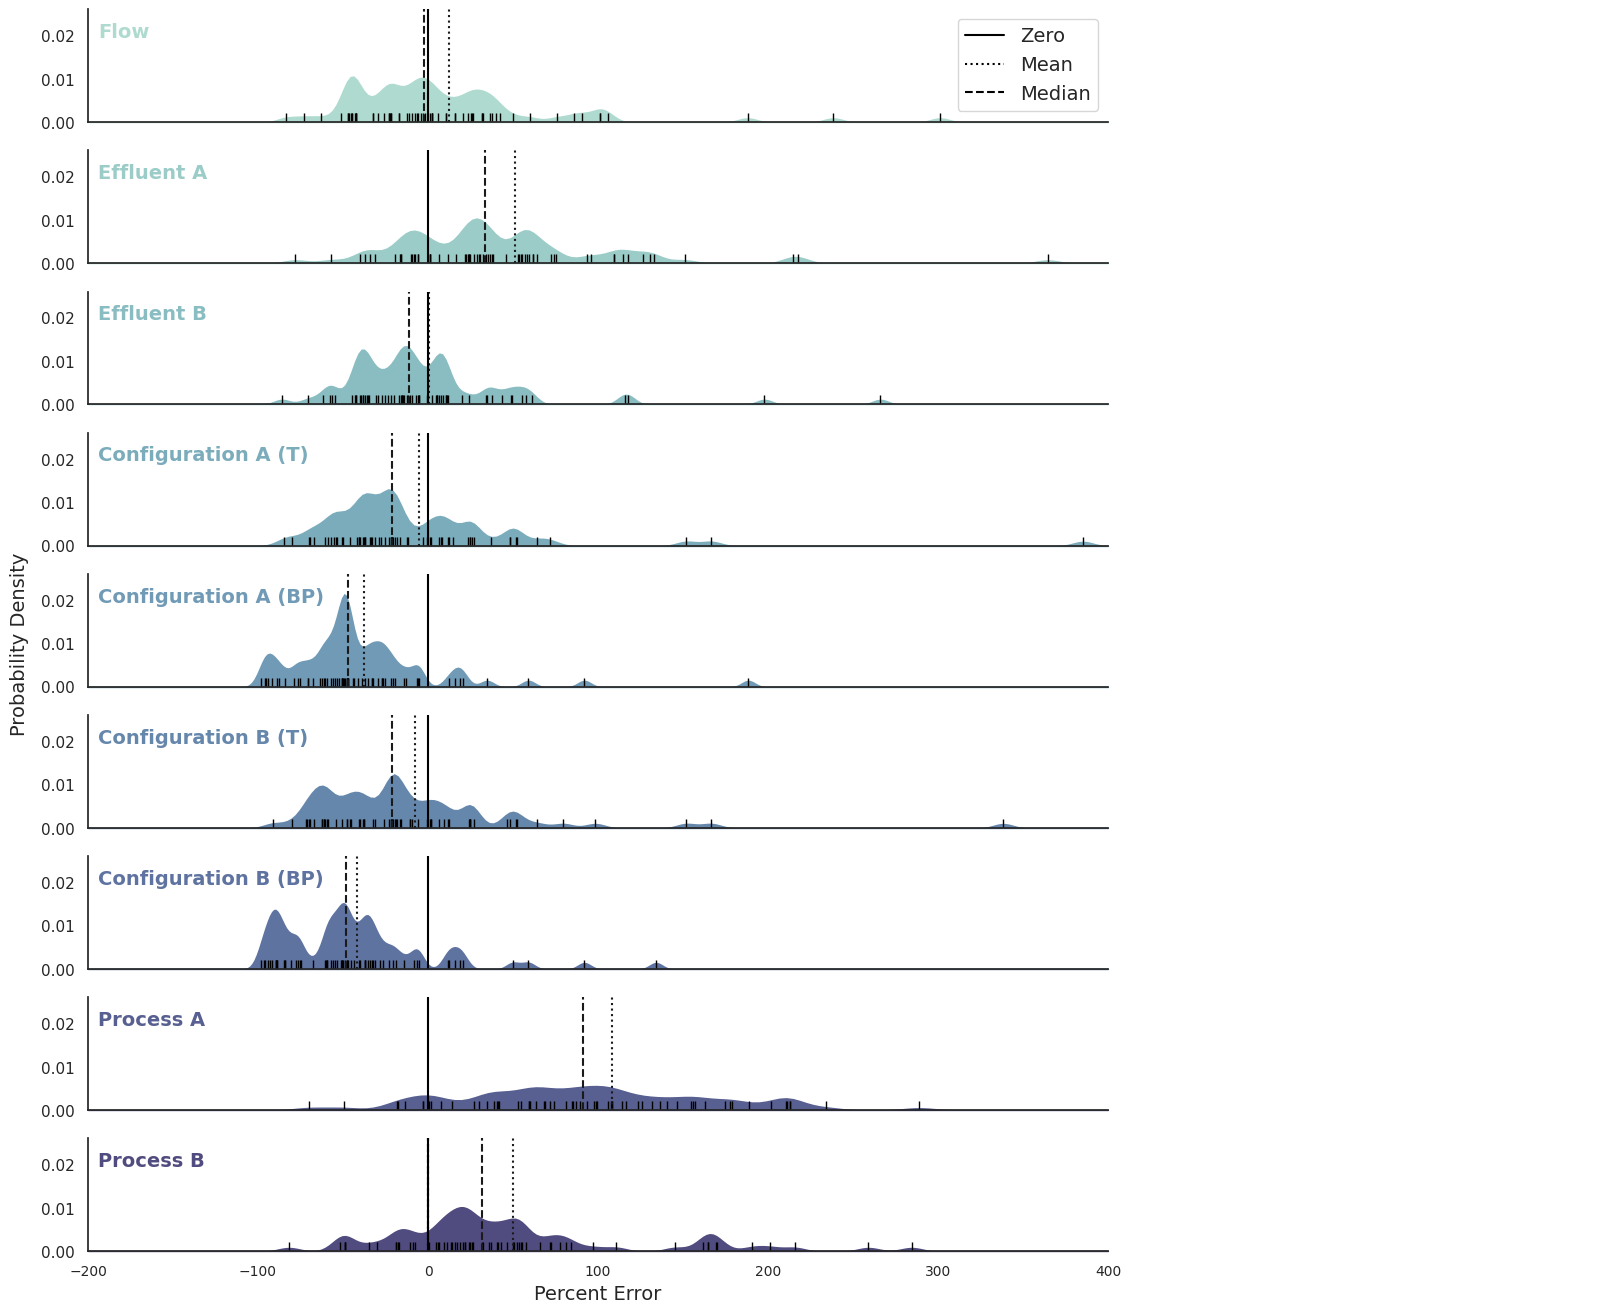

In [ ]:
#plot percent error in terms of total electricity consumption intensity for each method
eval = 'EI'

#filter main error_plt_elec dataframe to just error related to current evaluation method
kde_plt = error_plt_elec[[f'FLOW % Error ({eval})',f'EFFLUENT_A % Error ({eval})',f'EFFLUENT_B % Error ({eval})',f'CONFIGURATION_A_T % Error ({eval})',f'CONFIGURATION_A_BP % Error ({eval})',f'CONFIGURATION_B_T % Error ({eval})',f'CONFIGURATION_B_BP % Error ({eval})',f'PROCESS_A % Error ({eval})',f'PROCESS_B % Error ({eval})']]
kde_plt['M1'] = 'Flow'
kde_plt['M2a'] = 'Effluent A'
kde_plt['M2b'] = 'Effluent B'
kde_plt['M3a'] = 'Configuration A (T)'
kde_plt['M3b'] = 'Configuration A (BP)'
kde_plt['M4a'] = 'Configuration B (T)'
kde_plt['M4b'] = 'Configuration B (BP)'
kde_plt['M5'] = 'Process A'
kde_plt['M6'] = 'Process B'

#reformat dataframe to plot via facetgrid
M1 = kde_plt[['M1',f'FLOW % Error ({eval})']].rename(columns={'M1':'Method',f'FLOW % Error ({eval})':'Percent Error'})
M2a = kde_plt[['M2a',f'EFFLUENT_A % Error ({eval})']].rename(columns={'M2a':'Method',f'EFFLUENT_A % Error ({eval})':'Percent Error'})
M2b = kde_plt[['M2b',f'EFFLUENT_B % Error ({eval})']].rename(columns={'M2b':'Method',f'EFFLUENT_B % Error ({eval})':'Percent Error'})
M3a = kde_plt[['M3a',f'CONFIGURATION_A_T % Error ({eval})']].rename(columns={'M3a':'Method',f'CONFIGURATION_A_T % Error ({eval})':'Percent Error'})
M3b = kde_plt[['M3b',f'CONFIGURATION_A_BP % Error ({eval})']].rename(columns={'M3b':'Method',f'CONFIGURATION_A_BP % Error ({eval})':'Percent Error'})
M4a = kde_plt[['M4a',f'CONFIGURATION_B_T % Error ({eval})']].rename(columns={'M4a':'Method',f'CONFIGURATION_B_T % Error ({eval})':'Percent Error'})
M4b = kde_plt[['M4b',f'CONFIGURATION_B_BP % Error ({eval})']].rename(columns={'M4b':'Method',f'CONFIGURATION_B_BP % Error ({eval})':'Percent Error'})
M5 = kde_plt[['M5',f'PROCESS_A % Error ({eval})']].rename(columns={'M5':'Method',f'PROCESS_A % Error ({eval})':'Percent Error'})
M6 = kde_plt[['M6',f'PROCESS_B % Error ({eval})']].rename(columns={'M6':'Method',f'PROCESS_B % Error ({eval})':'Percent Error'})
cat_plt = pd.concat([M1,M2a,M2b,M3a,M3b,M4a,M4b,M5,M6])

#based on percent error, create ridgeline plots for each electricity consumption estimation method
sns.set_theme(style='white')
plt.figure(figsize=(8, 12))

#initialize the FacetGrid object and custom color palette
pal = sns.cubehelix_palette(12, start = 0.5, rot = -0.5, light = 0.8)
g = sns.FacetGrid(cat_plt, row = 'Method', hue = 'Method', aspect = 8, height = 1.5, palette = pal)

#draw the KDEs and rugplots
g.map(sns.kdeplot, 'Percent Error', bw_adjust = .2, clip_on = True, fill = True, alpha = 1, linewidth = 0, common_norm = True)
g.map(sns.rugplot, 'Percent Error', color = 'black', height = 0.08, lw = .1)
g.map(sns.kdeplot, 'Percent Error', clip_on = False, color = 'w', lw = 0, bw_adjust = .2, common_norm = True)
g.refline(y = 0, linewidth = 1, linestyle = "-", color = None, clip_on = False)

#set the subplots to not overlap
g.figure.subplots_adjust(hspace = 0.25)

#turn off axes and add y-label
g.despine(bottom = False, left = False)
g.fig.text(0.035, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 14)

#label each subplot with corresponding method
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .8, label, fontweight = 'bold', color = color,
            ha = 'left', va = 'center', transform = ax.transAxes, fontsize = 14)
    g.set(ylabel = "")
    g.set_titles("")

g.map(label, 'Percent Error')

#add dashed and dotted mean and median lines to each subplot
def mean_med_lines(x, **kwargs):
    plt.axvline(x.mean(), c = 'k', ls = ':', lw = 1.5)
    plt.axvline(x.median(), c = 'k', ls = 'dashed', lw = 1.5)

g.map(mean_med_lines,'Percent Error')

#add vertical black line at % Error = 0
zero = g.axes.flat[0].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[1].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[2].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[3].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[4].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[5].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[6].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[7].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[8].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')

#set x-axis limits to exclude outliers
g.set(xlim = (-200, 400))

#format x-axis
plt.setp(plt.gca().get_xticklabels(), fontsize = 10)
plt.xlabel('Percent Error', fontsize = 14)
g.axes.flat[0].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[1].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[2].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[3].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[4].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[5].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[6].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[7].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[8].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = True)

#add legend and y-axis label
g.axes.flat[0].legend([zero, plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = ':'),plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = 'dashed')], ['Zero', 'Mean', 'Median'], fontsize = 14)
g.figure.subplots_adjust(left=0.1, right=0.95, top=0.97, bottom=0.05, hspace=0.25)

#export figure to tiff
plt.savefig(path + f'results/figure_3.tiff', format = 'tiff')
plt.show()

In [ ]:
#calculate and print average percent error for each method estimating electricity intensity
PE1 = error_plt_elec['FLOW % Error (EI)'].sum() / error_plt_elec.shape[0]
PE2a = error_plt_elec['EFFLUENT_A % Error (EI)'].sum() / error_plt_elec.shape[0]
PE2b = error_plt_elec['EFFLUENT_B % Error (EI)'].sum() / error_plt_elec.shape[0]
PE3a = error_plt_elec['CONFIGURATION_A_T % Error (EI)'].sum() / error_plt_elec.shape[0]
PE3b = error_plt_elec['CONFIGURATION_A_BP % Error (EI)'].sum() / error_plt_elec.shape[0]
PE4a = error_plt_elec['CONFIGURATION_B_T % Error (EI)'].sum() / error_plt_elec.shape[0]
PE4b = error_plt_elec['CONFIGURATION_B_BP % Error (EI)'].sum() / error_plt_elec.shape[0]
PE5 = error_plt_elec['PROCESS_A % Error (EI)'].sum() / error_plt_elec.shape[0]
PE6 = error_plt_elec['PROCESS_B % Error (EI)'].sum() / error_plt_elec.shape[0]
PE_EI = {'FLOW % Error: ':PE1, 'EFFLUENT_A % Error: ':PE2a, 'EFFLUENT_B % Error: ':PE2b, 'CONFIGURATION_A_T % Error: ':PE3a, 'CONFIGURATION_A_BP % Error: ':PE3b, 'CONFIGURATION_B_T % Error: ':PE4a, 'CONFIGURATION_B_BP % Error: ':PE4b, 'PROCESS_A % Error: ':PE5, 'PROCESS_B % Error: ':PE6}

print('ELECTRICITY INTENSITY AVERAGE % ERROR')
print(dict(sorted(PE_EI.items(), key=lambda item: abs(item[1]))))
print(' ')

#reset percent error to be absolute
for method in methods:
  error_plt_elec[method + ' Error (EI)'] = abs(error_plt_elec[f'TOT_2012_{method}_KWH/M3'] - error_plt_elec['2012_CHINI_EI_KWH/M3'])
  error_plt_elec[method + ' % Error (EI)'] = (error_plt_elec[method + ' Error (EI)'] / error_plt_elec['2012_CHINI_EI_KWH/M3']) * 100

#calculate and print root mean squared error for each method estimating electricity intensity
RMSE1 = math.sqrt(sum(error_plt_elec['FLOW Error (EI)']**2) / (error_plt_elec['FLOW Error (EI)'].shape[0]))
RMSE2a = math.sqrt(sum(error_plt_elec['EFFLUENT_A Error (EI)']**2) / (error_plt_elec['EFFLUENT_A Error (EI)'].shape[0]))
RMSE2b = math.sqrt(sum(error_plt_elec['EFFLUENT_B Error (EI)']**2) / (error_plt_elec['EFFLUENT_B Error (EI)'].shape[0]))
RMSE3a = math.sqrt(sum(error_plt_elec['CONFIGURATION_A_T Error (EI)']**2) / (error_plt_elec['CONFIGURATION_A_T Error (EI)'].shape[0]))
RMSE3b = math.sqrt(sum(error_plt_elec['CONFIGURATION_A_BP Error (EI)']**2) / (error_plt_elec['CONFIGURATION_A_BP Error (EI)'].shape[0]))
RMSE4a = math.sqrt(sum(error_plt_elec['CONFIGURATION_B_T Error (EI)']**2) / (error_plt_elec['CONFIGURATION_B_T Error (EI)'].shape[0]))
RMSE4b = math.sqrt(sum(error_plt_elec['CONFIGURATION_B_BP Error (EI)']**2) / (error_plt_elec['CONFIGURATION_B_BP Error (EI)'].shape[0]))
RMSE5 = math.sqrt(sum(error_plt_elec['PROCESS_A Error (EI)']**2) / (error_plt_elec['PROCESS_A Error (EI)'].shape[0]))
RMSE6 = math.sqrt(sum(error_plt_elec['PROCESS_B Error (EI)']**2) / (error_plt_elec['PROCESS_B Error (EI)'].shape[0]))
RMSE_EI = {'FLOW RMSE: ':RMSE1, 'EFFLUENT_A RMSE: ':RMSE2a, 'EFFLUENT_B RMSE: ':RMSE2b, 'CONFIGURATION_A_T RMSE: ':RMSE3a, 'CONFIGURATION_A_BP RMSE: ':RMSE3b, 'CONFIGURATION_B_T RMSE: ':RMSE4a, 'CONFIGURATION_B_BP RMSE: ':RMSE4b, 'PROCESS_A RMSE: ':RMSE5, 'PROCESS_B RMSE: ':RMSE6}

print('ELECTRICITY INTENSITY RMSE')
print(dict(sorted(RMSE_EI.items(), key=lambda item: item[1])))
print(' ')

#calculate and print absolute percent error for each method estimating electricity intensity
PE1 = error_plt_elec['FLOW % Error (EI)'].sum() / error_plt_elec.shape[0]
PE2a = error_plt_elec['EFFLUENT_A % Error (EI)'].sum() / error_plt_elec.shape[0]
PE2b = error_plt_elec['EFFLUENT_B % Error (EI)'].sum() / error_plt_elec.shape[0]
PE3a = error_plt_elec['CONFIGURATION_A_T % Error (EI)'].sum() / error_plt_elec.shape[0]
PE3b = error_plt_elec['CONFIGURATION_A_BP % Error (EI)'].sum() / error_plt_elec.shape[0]
PE4a = error_plt_elec['CONFIGURATION_B_T % Error (EI)'].sum() / error_plt_elec.shape[0]
PE4b = error_plt_elec['CONFIGURATION_B_BP % Error (EI)'].sum() / error_plt_elec.shape[0]
PE5 = error_plt_elec['PROCESS_A % Error (EI)'].sum() / error_plt_elec.shape[0]
PE6 = error_plt_elec['PROCESS_B % Error (EI)'].sum() / error_plt_elec.shape[0]
APE_EI = {'FLOW % Error: ':PE1, 'EFFLUENT_A % Error: ':PE2a, 'EFFLUENT_B % Error: ':PE2b, 'CONFIGURATION_A_T % Error: ':PE3a, 'CONFIGURATION_A_BP % Error: ':PE3b, 'CONFIGURATION_B_T % Error: ':PE4a, 'CONFIGURATION_B_BP % Error: ':PE4b, 'PROCESS_A % Error: ':PE5, 'PROCESS_B % Error: ':PE6}

print('ELECTRICITY INTENSITY ABSOLUTE % ERROR')
print(dict(sorted(APE_EI.items(), key=lambda item: abs(item[1]))))
print(' ')

#export table of RMSE and MAPE for each electricity consumption estimation method
table_2 = pd.DataFrame(columns = ['Method','RMSE (kWh/m3)','MAPE (%)','MPE (%)'])
table_2.loc[len(table_2)] = {'Method':'Flow','RMSE (kWh/m3)':RMSE_EI['FLOW RMSE: '],'MAPE (%)':APE_EI['FLOW % Error: '],'MPE (%)':PE_EI['FLOW % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Effluent A','RMSE (kWh/m3)':RMSE_EI['EFFLUENT_A RMSE: '],'MAPE (%)':APE_EI['EFFLUENT_A % Error: '],'MPE (%)':PE_EI['EFFLUENT_A % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Effluent B','RMSE (kWh/m3)':RMSE_EI['EFFLUENT_B RMSE: '],'MAPE (%)':APE_EI['EFFLUENT_B % Error: '],'MPE (%)':PE_EI['EFFLUENT_B % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Configuration A (T)','RMSE (kWh/m3)':RMSE_EI['CONFIGURATION_A_T RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_A_T % Error: '],'MPE (%)':PE_EI['CONFIGURATION_A_T % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Configuration A (BP)','RMSE (kWh/m3)':RMSE_EI['CONFIGURATION_A_BP RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_A_BP % Error: '],'MPE (%)':PE_EI['CONFIGURATION_A_BP % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Configuration B (T)','RMSE (kWh/m3)':RMSE_EI['CONFIGURATION_B_T RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_B_T % Error: '],'MPE (%)':PE_EI['CONFIGURATION_B_T % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Configuration B (BP)','RMSE (kWh/m3)':RMSE_EI['CONFIGURATION_B_BP RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_B_BP % Error: '],'MPE (%)':PE_EI['CONFIGURATION_B_BP % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Process A','RMSE (kWh/m3)':RMSE_EI['PROCESS_A RMSE: '],'MAPE (%)':APE_EI['PROCESS_A % Error: '],'MPE (%)':PE_EI['PROCESS_A % Error: ']}
table_2.loc[len(table_2)] = {'Method':'Process B','RMSE (kWh/m3)':RMSE_EI['PROCESS_B RMSE: '],'MAPE (%)':APE_EI['PROCESS_B % Error: '],'MPE (%)':PE_EI['PROCESS_B % Error: ']}
table_2.to_csv(path + 'results/table_2.csv', index = False)

ELECTRICITY INTENSITY AVERAGE % ERROR
{'EFFLUENT_B % Error: ': np.float64(0.7631763730990416), 'CONFIGURATION_A_T % Error: ': np.float64(-5.284109684094353), 'CONFIGURATION_B_T % Error: ': np.float64(-7.697696855355026), 'FLOW % Error: ': np.float64(12.093750665667898), 'CONFIGURATION_A_BP % Error: ': np.float64(-37.56757771194041), 'CONFIGURATION_B_BP % Error: ': np.float64(-41.81454953257482), 'PROCESS_B % Error: ': np.float64(50.149522819997074), 'EFFLUENT_A % Error: ': np.float64(51.16365442689352), 'PROCESS_A % Error: ': np.float64(108.49782781256052)}
 
ELECTRICITY INTENSITY RMSE
{'EFFLUENT_A RMSE: ': 0.36179320932938275, 'EFFLUENT_B RMSE: ': 0.36842706990751145, 'FLOW RMSE: ': 0.3690997127221196, 'CONFIGURATION_A_T RMSE: ': 0.38645602394306827, 'PROCESS_B RMSE: ': 0.4055772107947536, 'CONFIGURATION_B_T RMSE: ': 0.4136216388608934, 'CONFIGURATION_A_BP RMSE: ': 0.4655755578655979, 'CONFIGURATION_B_BP RMSE: ': 0.5000844558367169, 'PROCESS_A RMSE: ': 0.5531807473500914}
 
ELECTRICIT

## Compare estimated and reported energy consumption

In [ ]:
#create dataframe with all energy consumption/intensity estimates and reported values
all_methods = select_cities[['CWNS_NUM','City_name','CWNS_TOT_2012_FLOW_MM3','CHINI_TOT_2012_FLOW_MM3','Total Energy Consumption (kWhe)']]
all_methods = pd.merge(all_methods, tt_a_t_2012[['CWNS_NUM','2012_CONFIGURATION_A_T_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_a_bp_2012[['CWNS_NUM','2012_CONFIGURATION_A_BP_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_b_t_2012[['CWNS_NUM','2012_CONFIGURATION_B_T_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_b_bp_2012[['CWNS_NUM','2012_CONFIGURATION_B_BP_ENERGY_USE_MJ']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, dd_2012[['CWNS_NUM','2012_REGRESSION_MJ']], on = 'CWNS_NUM', how = 'left')

#check for duplicates / improper merges
assert all_methods['CWNS_NUM'].value_counts().max() == 1

#convert reported energy consumption from kWhe to MJ
all_methods['2012_CHINI_ENERGY_USE_MJ'] = all_methods['Total Energy Consumption (kWhe)'] * 3.6
all_methods.drop(columns = 'Total Energy Consumption (kWhe)', inplace = True)

#add column for reported energy intensity
all_methods['2012_CHINI_EI_MJ/M3'] = all_methods['2012_CHINI_ENERGY_USE_MJ'] / (all_methods['CHINI_TOT_2012_FLOW_MM3'] * 10**6)

#create dataframe to hold energy consumption/intensity summed on a city basis
error_plt_energy = pd.DataFrame(all_methods[['City_name', 'CWNS_TOT_2012_FLOW_MM3','2012_CHINI_ENERGY_USE_MJ', '2012_CHINI_EI_MJ/M3']])
error_plt_energy.drop_duplicates(subset = ['City_name'], inplace = True)
error_plt_energy.reset_index(inplace = True, drop = True)

#iterate through method validation cities
for index, row in error_plt_energy.iterrows():
  city = row['City_name']
  #sum energy consumption for all wwtps in current city
  error_plt_energy.at[index,'TOT_2012_CONFIGURATION_A_T_MJ'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_A_T_ENERGY_USE_MJ'])
  error_plt_energy.at[index,'TOT_2012_CONFIGURATION_A_BP_MJ'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_A_BP_ENERGY_USE_MJ'])
  error_plt_energy.at[index,'TOT_2012_CONFIGURATION_B_T_MJ'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_B_T_ENERGY_USE_MJ'])
  error_plt_energy.at[index,'TOT_2012_CONFIGURATION_B_BP_MJ'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_B_BP_ENERGY_USE_MJ'])
  error_plt_energy.at[index,'TOT_2012_REGRESSION_MJ'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_REGRESSION_MJ'])

#calculate estimated energy intensity (MJ/m3) for city based on total flow rate
error_plt_energy['TOT_2012_CONFIGURATION_A_T_MJ/M3'] = (error_plt_energy['TOT_2012_CONFIGURATION_A_T_MJ']) / (error_plt_energy['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_energy['TOT_2012_CONFIGURATION_A_BP_MJ/M3'] = (error_plt_energy['TOT_2012_CONFIGURATION_A_BP_MJ']) / (error_plt_energy['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_energy['TOT_2012_CONFIGURATION_B_T_MJ/M3'] = (error_plt_energy['TOT_2012_CONFIGURATION_B_T_MJ']) / (error_plt_energy['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_energy['TOT_2012_CONFIGURATION_B_BP_MJ/M3'] = (error_plt_energy['TOT_2012_CONFIGURATION_B_BP_MJ']) / (error_plt_energy['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_energy['TOT_2012_REGRESSION_MJ/M3'] = (error_plt_energy['TOT_2012_REGRESSION_MJ']) / (error_plt_energy['CWNS_TOT_2012_FLOW_MM3'] * 10**6)

#initialize list of energy consumption methods
methods = ['CONFIGURATION_A_T','CONFIGURATION_A_BP','CONFIGURATION_B_T','CONFIGURATION_B_BP','REGRESSION']

#iterate through energy consumption methods
for method in methods:
  #calculate error associated with each method for energy intensity
  error_plt_energy[method + ' Error (EI)'] = error_plt_energy[f'TOT_2012_{method}_MJ/M3'] - error_plt_energy['2012_CHINI_EI_MJ/M3']

  #calculate percent error associated with each method for energy intensity
  error_plt_energy[method + ' % Error (EI)'] = (error_plt_energy[method + ' Error (EI)'] / error_plt_energy['2012_CHINI_EI_MJ/M3']) * 100

/tmp/ipython-input-33-2388161187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['M3a'] = 'Configuration A (T)'
/tmp/ipython-input-33-2388161187.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['M3b'] = 'Configuration A (BP)'
/tmp/ipython-input-33-2388161187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

<Figure size 600x1000 with 0 Axes>

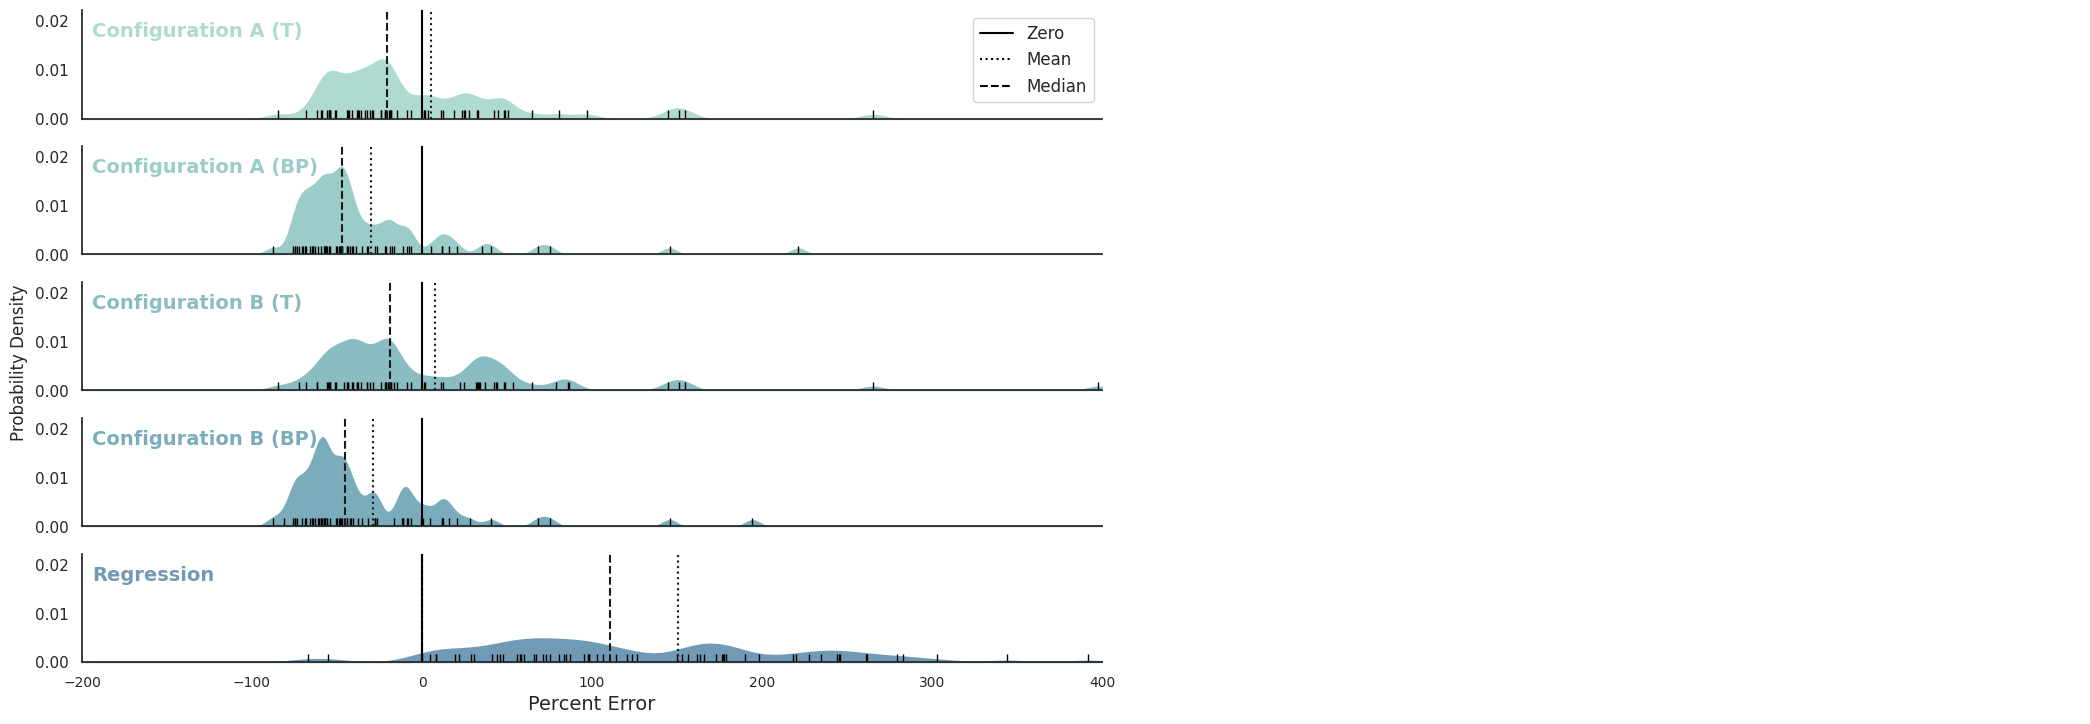

In [ ]:
#plot percent error for energy consumption estimation methods in terms of total consumption intensity

#filter main error_plt_energy dataframe to error related to energy estimation methods
kde_plt = error_plt_energy[[f'CONFIGURATION_A_T % Error ({eval})',f'CONFIGURATION_A_BP % Error ({eval})',f'CONFIGURATION_B_T % Error ({eval})',f'CONFIGURATION_B_BP % Error ({eval})',f'REGRESSION % Error ({eval})']]
kde_plt['M3a'] = 'Configuration A (T)'
kde_plt['M3b'] = 'Configuration A (BP)'
kde_plt['M4a'] = 'Configuration B (T)'
kde_plt['M4b'] = 'Configuration B (BP)'
kde_plt['M7'] = 'Regression'

#reformat dataframe to plot via facetgrid
M3a = kde_plt[['M3a',f'CONFIGURATION_A_T % Error ({eval})']].rename(columns={'M3a':'Method',f'CONFIGURATION_A_T % Error ({eval})':'Percent Error'})
M3b = kde_plt[['M3b',f'CONFIGURATION_A_BP % Error ({eval})']].rename(columns={'M3b':'Method',f'CONFIGURATION_A_BP % Error ({eval})':'Percent Error'})
M4a = kde_plt[['M4a',f'CONFIGURATION_B_T % Error ({eval})']].rename(columns={'M4a':'Method',f'CONFIGURATION_B_T % Error ({eval})':'Percent Error'})
M4b = kde_plt[['M4b',f'CONFIGURATION_B_BP % Error ({eval})']].rename(columns={'M4b':'Method',f'CONFIGURATION_B_BP % Error ({eval})':'Percent Error'})
M7 = kde_plt[['M7',f'REGRESSION % Error ({eval})']].rename(columns={'M7':'Method',f'REGRESSION % Error ({eval})':'Percent Error'})
cat_plt = pd.concat([M3a,M3b,M4a,M4b,M7])

#based on percent error, create ridgeline plots for each energy consumption estimation method
plt.figure(figsize=(6, 10))

#initialize the FacetGrid object and custom color palette
g = sns.FacetGrid(cat_plt, row = 'Method', hue = 'Method', aspect = 8, height = 1.5, palette = pal)

#draw the KDEs and rugplots
g.map(sns.kdeplot, 'Percent Error', bw_adjust = .2, clip_on = True, fill = True, alpha = 1, linewidth = 0)
g.map(sns.rugplot, 'Percent Error', color = 'black', height = 0.08, lw = .1)
g.map(sns.kdeplot, 'Percent Error', clip_on = False, color = 'w', lw = 0, bw_adjust = .2)
g.refline(y = 0, linewidth = 1, linestyle = "-", color = None, clip_on = False)

#set the subplots to not overlap
g.figure.subplots_adjust(hspace = 0.25)

#remove y-axis and tick marks
g.despine(bottom = False, left = False)
g.fig.text(0.04, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 12)

#label each subplot with corresponding method
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .8, label, fontweight = 'bold', color = color,
            ha = 'left', va = 'center', transform = ax.transAxes, fontsize = 14)
    g.set(ylabel = "")
    g.set_titles("")

g.map(label, 'Percent Error')

#add dashed and dotted mean and median lines to each subplot
def mean_med_lines(x, **kwargs):
    plt.axvline(x.mean(), c = 'k', ls = ':', lw = 1.5)
    plt.axvline(x.median(), c = 'k', ls = 'dashed', lw = 1.5)

g.map(mean_med_lines,'Percent Error')

#add vertical black line at % Error = 0
zero = g.axes.flat[0].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[1].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[2].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[3].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[4].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')

#set x-axis limits to exclude outliers
g.set(xlim = (-200, 400))

#format x-axis
plt.setp(plt.gca().get_xticklabels(), fontsize = 10)
plt.xlabel('Percent Error', fontsize = 14)
g.axes.flat[0].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[1].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[2].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[3].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[4].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = True)

#add legend and y-axis label
g.axes.flat[0].legend([zero, plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = ':'),plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = 'dashed')], ['Zero', 'Mean', 'Median'], fontsize = 12)
g.figure.subplots_adjust(left=0.1, right=0.95, top=0.97, bottom=0.1, hspace=0.25)

#export figure to tiff
plt.savefig(path + f'results/figure_4.tiff', format = 'tiff')

plt.show()

In [ ]:
#calculate and print percent error for each energy intensity estimation method
PE3a = error_plt_energy['CONFIGURATION_A_T % Error (EI)'].sum() / error_plt_energy.shape[0]
PE3b = error_plt_energy['CONFIGURATION_A_BP % Error (EI)'].sum() / error_plt_energy.shape[0]
PE4a = error_plt_energy['CONFIGURATION_B_T % Error (EI)'].sum() / error_plt_energy.shape[0]
PE4b = error_plt_energy['CONFIGURATION_B_BP % Error (EI)'].sum() / error_plt_energy.shape[0]
PE7 = error_plt_energy['REGRESSION % Error (EI)'].sum() / error_plt_energy.shape[0]
PE_EI = {'CONFIGURATION_A_T % Error: ':PE3a, 'CONFIGURATION_A_BP % Error: ':PE3b, 'CONFIGURATION_B_T % Error: ':PE4a, 'CONFIGURATION_B_BP % Error: ':PE4b,'REGRESSION % Error: ':PE7}

print('ENERGY INTENSITY AVERAGE % ERROR')
print(dict(sorted(PE_EI.items(), key=lambda item: abs(item[1]))))
print(' ')

#reset percent error to be absolute
for method in methods:
  error_plt_energy[method + ' Error (EI)'] = abs(error_plt_energy[f'TOT_2012_{method}_MJ/M3'] - error_plt_energy['2012_CHINI_EI_MJ/M3'])
  error_plt_energy[method + ' % Error (EI)'] = (error_plt_energy[method + ' Error (EI)'] / error_plt_energy['2012_CHINI_EI_MJ/M3']) * 100

#calculate and print root mean squared error for each energy intensity estimation method
RMSE3a = math.sqrt(sum(error_plt_energy['CONFIGURATION_A_T Error (EI)']**2) / (error_plt_energy['CONFIGURATION_A_T Error (EI)'].shape[0]))
RMSE3b = math.sqrt(sum(error_plt_energy['CONFIGURATION_A_BP Error (EI)']**2) / (error_plt_energy['CONFIGURATION_A_BP Error (EI)'].shape[0]))
RMSE4a = math.sqrt(sum(error_plt_energy['CONFIGURATION_B_T Error (EI)']**2) / (error_plt_energy['CONFIGURATION_B_T Error (EI)'].shape[0]))
RMSE4b = math.sqrt(sum(error_plt_energy['CONFIGURATION_B_BP Error (EI)']**2) / (error_plt_energy['CONFIGURATION_B_BP Error (EI)'].shape[0]))
RMSE7 = math.sqrt(sum(error_plt_energy['REGRESSION Error (EI)']**2) / (error_plt_energy['REGRESSION Error (EI)'].shape[0]))
RMSE_EI = {'CONFIGURATION_A_T RMSE: ':RMSE3a, 'CONFIGURATION_A_BP RMSE: ':RMSE3b,'CONFIGURATION_B_T RMSE: ':RMSE4a, 'CONFIGURATION_B_BP RMSE: ':RMSE4b, 'REGRESSION RMSE: ':RMSE7}

print('ENERGY INTENSITY RMSE')
print(dict(sorted(RMSE_EI.items(), key=lambda item: item[1])))
print(' ')

#calculate and print absolute percent error for each energy intensity estimation method
PE3a = error_plt_energy['CONFIGURATION_A_T % Error (EI)'].sum() / error_plt_energy.shape[0]
PE3b = error_plt_energy['CONFIGURATION_A_BP % Error (EI)'].sum() / error_plt_energy.shape[0]
PE4a = error_plt_energy['CONFIGURATION_B_T % Error (EI)'].sum() / error_plt_energy.shape[0]
PE4b = error_plt_energy['CONFIGURATION_B_BP % Error (EI)'].sum() / error_plt_energy.shape[0]
PE7 = error_plt_energy['REGRESSION % Error (EI)'].sum() / error_plt_energy.shape[0]
APE_EI = {'CONFIGURATION_A_T % Error: ':PE3a, 'CONFIGURATION_A_BP % Error: ':PE3b, 'CONFIGURATION_B_T % Error: ':PE4a, 'CONFIGURATION_B_BP % Error: ':PE4b,'REGRESSION % Error: ':PE7}

print('ENERGY INTENSITY ABSOLUTE % ERROR')
print(dict(sorted(PE_EI.items(), key=lambda item: abs(item[1]))))
print(' ')

#export table of RMSE and MAPE for each energy consumption estimation method
table_3 = pd.DataFrame(columns = ['Method','RMSE (MJ/m3)','MAPE (%)','MPE (%)'])
table_3.loc[len(table_3)] = {'Method':'Configuration A (T)','RMSE (MJ/m3)':RMSE_EI['CONFIGURATION_A_T RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_A_T % Error: '],'MPE (%)':PE_EI['CONFIGURATION_A_T % Error: ']}
table_3.loc[len(table_3)] = {'Method':'Configuration A (BP)','RMSE (MJ/m3)':RMSE_EI['CONFIGURATION_A_BP RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_A_BP % Error: '],'MPE (%)':PE_EI['CONFIGURATION_A_BP % Error: ']}
table_3.loc[len(table_3)] = {'Method':'Configuration B (T)','RMSE (MJ/m3)':RMSE_EI['CONFIGURATION_B_T RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_B_T % Error: '],'MPE (%)':PE_EI['CONFIGURATION_B_T % Error: ']}
table_3.loc[len(table_3)] = {'Method':'Configuration B (BP)','RMSE (MJ/m3)':RMSE_EI['CONFIGURATION_B_BP RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_B_BP % Error: '],'MPE (%)':PE_EI['CONFIGURATION_B_BP % Error: ']}
table_3.loc[len(table_3)] = {'Method':'Regression','RMSE (MJ/m3)':RMSE_EI['REGRESSION RMSE: '],'MAPE (%)':APE_EI['REGRESSION % Error: '],'MPE (%)':PE_EI['REGRESSION % Error: ']}
table_3.to_csv(path + 'results/table_3.csv', index = False)

ENERGY INTENSITY AVERAGE % ERROR
{'CONFIGURATION_A_T % Error: ': np.float64(5.024267710211815), 'CONFIGURATION_B_T % Error: ': np.float64(7.540021399734445), 'CONFIGURATION_B_BP % Error: ': np.float64(-29.011691997125173), 'CONFIGURATION_A_BP % Error: ': np.float64(-30.17264949209892), 'REGRESSION % Error: ': np.float64(150.34534454079824)}
 
ENERGY INTENSITY RMSE
{'CONFIGURATION_A_T RMSE: ': 1.4707597055443913, 'CONFIGURATION_B_T RMSE: ': 1.4811740457574634, 'CONFIGURATION_A_BP RMSE: ': 1.6752363316492418, 'CONFIGURATION_B_BP RMSE: ': 1.6754250778650253, 'REGRESSION RMSE: ': 2.710219081275}
 
ENERGY INTENSITY ABSOLUTE % ERROR
{'CONFIGURATION_A_T % Error: ': np.float64(5.024267710211815), 'CONFIGURATION_B_T % Error: ': np.float64(7.540021399734445), 'CONFIGURATION_B_BP % Error: ': np.float64(-29.011691997125173), 'CONFIGURATION_A_BP % Error: ': np.float64(-30.17264949209892), 'REGRESSION % Error: ': np.float64(150.34534454079824)}
 


## Compare estimated and reported energy recovery

In [ ]:
#create dataframe with all electricity generation intensity estimates and reported values for method validation cities
all_methods = select_cities[['CWNS_NUM','City_name','CWNS_TOT_2012_FLOW_MM3','CHINI_TOT_2012_FLOW_MM3','Biogas generation (therms)']]
all_methods = pd.merge(all_methods, tt_a_t_2012[['CWNS_NUM','2012_CONFIGURATION_A_T_ELEC_GEN_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_a_bp_2012[['CWNS_NUM','2012_CONFIGURATION_A_BP_ELEC_GEN_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_b_t_2012[['CWNS_NUM','2012_CONFIGURATION_B_T_ELEC_GEN_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, tt_b_bp_2012[['CWNS_NUM','2012_CONFIGURATION_B_BP_ELEC_GEN_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, epa_b_2012[['CWNS_NUM','2012_BIOGAS_A_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, epa_pm_2012[['CWNS_NUM','2012_BIOGAS_B_MWH']], on = 'CWNS_NUM', how = 'left')
all_methods = pd.merge(all_methods, biogas_c_2012[['CWNS_NUM','2012_BIOGAS_C_MWH']], on = 'CWNS_NUM', how = 'left')

#check for duplicates / improper merges
assert all_methods['CWNS_NUM'].value_counts().max() == 1

#convert reported electricity generation from biogas therms to MWh- assume that 70% of biogas is used for electricity production and that generators have an efficiency of 37% based on EIA 2012 survey
all_methods['Biogas generation (therms)'] = all_methods['Biogas generation (therms)'].fillna(0)
all_methods['2012_CHINI_ENERGY_GEN_MWH'] = all_methods['Biogas generation (therms)'] * 29.3001 * 0.70 * 0.37 / 1000
all_methods.drop(columns = ['Biogas generation (therms)'], inplace = True)

#add column for reported electricity generation intensity (MWh/m3)
all_methods['2012_CHINI_EI_MWH/M3'] = all_methods['2012_CHINI_ENERGY_GEN_MWH'] / (all_methods['CHINI_TOT_2012_FLOW_MM3'] * 10**6)

#create dataframe to hold total electricity generation/intensity estimation summed on a city basis
error_plt_gen = pd.DataFrame(all_methods[['City_name', 'CWNS_TOT_2012_FLOW_MM3','2012_CHINI_ENERGY_GEN_MWH', '2012_CHINI_EI_MWH/M3']])
error_plt_gen.drop_duplicates(subset = ['City_name'], inplace = True)
error_plt_gen.reset_index(inplace = True, drop = True)

#iterate through validation cities and sum electricity generation for all wwtps within that city
for index, row in error_plt_gen.iterrows():
  city = row['City_name']
  error_plt_gen.at[index,'TOT_2012_CONFIGURATION_A_T_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_A_T_ELEC_GEN_MWH'])
  error_plt_gen.at[index,'TOT_2012_CONFIGURATION_A_BP_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_A_BP_ELEC_GEN_MWH'])
  error_plt_gen.at[index,'TOT_2012_CONFIGURATION_B_T_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_B_T_ELEC_GEN_MWH'])
  error_plt_gen.at[index,'TOT_2012_CONFIGURATION_B_BP_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_CONFIGURATION_B_BP_ELEC_GEN_MWH'])
  error_plt_gen.at[index,'TOT_2012_BIOGAS_A_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_BIOGAS_A_MWH'])
  error_plt_gen.at[index,'TOT_2012_BIOGAS_B_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_BIOGAS_B_MWH'])
  error_plt_gen.at[index,'TOT_2012_BIOGAS_C_MWH'] = sum(all_methods.loc[all_methods['City_name'] == city, '2012_BIOGAS_C_MWH'])

#estimate electricity generation intensity (MWh/m3) for city based on total flow rate
error_plt_gen['TOT_2012_CONFIGURATION_A_T_MWH/M3'] = (error_plt_gen['TOT_2012_CONFIGURATION_A_T_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_gen['TOT_2012_CONFIGURATION_A_BP_MWH/M3'] = (error_plt_gen['TOT_2012_CONFIGURATION_A_BP_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_gen['TOT_2012_CONFIGURATION_B_T_MWH/M3'] = (error_plt_gen['TOT_2012_CONFIGURATION_B_T_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_gen['TOT_2012_CONFIGURATION_B_BP_MWH/M3'] = (error_plt_gen['TOT_2012_CONFIGURATION_B_BP_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_gen['TOT_2012_BIOGAS_A_MWH/M3'] = (error_plt_gen['TOT_2012_BIOGAS_A_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_gen['TOT_2012_BIOGAS_B_MWH/M3'] = (error_plt_gen['TOT_2012_BIOGAS_B_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)
error_plt_gen['TOT_2012_BIOGAS_C_MWH/M3'] = (error_plt_gen['TOT_2012_BIOGAS_C_MWH']) / (error_plt_gen['CWNS_TOT_2012_FLOW_MM3'] * 10**6)

#initialize list of electricity generation estimation methods
methods = ['CONFIGURATION_A_T','CONFIGURATION_A_BP','CONFIGURATION_B_T','CONFIGURATION_B_BP','BIOGAS_A','BIOGAS_B','BIOGAS_C']

#iterate through methods and calculate error
for method in methods:
  #calculate error associated with each method for electricity generation intensity
  error_plt_gen[method + ' Error (EI)'] = error_plt_gen[f'TOT_2012_{method}_MWH/M3'] - error_plt_gen['2012_CHINI_EI_MWH/M3']

  #calculate percent error associated with each method for electricity generation intensity
  error_plt_gen[method + ' % Error (EI)'] = (error_plt_gen[method + ' Error (EI)'] / error_plt_gen['2012_CHINI_EI_MWH/M3']) * 100

#drop cities which did not report sufficient unit process information to use configuration methods
error_plt_gen.dropna(inplace = True)

#remove cities that don't utilize biogas to generate electricity
error_plt_gen = error_plt_gen.loc[(error_plt_gen['2012_CHINI_ENERGY_GEN_MWH'] != 0) & (error_plt_gen['TOT_2012_BIOGAS_A_MWH'] != 0)]

/tmp/ipython-input-42-879456240.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['M3a'] = 'Configuration A (T)'
/tmp/ipython-input-42-879456240.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['M3b'] = 'Configuration A (BP)'
/tmp/ipython-input-42-879456240.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

<Figure size 600x1000 with 0 Axes>

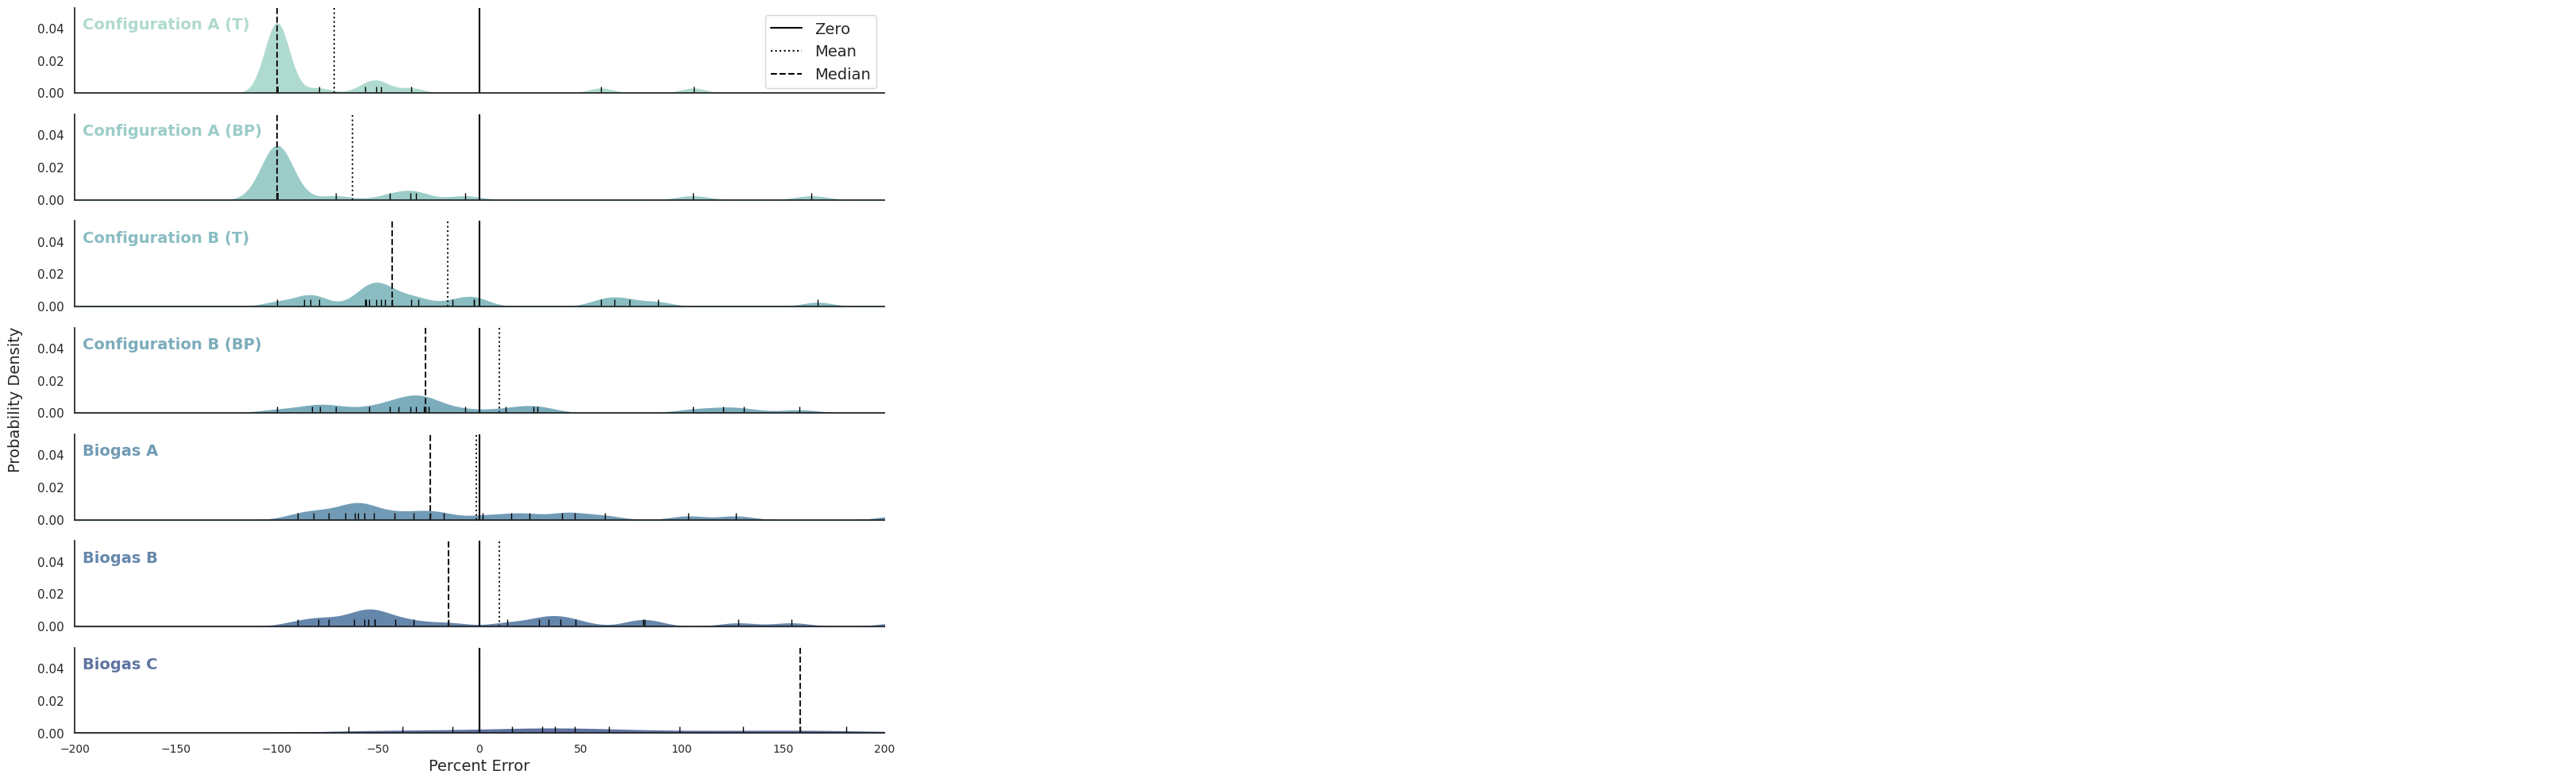

In [ ]:
#plot percent error for electricity generation estimation methods in terms of total generation intensity

#filter main error_plt dataframe to just error related to electricity generation estimation methods
kde_plt = error_plt_gen[[f'CONFIGURATION_A_T % Error ({eval})',f'CONFIGURATION_A_BP % Error ({eval})',f'CONFIGURATION_B_T % Error ({eval})',f'CONFIGURATION_B_BP % Error ({eval})',f'BIOGAS_A % Error ({eval})',f'BIOGAS_B % Error ({eval})', f'BIOGAS_C % Error ({eval})']]
kde_plt['M3a'] = 'Configuration A (T)'
kde_plt['M3b'] = 'Configuration A (BP)'
kde_plt['M4a'] = 'Configuration B (T)'
kde_plt['M4b'] = 'Configuration B (BP)'
kde_plt['M6a'] = 'Biogas A'
kde_plt['M6b'] = 'Biogas B'
kde_plt['M8'] = 'Biogas C'

#reformat dataframe to plot via facetgrid
M3a = kde_plt[['M3a',f'CONFIGURATION_A_T % Error ({eval})']].rename(columns={'M3a':'Method',f'CONFIGURATION_A_T % Error ({eval})':'Percent Error'})
M3b = kde_plt[['M3b',f'CONFIGURATION_A_BP % Error ({eval})']].rename(columns={'M3b':'Method',f'CONFIGURATION_A_BP % Error ({eval})':'Percent Error'})
M4a = kde_plt[['M4a',f'CONFIGURATION_B_T % Error ({eval})']].rename(columns={'M4a':'Method',f'CONFIGURATION_B_T % Error ({eval})':'Percent Error'})
M4b = kde_plt[['M4b',f'CONFIGURATION_B_BP % Error ({eval})']].rename(columns={'M4b':'Method',f'CONFIGURATION_B_BP % Error ({eval})':'Percent Error'})
M6a = kde_plt[['M6a',f'BIOGAS_A % Error ({eval})']].rename(columns={'M6a':'Method',f'BIOGAS_A % Error ({eval})':'Percent Error'})
M6b = kde_plt[['M6b',f'BIOGAS_B % Error ({eval})']].rename(columns={'M6b':'Method',f'BIOGAS_B % Error ({eval})':'Percent Error'})
M8 = kde_plt[['M8',f'BIOGAS_C % Error ({eval})']].rename(columns={'M8':'Method',f'BIOGAS_C % Error ({eval})':'Percent Error'})
cat_plt = pd.concat([M3a,M3b,M4a,M4b,M6a,M6b,M8])

#based on percent error, create ridgeline plots for each energy consumption estimation method
plt.figure(figsize=(6, 10))

#initialize the FacetGrid object
g = sns.FacetGrid(cat_plt, row = 'Method', hue = 'Method', aspect = 8, height = 1.5, palette = pal)

#draw the KDEs and rugplots
g.map(sns.kdeplot, 'Percent Error', bw_adjust = .2, clip_on = True, fill = True, alpha = 1, linewidth = 0)
g.map(sns.rugplot, 'Percent Error', color = 'black', height = 0.08, lw = .1)
g.map(sns.kdeplot, 'Percent Error', clip_on = False, color = 'w', lw = 0, bw_adjust = .2)
g.refline(y = 0, linewidth = 1, linestyle = "-", color = None, clip_on = False)

#set the subplots to not overlap
g.figure.subplots_adjust(hspace = 0.25)

#remove y-axis and tick marks
g.despine(bottom = False, left = False)
g.fig.text(0.03, 0.5, 'Probability Density', va='center', rotation='vertical', fontsize = 14)

#label each subplot with corresponding method
def label(x, color, label):
    ax = plt.gca()
    ax.text(0.01, .8, label, fontweight = 'bold', color = color,
            ha = 'left', va = 'center', transform = ax.transAxes, fontsize = 14)
    g.set(ylabel = "")
    g.set_titles("")

g.map(label, 'Percent Error')

#add dashed and dotted mean and median lines to each subplot
def mean_med_lines(x, **kwargs):
    plt.axvline(x.mean(), c = 'k', ls = ':', lw = 1.5)
    plt.axvline(x.median(), c = 'k', ls = 'dashed', lw = 1.5)

g.map(mean_med_lines,'Percent Error')

#add vertical black line at % error = 0
zero = g.axes.flat[0].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[1].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[2].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[3].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[4].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[5].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
g.axes.flat[6].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')

#set x-axis limits to exclude outliers
g.set(xlim = (-200, 200))

#format x-axis
plt.setp(plt.gca().get_xticklabels(), fontsize = 10)
plt.xlabel('Percent Error', fontsize = 14)
g.axes.flat[0].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[1].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[2].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[3].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[4].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[5].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
g.axes.flat[6].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = True)

#add legend and y-axis label
g.axes.flat[0].legend([zero, plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = ':'),plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = 'dashed')], ['Zero', 'Mean', 'Median'], fontsize = 14)
g.figure.subplots_adjust(left=0.1, right=0.95, top=0.97, bottom=0.1, hspace=0.25)

#export figure to tiff
plt.savefig(path + f'results/figure_5.tiff', format = 'tiff')

plt.show()

In [ ]:
#calculate and print average percent error for each total electricity generation intensity estimation method
PE3a = error_plt_gen['CONFIGURATION_A_T % Error (EI)'].sum() / error_plt_gen.shape[0]
PE3b = error_plt_gen['CONFIGURATION_A_BP % Error (EI)'].sum() / error_plt_gen.shape[0]
PE4a = error_plt_gen['CONFIGURATION_B_T % Error (EI)'].sum() / error_plt_gen.shape[0]
PE4b = error_plt_gen['CONFIGURATION_B_BP % Error (EI)'].sum() / error_plt_gen.shape[0]
PE6a = error_plt_gen['BIOGAS_A % Error (EI)'].sum() / error_plt_gen.shape[0]
PE6b = error_plt_gen['BIOGAS_B % Error (EI)'].sum() / error_plt_gen.shape[0]
PE8 = error_plt_gen['BIOGAS_C % Error (EI)'].sum() / error_plt_gen.shape[0]

PE_EI = {'CONFIGURATION_A_T % Error: ':PE3a, 'CONFIGURATION_A_BP % Error: ':PE3b, 'CONFIGURATION_B_T % Error: ':PE4a, 'CONFIGURATION_B_BP % Error: ':PE4b,'BIOGAS_A % Error: ':PE6a, 'BIOGAS_B % Error: ':PE6b, 'BIOGAS_C % Error: ':PE8}

print('ELECTRICITY GENERATION INTENSITY AVERAGE % ERROR')
print(dict(sorted(PE_EI.items(), key=lambda item: abs(item[1]))))
print(' ')

#reset percent error to absolute
for method in methods:
  #calculate error associated with each method for total electricity generation
  error_plt_gen[method + ' Error (EI)'] = abs(error_plt_gen[f'TOT_2012_{method}_MWH/M3'] - error_plt_gen['2012_CHINI_EI_MWH/M3'])
  error_plt_gen[method + ' % Error (EI)'] = (error_plt_gen[method + ' Error (EI)'] / error_plt_gen['2012_CHINI_EI_MWH/M3']) * 100

#calculate and print root mean squared error for each electricity generation intensity estimation method
RMSE3a = math.sqrt(sum(error_plt_gen['CONFIGURATION_A_T Error (EI)']**2) / (error_plt_gen['CONFIGURATION_A_T Error (EI)'].shape[0]))
RMSE3b = math.sqrt(sum(error_plt_gen['CONFIGURATION_A_BP Error (EI)']**2) / (error_plt_gen['CONFIGURATION_A_BP Error (EI)'].shape[0]))
RMSE4a = math.sqrt(sum(error_plt_gen['CONFIGURATION_B_T Error (EI)']**2) / (error_plt_gen['CONFIGURATION_B_T Error (EI)'].shape[0]))
RMSE4b = math.sqrt(sum(error_plt_gen['CONFIGURATION_B_BP Error (EI)']**2) / (error_plt_gen['CONFIGURATION_B_BP Error (EI)'].shape[0]))
RMSE6a = math.sqrt(sum(error_plt_gen['BIOGAS_A Error (EI)']**2) / (error_plt_gen['BIOGAS_A Error (EI)'].shape[0]))
RMSE6b = math.sqrt(sum(error_plt_gen['BIOGAS_B Error (EI)']**2) / (error_plt_gen['BIOGAS_B Error (EI)'].shape[0]))
RMSE8 = math.sqrt(sum(error_plt_gen['BIOGAS_C Error (EI)']**2) / (error_plt_gen['BIOGAS_C Error (EI)'].shape[0]))

RMSE_EI = {'CONFIGURATION_A_T RMSE: ':RMSE3a, 'CONFIGURATION_A_BP RMSE: ':RMSE3b,'CONFIGURATION_B_T RMSE: ':RMSE4a, 'CONFIGURATION_B_BP RMSE: ':RMSE4b, 'BIOGAS_A RMSE: ':RMSE6a, 'BIOGAS_B RMSE: ':RMSE6b, 'BIOGAS_C RMSE: ':RMSE8}

print('ELECTRICITY GENERATION INTENSITY RMSES')
print(dict(sorted(RMSE_EI.items(), key=lambda item: item[1])))
print(' ')

#calculate and print absolute percent error for each total electricity generation intensity estimation method
PE3a = error_plt_gen['CONFIGURATION_A_T % Error (EI)'].sum() / error_plt_gen.shape[0]
PE3b = error_plt_gen['CONFIGURATION_A_BP % Error (EI)'].sum() / error_plt_gen.shape[0]
PE4a = error_plt_gen['CONFIGURATION_B_T % Error (EI)'].sum() / error_plt_gen.shape[0]
PE4b = error_plt_gen['CONFIGURATION_B_BP % Error (EI)'].sum() / error_plt_gen.shape[0]
PE6a = error_plt_gen['BIOGAS_A % Error (EI)'].sum() / error_plt_gen.shape[0]
PE6b = error_plt_gen['BIOGAS_B % Error (EI)'].sum() / error_plt_gen.shape[0]
PE8 = error_plt_gen['BIOGAS_C % Error (EI)'].sum() / error_plt_gen.shape[0]

APE_EI = {'CONFIGURATION_A_T % Error: ':PE3a, 'CONFIGURATION_A_BP % Error: ':PE3b, 'CONFIGURATION_B_T % Error: ':PE4a, 'CONFIGURATION_B_BP % Error: ':PE4b,'BIOGAS_A % Error: ':PE6a, 'BIOGAS_B % Error: ':PE6b, 'BIOGAS_C % Error: ':PE8}

print('ELECTRICITY GENERATION INTENSITY ABSOLUTE % ERROR')
print(dict(sorted(APE_EI.items(), key=lambda item: abs(item[1]))))
print(' ')

#export table of RMSE and MAPE for each energy recovery estimation method
table_4 = pd.DataFrame(columns = ['Method','RMSE (MWh/m3)','MAPE (%)','MPE (%)'])
table_4.loc[len(table_4)] = {'Method':'Configuration A (T)','RMSE (MWh/m3)':RMSE_EI['CONFIGURATION_A_T RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_A_T % Error: '],'MPE (%)':PE_EI['CONFIGURATION_A_T % Error: ']}
table_4.loc[len(table_4)] = {'Method':'Configuration A (BP)','RMSE (MWh/m3)':RMSE_EI['CONFIGURATION_A_BP RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_A_BP % Error: '],'MPE (%)':PE_EI['CONFIGURATION_A_BP % Error: ']}
table_4.loc[len(table_4)] = {'Method':'Configuration B (T)','RMSE (MWh/m3)':RMSE_EI['CONFIGURATION_B_T RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_B_T % Error: '],'MPE (%)':PE_EI['CONFIGURATION_B_T % Error: ']}
table_4.loc[len(table_4)] = {'Method':'Configuration B (BP)','RMSE (MWh/m3)':RMSE_EI['CONFIGURATION_B_BP RMSE: '],'MAPE (%)':APE_EI['CONFIGURATION_B_BP % Error: '],'MPE (%)':PE_EI['CONFIGURATION_B_BP % Error: ']}
table_4.loc[len(table_4)] = {'Method':'Biogas A','RMSE (MWh/m3)':RMSE_EI['BIOGAS_A RMSE: '],'MAPE (%)':APE_EI['BIOGAS_A % Error: '],'MPE (%)':PE_EI['BIOGAS_A % Error: ']}
table_4.loc[len(table_4)] = {'Method':'Biogas B','RMSE (MWh/m3)':RMSE_EI['BIOGAS_B RMSE: '],'MAPE (%)':APE_EI['BIOGAS_B % Error: '],'MPE (%)':PE_EI['BIOGAS_B % Error: ']}
table_4.loc[len(table_4)] = {'Method':'Biogas C','RMSE (MWh/m3)':RMSE_EI['BIOGAS_C RMSE: '],'MAPE (%)':APE_EI['BIOGAS_C % Error: '],'MPE (%)':PE_EI['BIOGAS_C % Error: ']}
table_4['RMSE (kWh/m3)'] = table_4['RMSE (MWh/m3)'] * 1000
table_4.drop(columns = 'RMSE (MWh/m3)', inplace = True)
table_4.to_csv(path + 'results/table_4.csv', index = False)

ELECTRICITY GENERATION INTENSITY AVERAGE % ERROR
{'BIOGAS_A % Error: ': np.float64(-1.532324546527536), 'BIOGAS_B % Error: ': np.float64(9.77117881422458), 'CONFIGURATION_B_BP % Error: ': np.float64(9.937402595168985), 'CONFIGURATION_B_T % Error: ': np.float64(-15.84894318480198), 'CONFIGURATION_A_BP % Error: ': np.float64(-62.77228255102835), 'CONFIGURATION_A_T % Error: ': np.float64(-71.58027175028936), 'BIOGAS_C % Error: ': np.float64(236.62411211982592)}
 
ELECTRICITY GENERATION INTENSITY RMSES
{'CONFIGURATION_B_BP RMSE: ': 0.0002759114113077991, 'CONFIGURATION_B_T RMSE: ': 0.00029250308892206904, 'BIOGAS_B RMSE: ': 0.0002985145896911491, 'BIOGAS_A RMSE: ': 0.0003002440074430783, 'BIOGAS_C RMSE: ': 0.0003084425541635204, 'CONFIGURATION_A_BP RMSE: ': 0.0003344732812886698, 'CONFIGURATION_A_T RMSE: ': 0.0003405812312240566}
 
ELECTRICITY GENERATION INTENSITY ABSOLUTE % ERROR
{'CONFIGURATION_B_T % Error: ': np.float64(59.26051202670723), 'BIOGAS_A % Error: ': np.float64(61.26859278953

## Compare estimated and reported electricity consumption based on plant characteristics

In [ ]:
#calculate percent of reported electricity use for each method
error_plt_elec['Flow'] = error_plt_elec['TOT_2012_FLOW_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Effluent A'] = error_plt_elec['TOT_2012_EFFLUENT_A_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Effluent B'] = error_plt_elec['TOT_2012_EFFLUENT_B_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Configuration A (T)'] = error_plt_elec['TOT_2012_CONFIGURATION_A_T_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Configuration A (BP)'] = error_plt_elec['TOT_2012_CONFIGURATION_A_BP_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Configuration B (T)'] = error_plt_elec['TOT_2012_CONFIGURATION_B_T_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Configuration B (BP)'] = error_plt_elec['TOT_2012_CONFIGURATION_B_BP_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Process A'] = error_plt_elec['TOT_2012_PROCESS_A_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100
error_plt_elec['Process B'] = error_plt_elec['TOT_2012_PROCESS_B_KWH/M3']/error_plt_elec['2012_CHINI_EI_KWH/M3'] * 100

#create separate dataframe for percent of reported electricity use by plant characteristics like size, location, and ETL
kde_plt = error_plt_elec[['City_name','CWNS_TOT_2012_FLOW_MM3','Flow','Effluent A','Effluent B','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Process A','Process B']]
kde_plt['Effluent Treatment Level(s)'] = np.nan
kde_plt['Effluent Treatment Level(s)'] = kde_plt['Effluent Treatment Level(s)'].astype('object')

#classify flow, ETL, and latitude for each city
for index, row in kde_plt.iterrows():
  city = row['City_name']
  flow = row['CWNS_TOT_2012_FLOW_MM3']
  cwns = select_cities.loc[select_cities['City_name'] == city, 'CWNS_NUM'].to_list()

  #categorize flow
  if flow < 16:
    kde_plt.at[index, 'Flow Classification'] = '0-16 MM3/YEAR'
  elif (flow >= 16) & (flow < 46):
    kde_plt.at[index, 'Flow Classification'] = '16-46 MM3/YEAR'
  elif (flow >= 46) & (flow < 100):
    kde_plt.at[index, 'Flow Classification'] = '46-100 MM3/YEAR'
  elif flow >= 100:
    kde_plt.at[index, 'Flow Classification'] = '100+ MM3/YEAR'

  #categorize ETL
  etls = wwtps_2012.loc[wwtps_2012['CWNS_NUM'].isin(cwns)]['2012_EFFLUENT_TREATMENT_LEVEL'].to_list()
  if all([i == etls[0] for i in etls]):
    kde_plt.at[index, 'ETL Classification'] = etls[0]
  else:
    kde_plt.at[index, 'ETL Classification'] = 'Multiple ETLs'

  #categorize latitude
  lat = wwtps_2012.loc[wwtps_2012['CWNS_NUM'] == cwns[0], 'LATITUDE'].values[0]
  kde_plt.at[index, 'Latitude'] = lat
  if lat <= 35:
    kde_plt.at[index, 'Latitude Classification'] = '< 35 degrees'
  elif (lat > 35) & (lat <= 42.5):
    kde_plt.at[index, 'Latitude Classification'] = '35 - 42.5 degrees'
  elif lat > 42.5:
    kde_plt.at[index, 'Latitude Classification'] = '> 42.5 degrees'

#correct naming convention of ETLs
kde_plt.loc[kde_plt['ETL Classification'] == 'Secondary', 'ETL Classification'] = 'Secondary Treatment'
kde_plt.loc[kde_plt['ETL Classification'] == 'Primary (45mg/l< BOD)', 'ETL Classification'] = 'Primary Treatment'

#add column for the number of cities per lat/flow/ETL category for groupby function
kde_plt['# Cities'] = 1

#create table to show how average percent of reported electricity use differs by flow
flow_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','Flow Classification','Flow','Effluent A','Effluent B','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Process A','Process B']].groupby(['Flow Classification']).sum()
flow_class['Flow'] = flow_class['Flow']/flow_class['# Cities']
flow_class['Effluent A'] = flow_class['Effluent A']/flow_class['# Cities']
flow_class['Effluent B'] = flow_class['Effluent B']/flow_class['# Cities']
flow_class['Configuration A (T)'] = flow_class['Configuration A (T)']/flow_class['# Cities']
flow_class['Configuration A (BP)'] = flow_class['Configuration A (BP)']/flow_class['# Cities']
flow_class['Configuration B (T)'] = flow_class['Configuration B (T)']/flow_class['# Cities']
flow_class['Configuration B (BP)'] = flow_class['Configuration B (BP)']/flow_class['# Cities']
flow_class['Process A'] = flow_class['Process A']/flow_class['# Cities']
flow_class['Process B'] = flow_class['Process B']/flow_class['# Cities']

#create table to show how average percent of reported electricity use differs by ETL
etl_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','ETL Classification','Flow','Effluent A','Effluent B','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Process A','Process B']].groupby(['ETL Classification']).sum()
etl_class['Flow'] = etl_class['Flow']/etl_class['# Cities']
etl_class['Effluent A'] = etl_class['Effluent A']/etl_class['# Cities']
etl_class['Effluent B'] = etl_class['Effluent B']/etl_class['# Cities']
etl_class['Configuration A (T)'] = etl_class['Configuration A (T)']/etl_class['# Cities']
etl_class['Configuration A (BP)'] = etl_class['Configuration A (BP)']/etl_class['# Cities']
etl_class['Configuration B (T)'] = etl_class['Configuration B (T)']/etl_class['# Cities']
etl_class['Configuration B (BP)'] = etl_class['Configuration B (BP)']/etl_class['# Cities']
etl_class['Process A'] = etl_class['Process A']/etl_class['# Cities']
etl_class['Process B'] = etl_class['Process B']/etl_class['# Cities']

#create table to show how average percent of reported electricity use differs by latitude
lat_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','Latitude Classification','Flow','Effluent A','Effluent B','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Process A','Process B']].groupby(['Latitude Classification']).sum()
lat_class['Flow'] = lat_class['Flow']/lat_class['# Cities']
lat_class['Effluent A'] = lat_class['Effluent A']/lat_class['# Cities']
lat_class['Effluent B'] = lat_class['Effluent B']/lat_class['# Cities']
lat_class['Configuration A (T)'] = lat_class['Configuration A (T)']/lat_class['# Cities']
lat_class['Configuration A (BP)'] = lat_class['Configuration A (BP)']/lat_class['# Cities']
lat_class['Configuration B (T)'] = lat_class['Configuration B (T)']/lat_class['# Cities']
lat_class['Configuration B (BP)'] = lat_class['Configuration B (BP)']/lat_class['# Cities']
lat_class['Process A'] = lat_class['Process A']/lat_class['# Cities']
lat_class['Process B'] = lat_class['Process B']/lat_class['# Cities']

#combine into one dataframe and reorder categories
elec_class = pd.concat([flow_class,etl_class,lat_class])
elec_class = elec_class.reindex(['16-46 MM3/YEAR','46-100 MM3/YEAR','100+ MM3/YEAR','Primary Treatment','Secondary Treatment','Advanced Treatment','Multiple ETLs','< 35 degrees','35 - 42.5 degrees','> 42.5 degrees'], level = 0)

#export dataframe of how percent of reported electricity consumption varies plant characteristics
elec_class.to_csv(path + 'results/table_5.csv')

/tmp/ipython-input-44-3795489688.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['Effluent Treatment Level(s)'] = np.nan
/tmp/ipython-input-44-3795489688.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['Effluent Treatment Level(s)'] = kde_plt['Effluent Treatment Level(s)'].astype('object')
/tmp/ipython-input-44-3795489688.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

/tmp/ipython-input-45-1926222738.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(dpi = 600)


<Figure size 3840x2880 with 0 Axes>

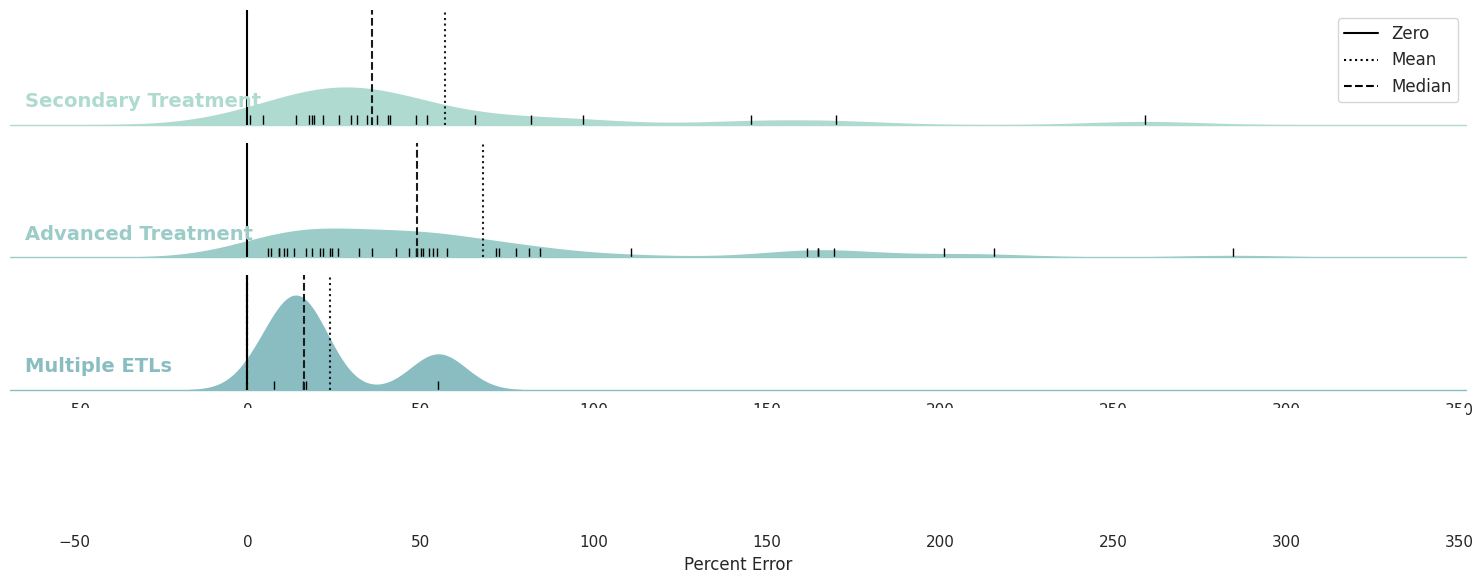

<Figure size 3840x2880 with 0 Axes>

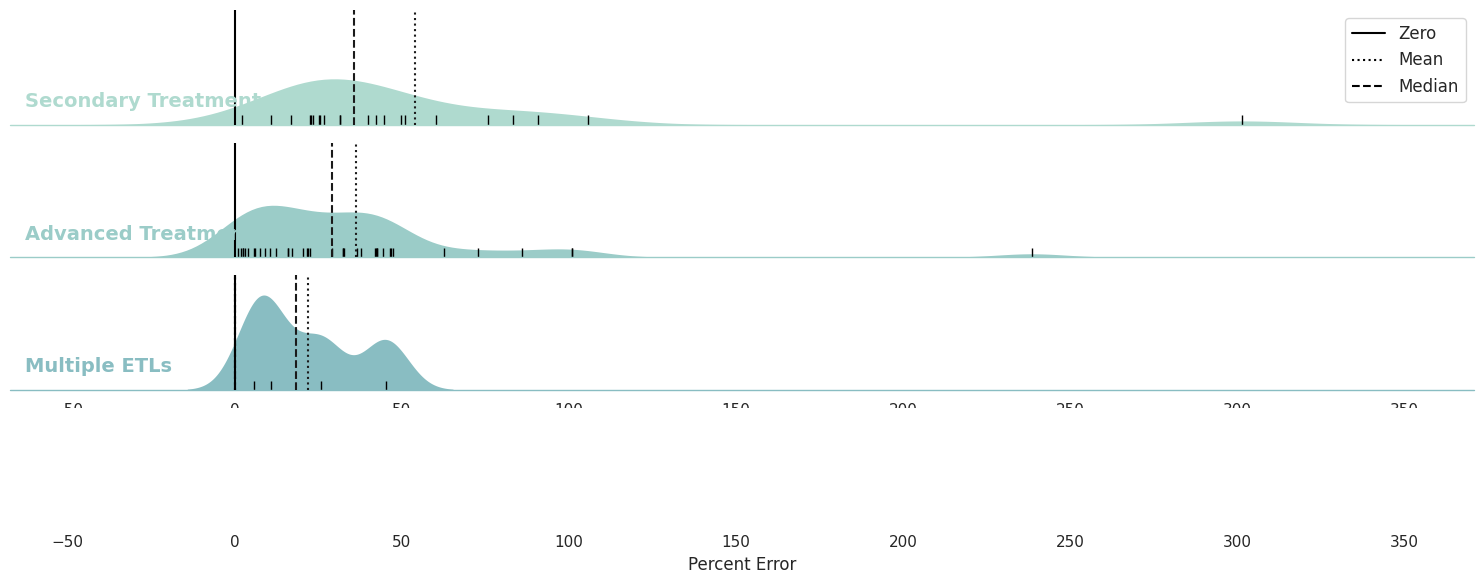

<Figure size 3840x2880 with 0 Axes>

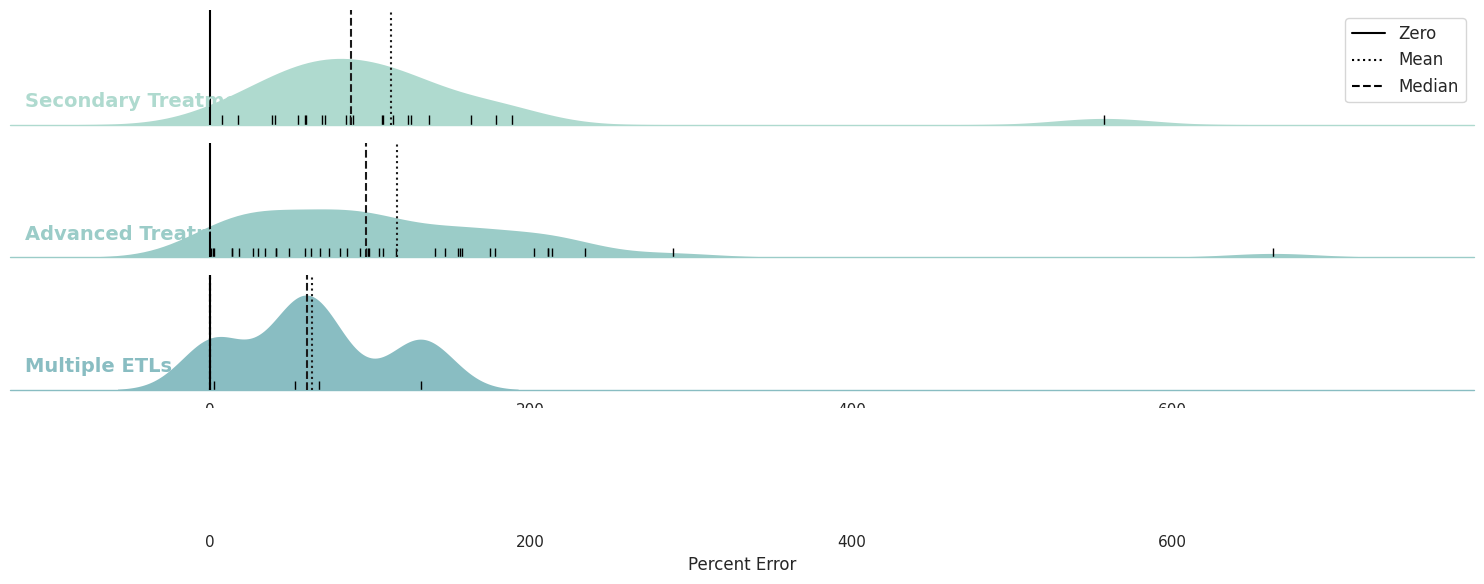

<Figure size 3840x2880 with 0 Axes>

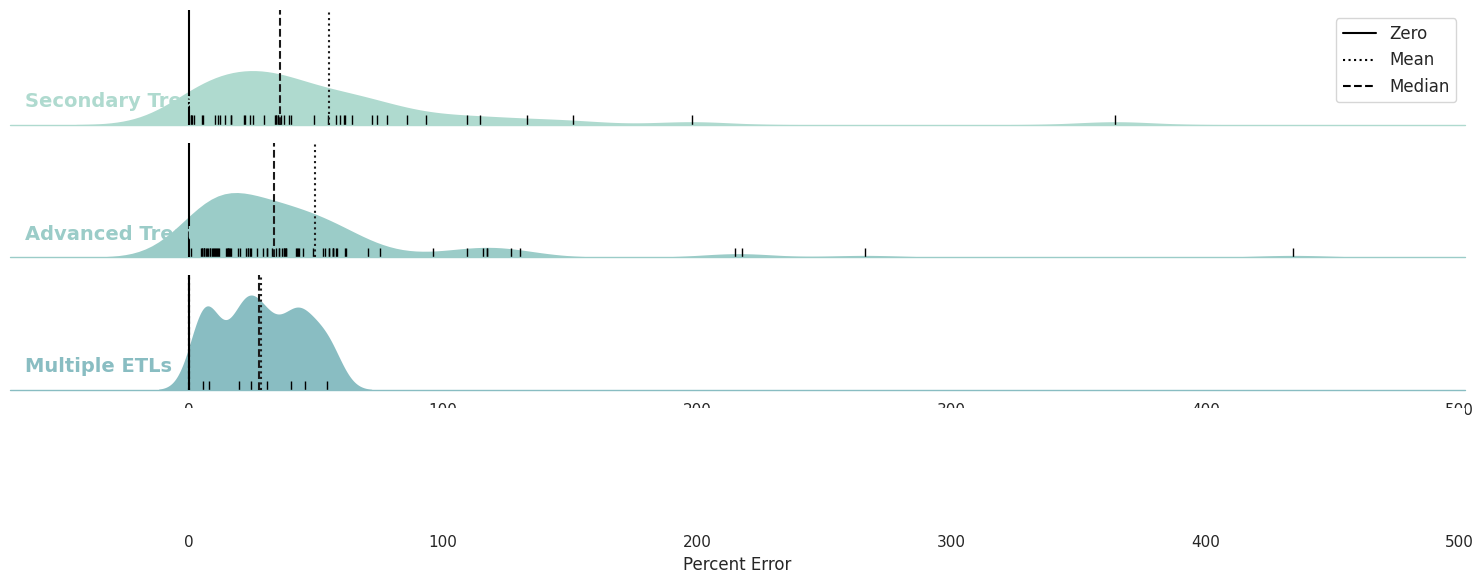

<Figure size 3840x2880 with 0 Axes>

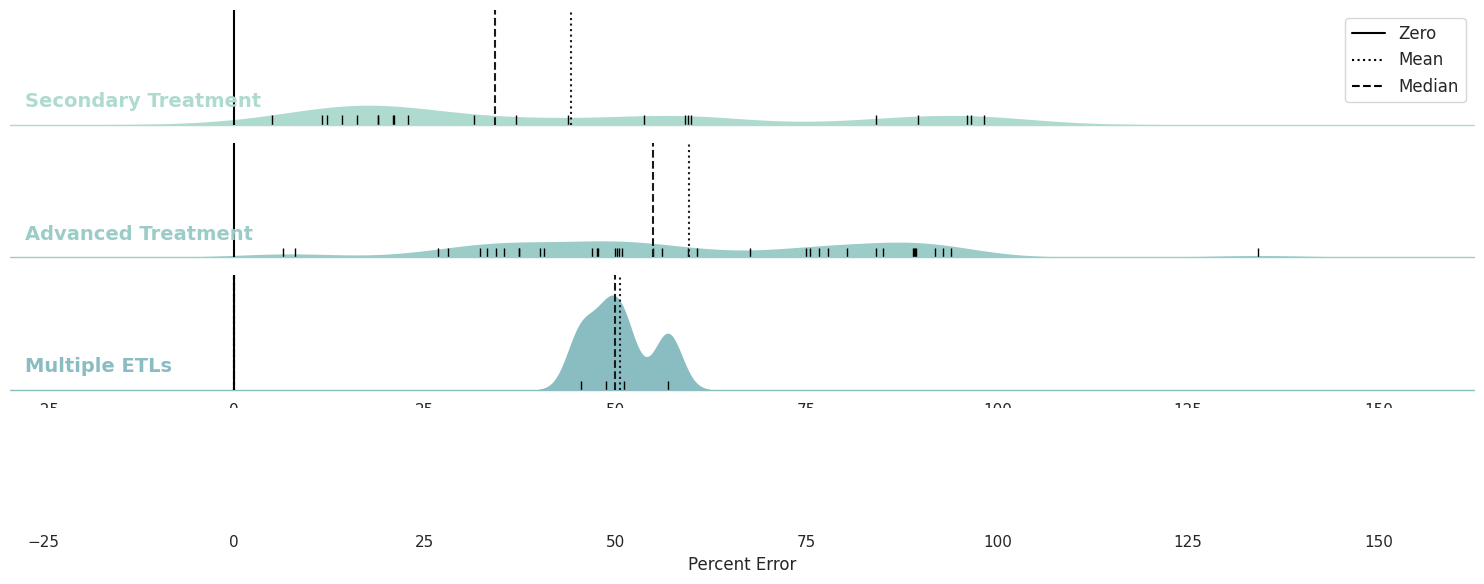

<Figure size 3840x2880 with 0 Axes>

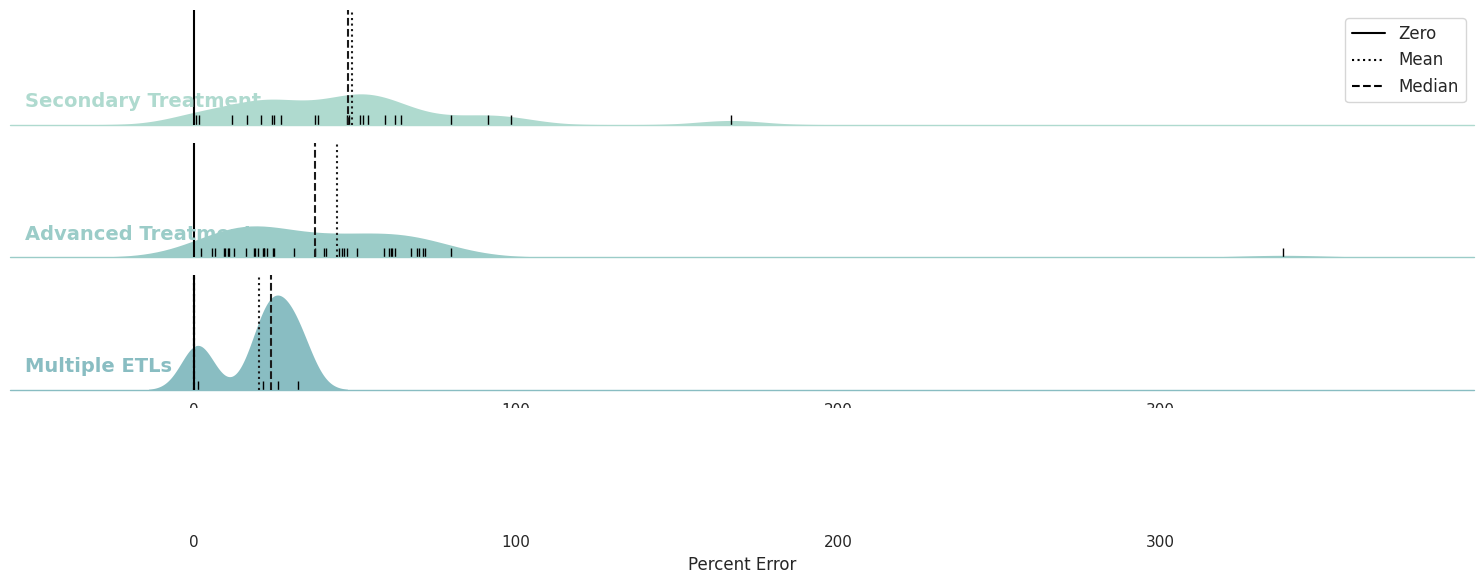

<Figure size 3840x2880 with 0 Axes>

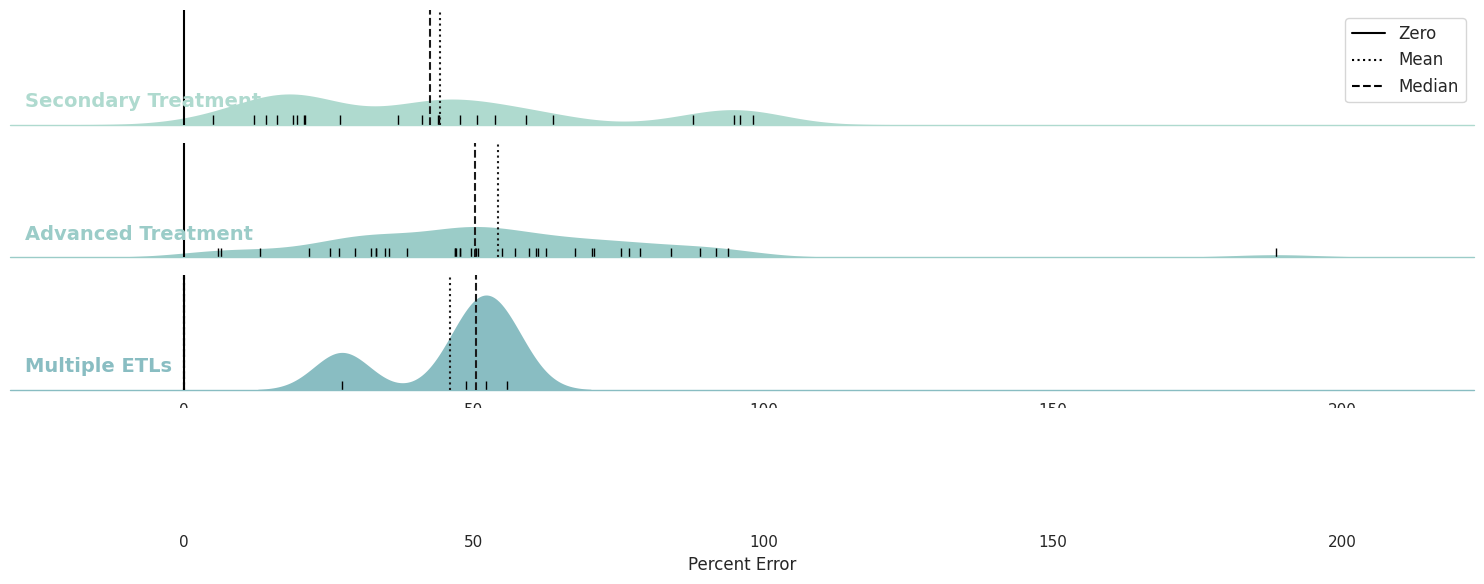

<Figure size 3840x2880 with 0 Axes>

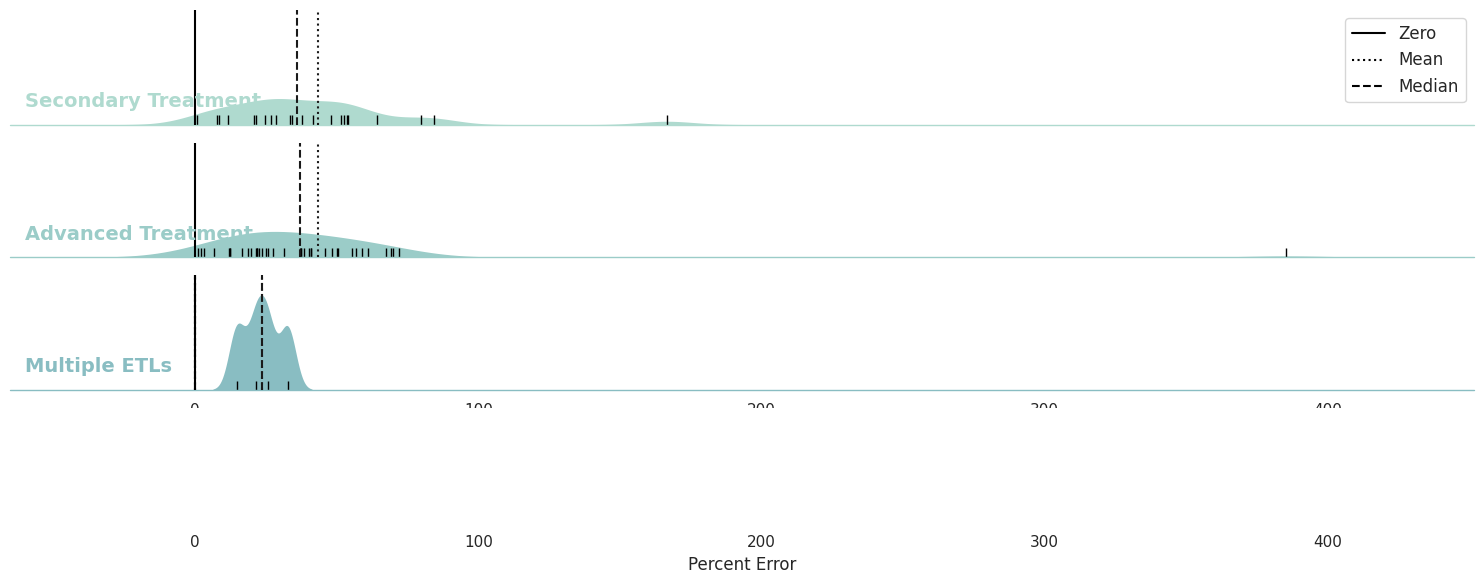

<Figure size 3840x2880 with 0 Axes>

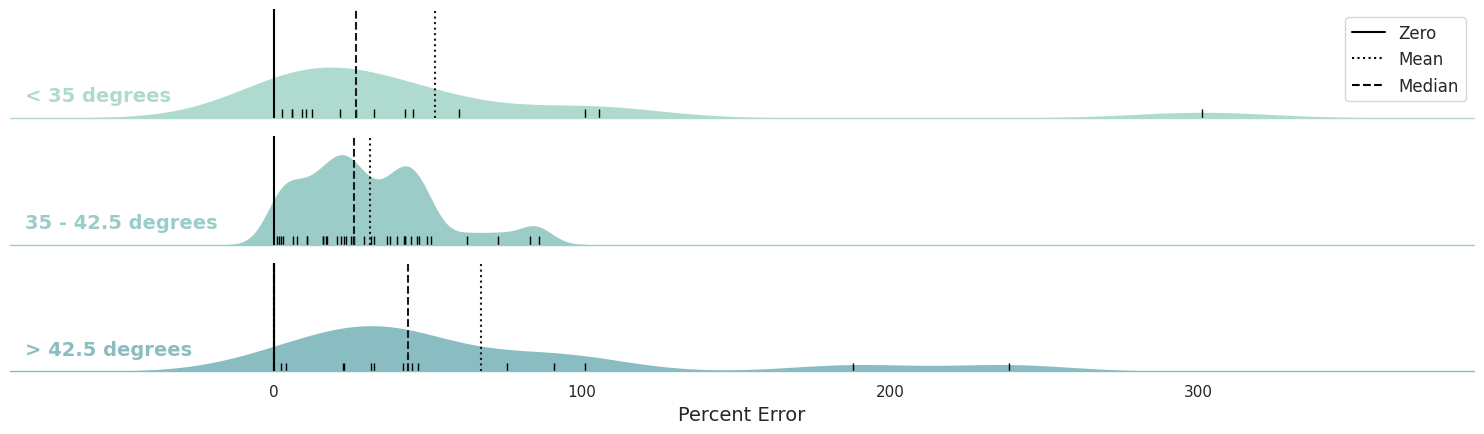

<Figure size 3840x2880 with 0 Axes>

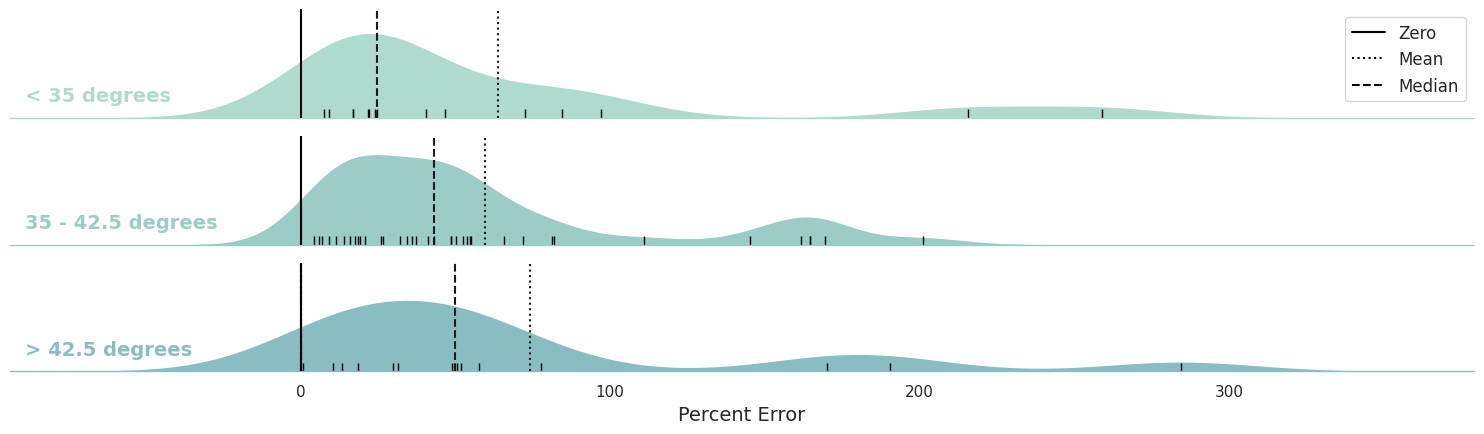

<Figure size 3840x2880 with 0 Axes>

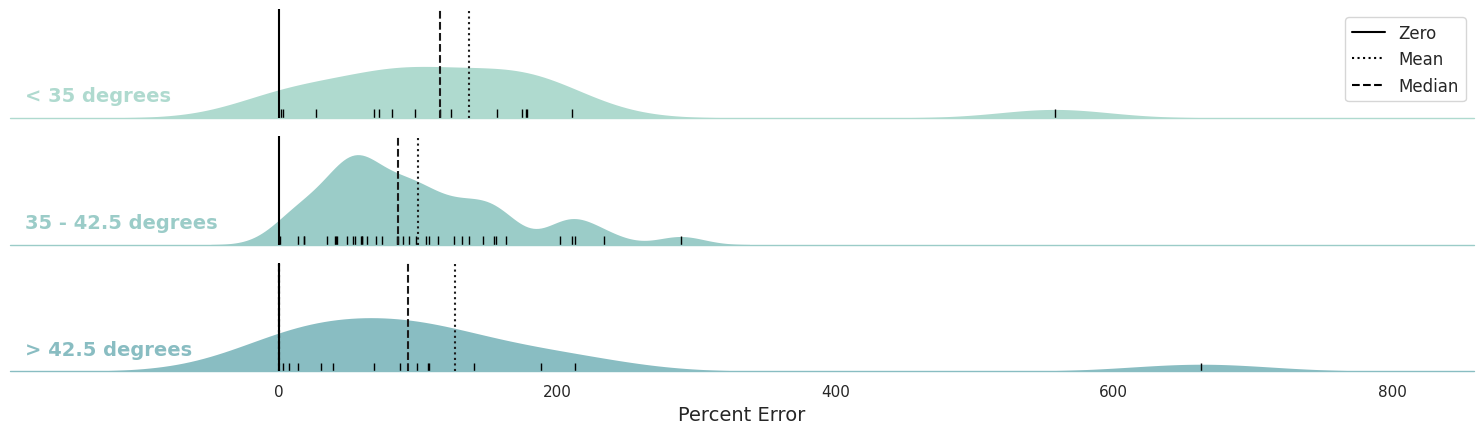

<Figure size 3840x2880 with 0 Axes>

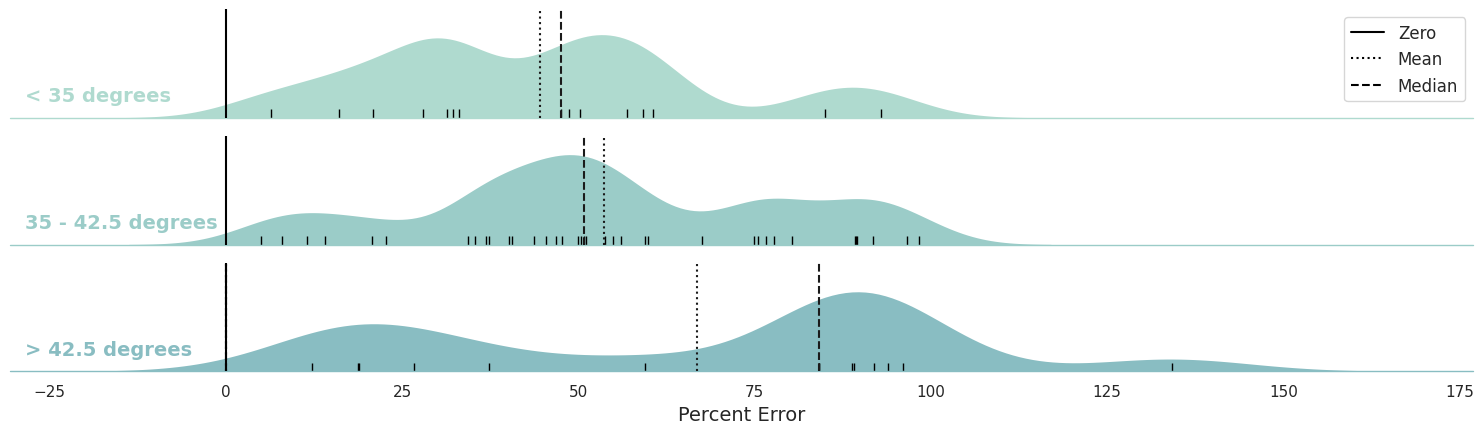

<Figure size 3840x2880 with 0 Axes>

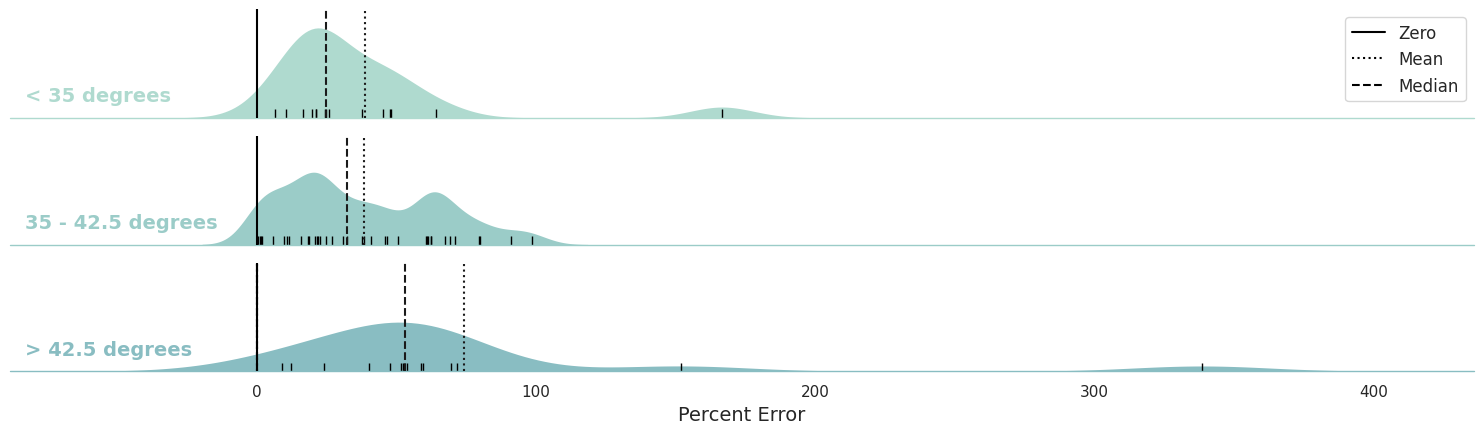

<Figure size 3840x2880 with 0 Axes>

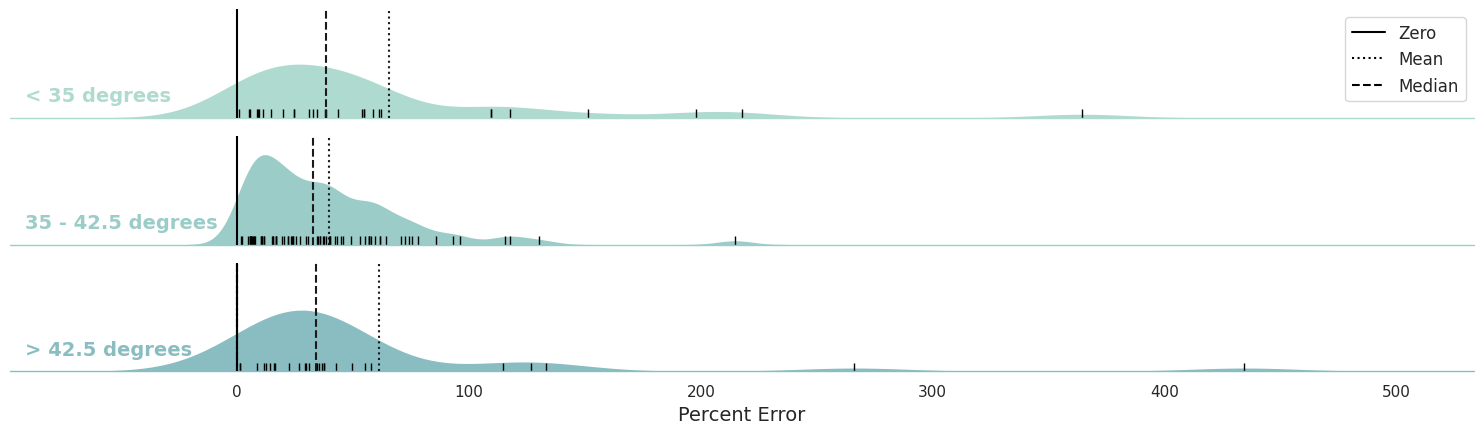

<Figure size 3840x2880 with 0 Axes>

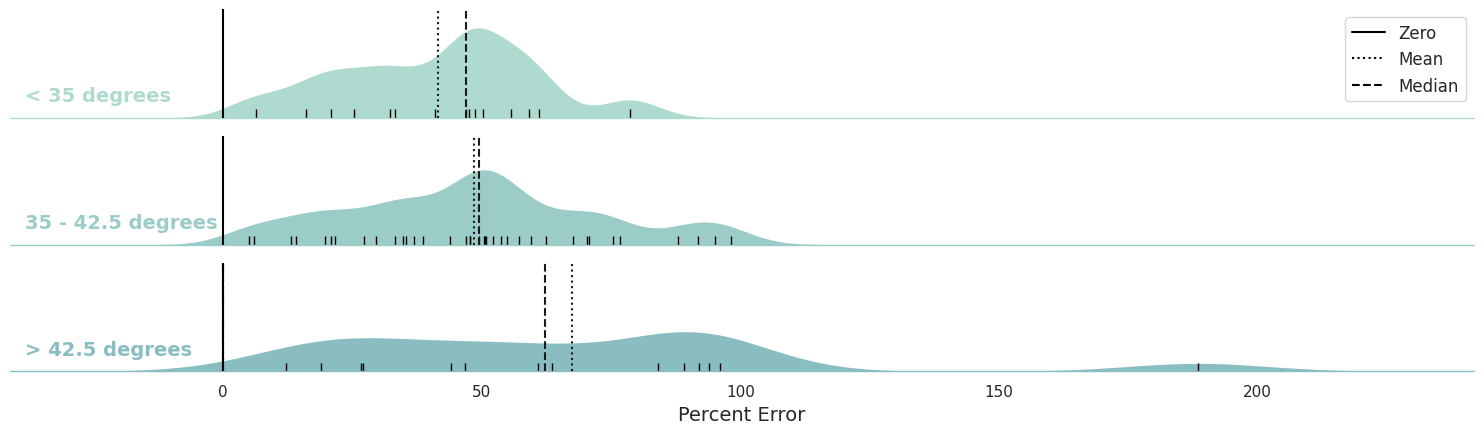

<Figure size 3840x2880 with 0 Axes>

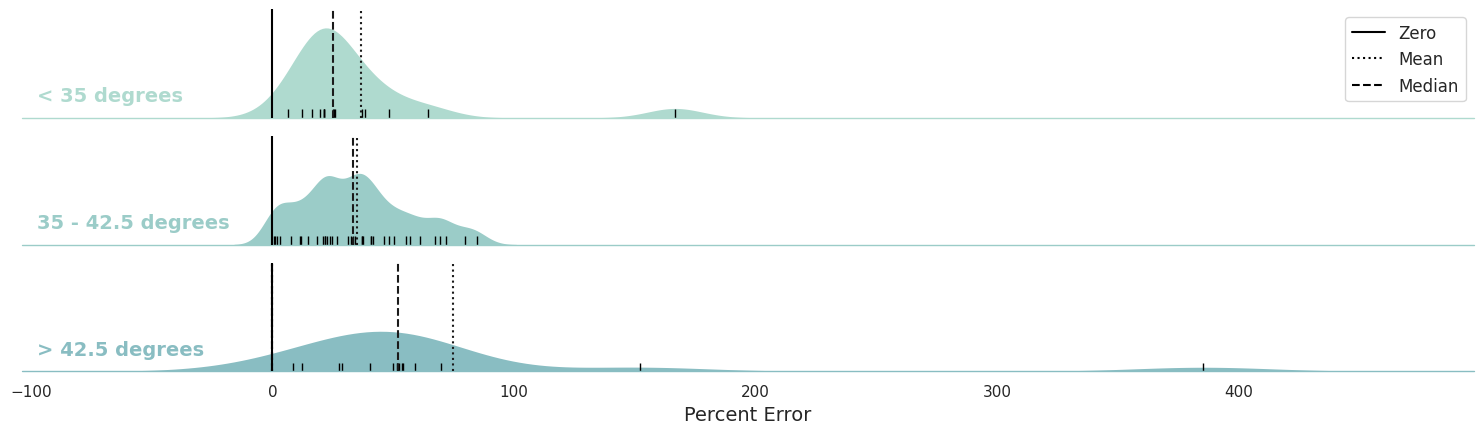

<Figure size 3840x2880 with 0 Axes>

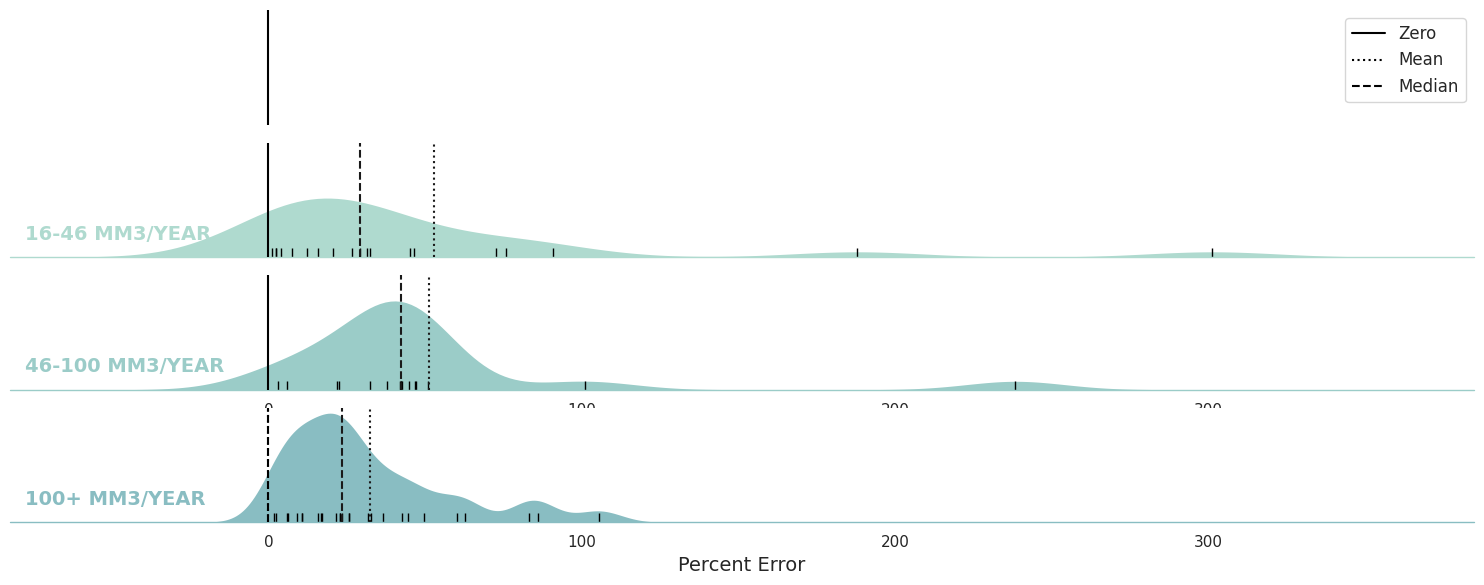

<Figure size 3840x2880 with 0 Axes>

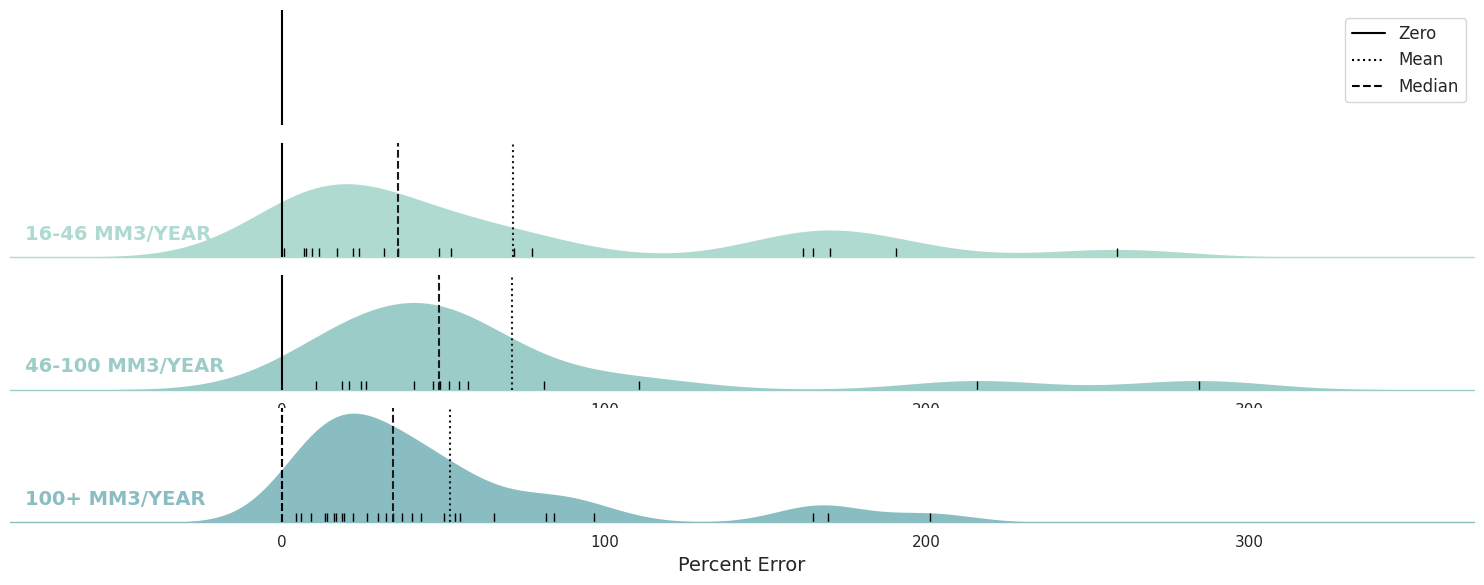

<Figure size 3840x2880 with 0 Axes>

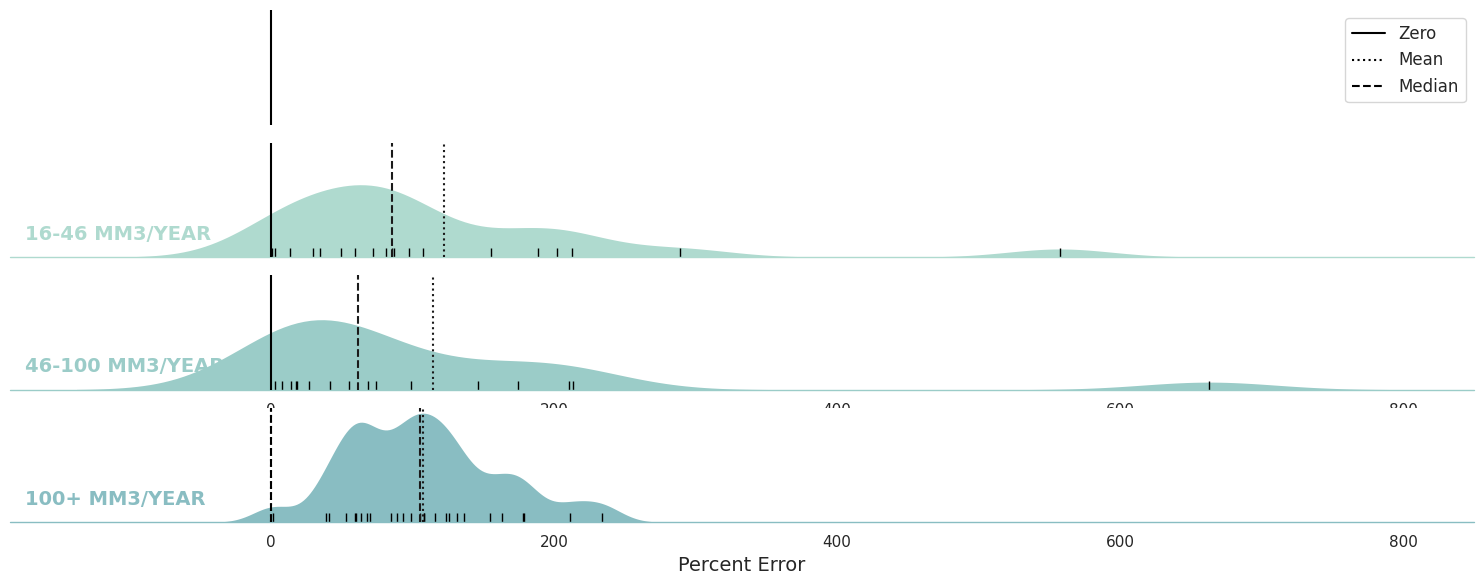

<Figure size 3840x2880 with 0 Axes>

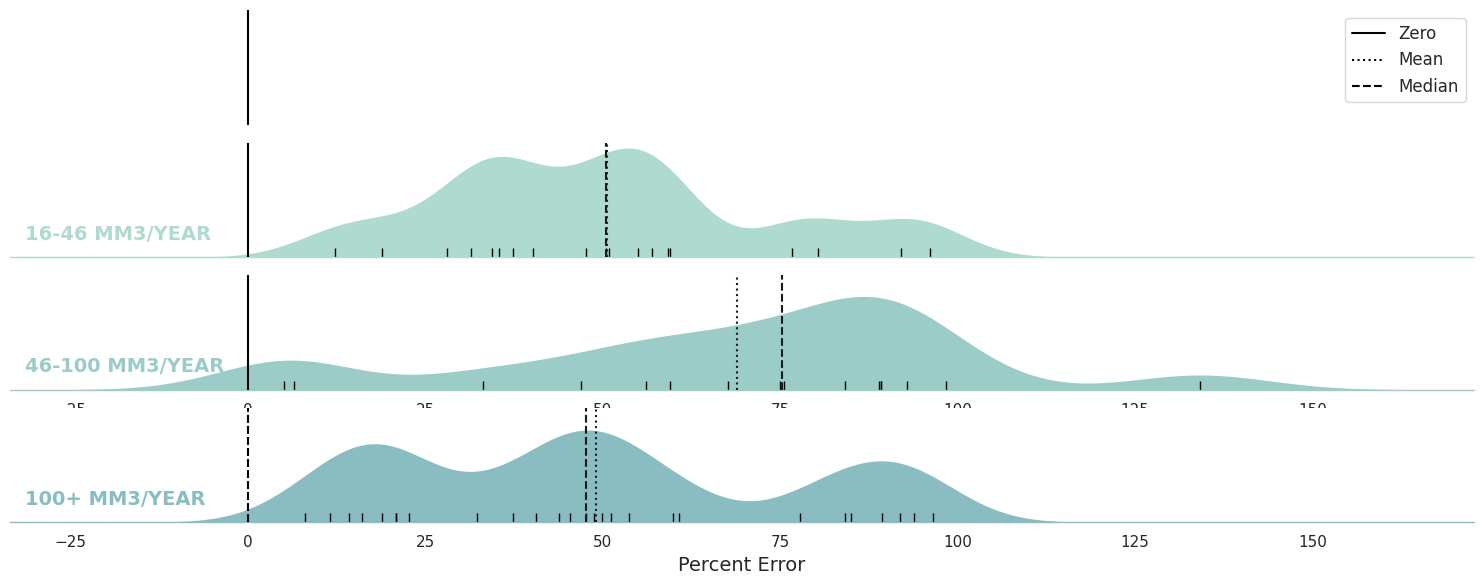

<Figure size 3840x2880 with 0 Axes>

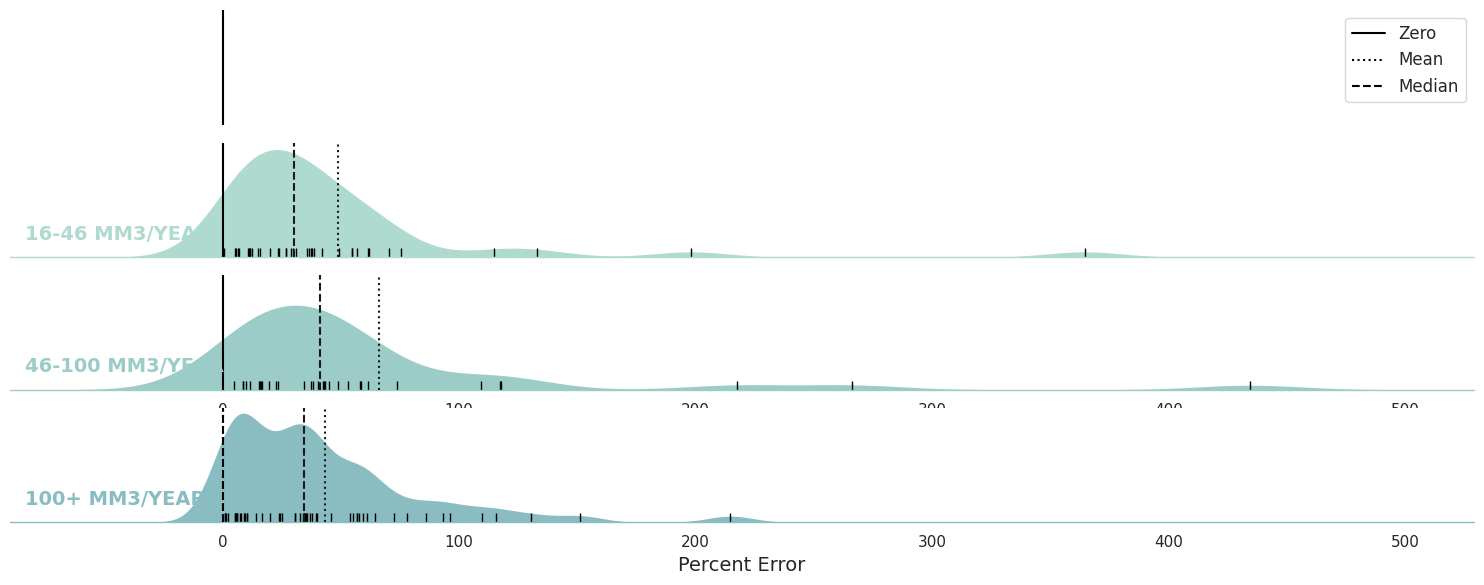

<Figure size 3840x2880 with 0 Axes>

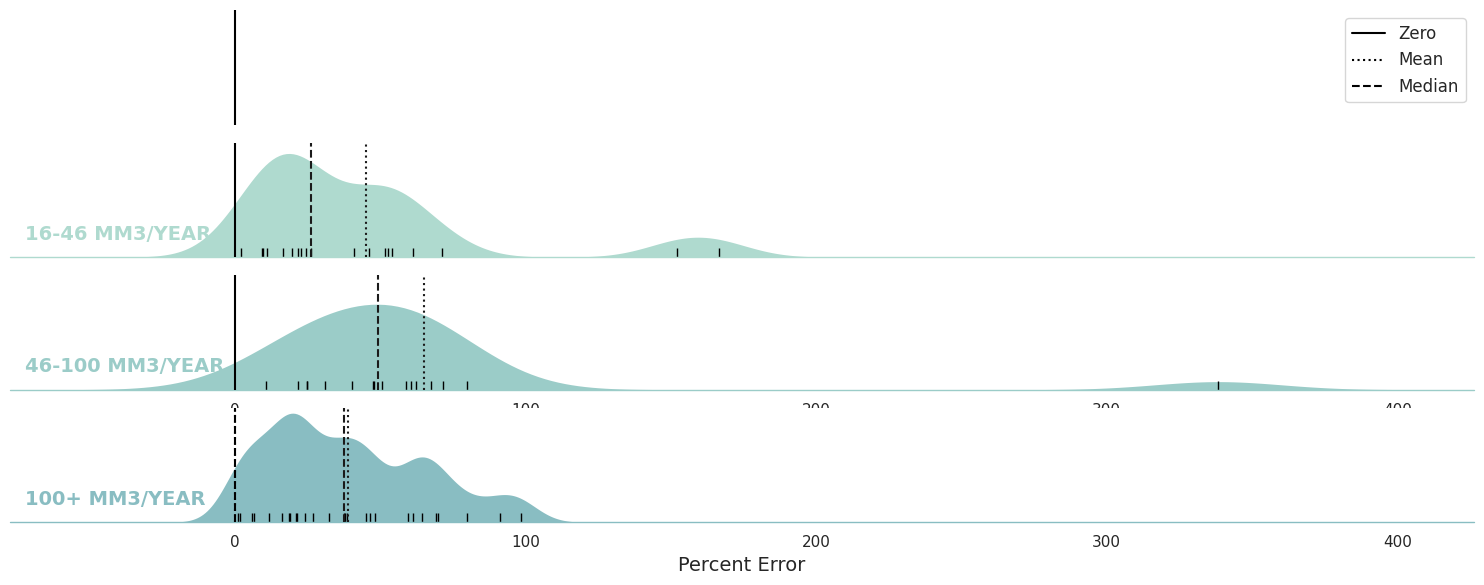

<Figure size 3840x2880 with 0 Axes>

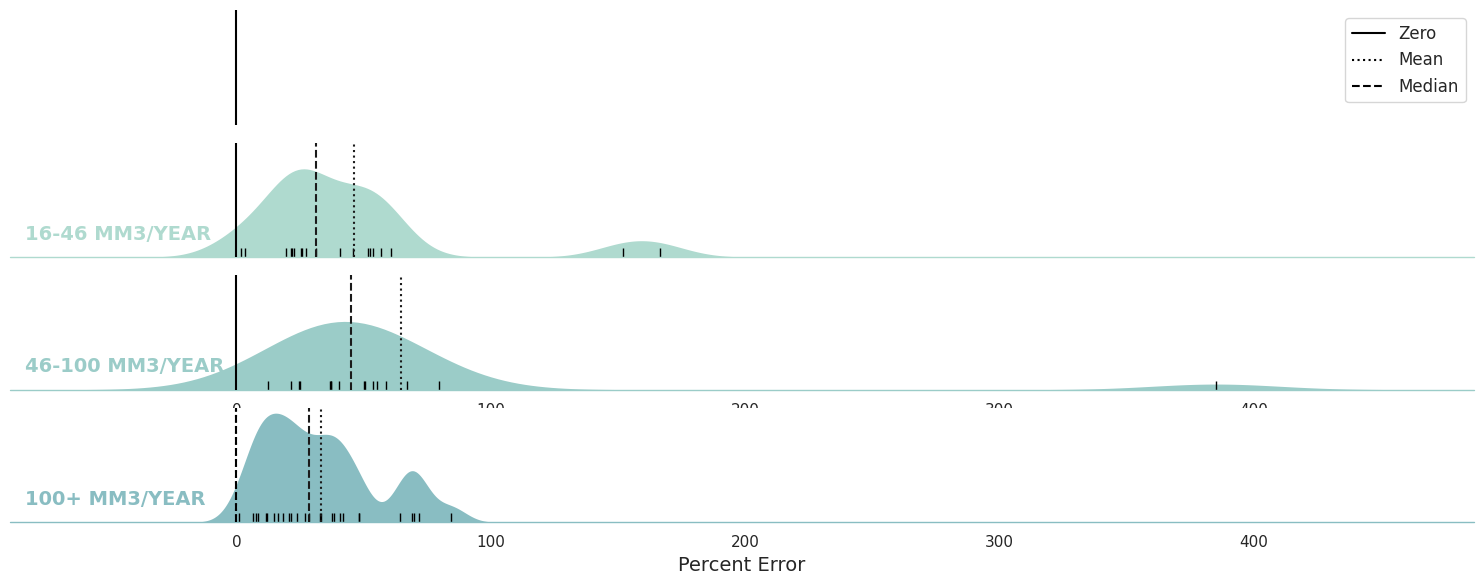

<Figure size 3840x2880 with 0 Axes>

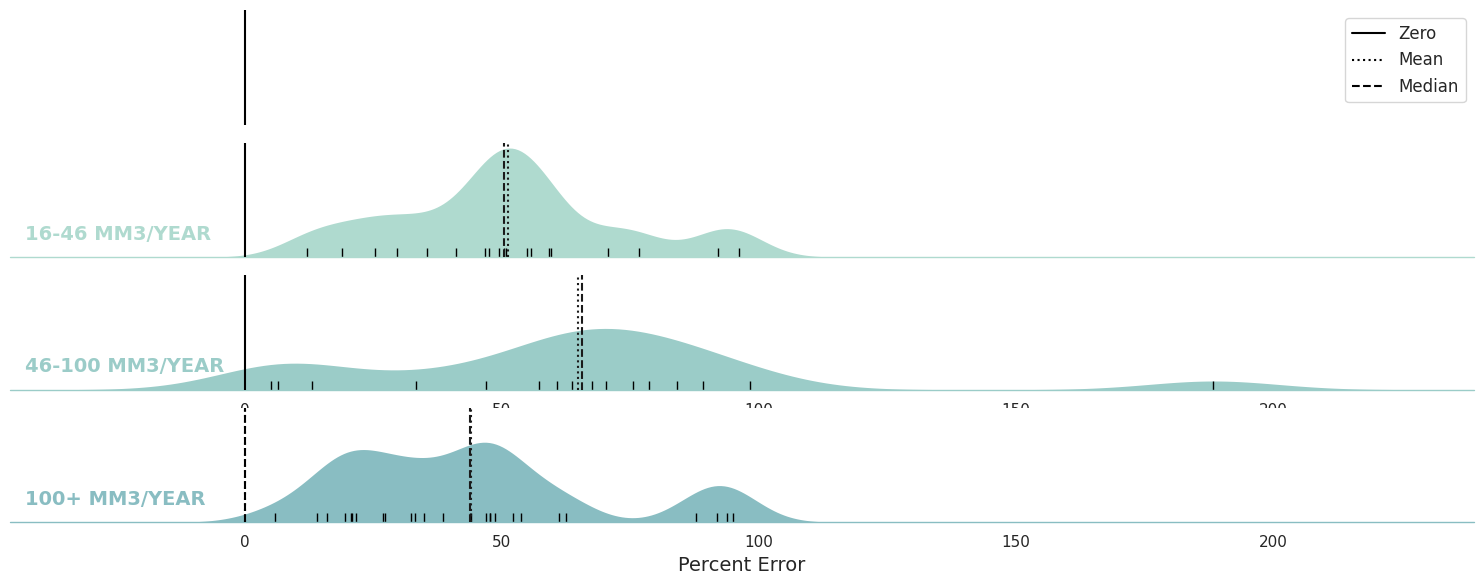

In [ ]:
#create ridgeline plots to compare accuracy of electricity consumption estimation methods by different plant characteristics ('ETL Classification','Latitude Classification','Flow Classification')
for hue_selec in ['ETL Classification','Latitude Classification','Flow Classification']:

  #based on current plant characteristic, specify order to plot different categories
  if hue_selec == 'ETL Classification':
    order_selec = ['Secondary Treatment', 'Advanced Treatment', 'Multiple ETLs']
  elif hue_selec == 'Latitude Classification':
    order_selec = ['< 35 degrees','35 - 42.5 degrees','> 42.5 degrees']
  else:
    order_selec = ['16-46 MM3/YEAR','46-100 MM3/YEAR','100+ MM3/YEAR']

  #create dataframe to plot error based on plant characteristics
  df = kde_plt[['City_name','ETL Classification','Latitude Classification','Flow Classification']].merge(error_plt_elec[['City_name','FLOW % Error (EI)','EFFLUENT_A % Error (EI)','EFFLUENT_B % Error (EI)','CONFIGURATION_A_T % Error (EI)','CONFIGURATION_A_BP % Error (EI)','CONFIGURATION_B_T % Error (EI)','CONFIGURATION_B_BP % Error (EI)','PROCESS_A % Error (EI)','PROCESS_B % Error (EI)']], how = 'left', on = 'City_name')
  df['M1'] = 'Flow'
  df['M2a'] = 'Effluent A'
  df['M2b'] = 'Effluent A'
  df['M3a'] = 'Configuration A (T)'
  df['M3b'] = 'Configuration A (BP)'
  df['M4a'] = 'Configuration B (T)'
  df['M4b'] = 'Configuration B (BP)'
  df['M5'] = 'Process A'
  df['M6'] = 'Process B'
  M1 = df[['M1','FLOW % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M1':'Method','FLOW % Error (EI)':'Percent Error'})
  M2a = df[['M2a','EFFLUENT_A % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M2a':'Method','EFFLUENT_A % Error (EI)':'Percent Error'})
  M2b = df[['M2b','EFFLUENT_B % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M2b':'Method','EFFLUENT_B % Error (EI)':'Percent Error'})
  M3a = df[['M3a','CONFIGURATION_A_T % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M3a':'Method','CONFIGURATION_A_T % Error (EI)':'Percent Error'})
  M3b = df[['M3b','CONFIGURATION_A_BP % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M3b':'Method','CONFIGURATION_A_BP % Error (EI)':'Percent Error'})
  M4a = df[['M4a','CONFIGURATION_B_T % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M4a':'Method','CONFIGURATION_B_T % Error (EI)':'Percent Error'})
  M4b = df[['M4b','CONFIGURATION_B_BP % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M4b':'Method','CONFIGURATION_B_BP % Error (EI)':'Percent Error'})
  M5 = df[['M5','PROCESS_A % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M5':'Method','PROCESS_A % Error (EI)':'Percent Error'})
  M6 = df[['M6','PROCESS_B % Error (EI)','ETL Classification','Latitude Classification','Flow Classification']].rename(columns={'M6':'Method','PROCESS_B % Error (EI)':'Percent Error'})
  cat_plt = pd.concat([M1,M2a,M2b,M3a,M3b,M4a,M4b,M5,M6])

  #sort dataframe so that categories plot in correct order
  cat_plt['Order'] = np.nan
  if hue_selec == 'ETL Classification':
    cat_plt.loc[cat_plt['ETL Classification'] == 'Secondary Treatment', 'Order'] = 1
    cat_plt.loc[cat_plt['ETL Classification'] == 'Advanced Treatment', 'Order'] = 2
    cat_plt.loc[cat_plt['ETL Classification'] == 'Multiple ETLs', 'Order'] = 3
  elif hue_selec == 'Latitude Classification':
    cat_plt.loc[cat_plt['Latitude Classification'] == '< 35 degrees', 'Order'] = 1
    cat_plt.loc[cat_plt['Latitude Classification'] == '35 - 42.5 degrees', 'Order'] = 2
    cat_plt.loc[cat_plt['Latitude Classification'] == '> 42.5 degrees', 'Order'] = 3
  elif hue_selec == 'Flow Classification':
    cat_plt.loc[cat_plt['Flow Classification'] == '0-16 MM3/YEAR', 'Order'] = 1
    cat_plt.loc[cat_plt['Flow Classification'] == '16-46 MM3/YEAR', 'Order'] = 2
    cat_plt.loc[cat_plt['Flow Classification'] == '46-100 MM3/YEAR', 'Order'] = 3
    cat_plt.loc[cat_plt['Flow Classification'] == '100+ MM3/YEAR', 'Order'] = 4
  cat_plt.sort_values(by = 'Order', inplace = True)

  #for each electricity consumption estimation method, create plot of how error varies based on hue_selec
  for method in cat_plt.Method.unique():

    #filter to current method
    cat_plt_sub = cat_plt.loc[cat_plt['Method'] == method]

    #based on percent error, create ridgeline plots for each electricity consumption estimation method
    plt.figure(dpi = 600)

    #initialize the FacetGrid object
    g = sns.FacetGrid(cat_plt_sub, row = hue_selec, hue = hue_selec, hue_order = order_selec, aspect = 10, height = 1.5, palette = pal)

    #draw the KDEs and rugplots
    g.map(sns.kdeplot, 'Percent Error', bw_adjust = .5, clip_on = True, fill = True, alpha = 1, linewidth = 0)
    g.map(sns.rugplot, 'Percent Error', color = 'black', height = 0.08, lw = .1)
    g.map(sns.kdeplot, 'Percent Error', clip_on = False, color = 'w', lw = 0, bw_adjust = .5)
    g.refline(y = 0, linewidth = 1, linestyle = "-", color = None, clip_on = False)

    #set the subplots to not overlap
    g.figure.subplots_adjust(hspace = 0.25)

    #remove y-axis and tick marks
    g.despine(bottom = True, left = True)
    g.set(yticks=[])

    #label each subplot with corresponding method
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0.01, .2, label, fontweight = 'bold', color = color,
                ha = 'left', va = 'center', transform = ax.transAxes, fontsize = 14)
        g.set(ylabel = "")
        g.set_titles("")

    g.map(label, 'Percent Error')

    #add dashed and dotted mean and median lines to each subplot
    def mean_med_lines(x, **kwargs):
        plt.axvline(x.mean(), c = 'k', ls = ':', lw = 1.5)
        plt.axvline(x.median(), c = 'k', ls = 'dashed', lw = 1.5)

    g.map(mean_med_lines,'Percent Error')

    #add vertical black line at % Error = 0
    zero = g.axes.flat[0].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
    g.axes.flat[1].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')
    g.axes.flat[2].axvline(x = 0, ymin = 0, ymax = 1, color = 'black')

    #format x-axis
    plt.setp(plt.gca().get_xticklabels(), fontsize = 10)
    plt.xlabel('Percent Error', fontsize = 14)
    g.axes.flat[0].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    g.axes.flat[1].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
    g.axes.flat[2].tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = True)

    #recenter plot after removing y-axis
    plt.gca().spines['bottom'].set_position('zero')

    #add legend and y-axis label
    g.axes.flat[0].legend([zero, plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = ':'),plt.axvline(x = 0, ymin = 0, ymax = 1, color = 'black', linestyle = 'dashed')], ['Zero', 'Mean', 'Median'], fontsize = 12)

In [ ]:
#calculate percent of reported energy use for each method
error_plt_energy['Configuration A (T)'] = error_plt_energy['TOT_2012_CONFIGURATION_A_T_MJ/M3']/error_plt_energy['2012_CHINI_EI_MJ/M3'] * 100
error_plt_energy['Configuration A (BP)'] = error_plt_energy['TOT_2012_CONFIGURATION_A_BP_MJ/M3']/error_plt_energy['2012_CHINI_EI_MJ/M3'] * 100
error_plt_energy['Configuration B (T)'] = error_plt_energy['TOT_2012_CONFIGURATION_B_T_MJ/M3']/error_plt_energy['2012_CHINI_EI_MJ/M3'] * 100
error_plt_energy['Configuration B (BP)'] = error_plt_energy['TOT_2012_CONFIGURATION_B_BP_MJ/M3']/error_plt_energy['2012_CHINI_EI_MJ/M3'] * 100
error_plt_energy['Regression'] = error_plt_energy['TOT_2012_REGRESSION_MJ/M3']/error_plt_energy['2012_CHINI_EI_MJ/M3'] * 100

#create separate dataframe for percent of reported energy use by plant characteristics like size, location, and ETL
kde_plt = error_plt_energy[['City_name','CWNS_TOT_2012_FLOW_MM3','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Regression']]
kde_plt['Effluent Treatment Level(s)'] = np.nan
kde_plt['Effluent Treatment Level(s)'] = kde_plt['Effluent Treatment Level(s)'].astype('object')

#classify flow, ETL, and latitude for each city
for index, row in kde_plt.iterrows():
  city = row['City_name']
  flow = row['CWNS_TOT_2012_FLOW_MM3']
  cwns = select_cities.loc[select_cities['City_name'] == city, 'CWNS_NUM'].to_list()

  #categorize flow
  if flow < 16:
    kde_plt.at[index, 'Flow Classification'] = '0-16 MM3/YEAR'
  elif (flow >= 16) & (flow < 46):
    kde_plt.at[index, 'Flow Classification'] = '16-46 MM3/YEAR'
  elif (flow >= 46) & (flow < 100):
    kde_plt.at[index, 'Flow Classification'] = '46-100 MM3/YEAR'
  elif flow >= 100:
    kde_plt.at[index, 'Flow Classification'] = '100+ MM3/YEAR'

  #categorize ETL
  etls = wwtps_2012.loc[wwtps_2012['CWNS_NUM'].isin(cwns)]['2012_EFFLUENT_TREATMENT_LEVEL'].to_list()
  kde_plt.at[index, 'Effluent Treatment Level(s)'] = sorted(etls)
  if all([i == etls[0] for i in etls]):
    kde_plt.at[index, 'ETL Classification'] = etls[0]
  else:
    kde_plt.at[index, 'ETL Classification'] = 'Mix'

  #categorize latitude
  lat = wwtps_2012.loc[wwtps_2012['CWNS_NUM'] == cwns[0], 'LATITUDE'].values[0]
  kde_plt.at[index, 'Latitude'] = lat
  if lat <= 35:
    kde_plt.at[index, 'Latitude Classification'] = '< 35 degrees'
  elif (lat > 35) & (lat <= 42.5):
    kde_plt.at[index, 'Latitude Classification'] = '35 - 42.5 degrees'
  elif lat > 42.5:
    kde_plt.at[index, 'Latitude Classification'] = '> 42.5 degrees'

kde_plt['# Cities'] = 1

#correct naming convention of ETLs
kde_plt.loc[kde_plt['ETL Classification'] == 'Secondary', 'ETL Classification'] = 'Secondary'
kde_plt.loc[kde_plt['ETL Classification'] == 'Primary (45mg/l< BOD)', 'ETL Classification'] = 'Primary'

#create table to show how average percent of reported energy use differs by flow
flow_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','Flow Classification','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Regression']].groupby(['Flow Classification']).sum()
flow_class['Configuration A (T)'] = flow_class['Configuration A (T)']/flow_class['# Cities']
flow_class['Configuration A (BP)'] = flow_class['Configuration A (BP)']/flow_class['# Cities']
flow_class['Configuration B (T)'] = flow_class['Configuration B (T)']/flow_class['# Cities']
flow_class['Configuration B (BP)'] = flow_class['Configuration B (BP)']/flow_class['# Cities']
flow_class['Regression'] = flow_class['Regression']/flow_class['# Cities']

#create table to show how average percent of reported energy use differs by ETL
etl_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','ETL Classification','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Regression']].groupby(['ETL Classification']).sum()
etl_class['Configuration A (T)'] = etl_class['Configuration A (T)']/etl_class['# Cities']
etl_class['Configuration A (BP)'] = etl_class['Configuration A (BP)']/etl_class['# Cities']
etl_class['Configuration B (T)'] = etl_class['Configuration B (T)']/etl_class['# Cities']
etl_class['Configuration B (BP)'] = etl_class['Configuration B (BP)']/etl_class['# Cities']
etl_class['Regression'] = etl_class['Regression']/etl_class['# Cities']

#create table to show how average percent of reported energy use differs by latitude
lat_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','Latitude Classification','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Regression']].groupby(['Latitude Classification']).sum()
lat_class['Configuration A (T)'] = lat_class['Configuration A (T)']/lat_class['# Cities']
lat_class['Configuration A (BP)'] = lat_class['Configuration A (BP)']/lat_class['# Cities']
lat_class['Configuration B (T)'] = lat_class['Configuration B (T)']/lat_class['# Cities']
lat_class['Configuration B (BP)'] = lat_class['Configuration B (BP)']/lat_class['# Cities']
lat_class['Regression'] = lat_class['Regression']/lat_class['# Cities']

#combine into one dataframe with percent of total energy use by plant characteristics
energy_class = pd.concat([flow_class,etl_class,lat_class])

#reorder categories
energy_class = energy_class.reindex(['16-46 MM3/YEAR','46-100 MM3/YEAR','100+ MM3/YEAR','Primary','Secondary','Advanced Treatment','Mix','< 35 degrees','35 - 42.5 degrees','> 42.5 degrees'], level = 0)

#export dataframe
energy_class.to_csv(path + 'results/table_S14.csv')

/tmp/ipython-input-46-3016444756.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['Effluent Treatment Level(s)'] = np.nan
/tmp/ipython-input-46-3016444756.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['Effluent Treatment Level(s)'] = kde_plt['Effluent Treatment Level(s)'].astype('object')
/tmp/ipython-input-46-3016444756.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:
#calculate percent of reported electricity generation for each method
error_plt_gen['Configuration A (T)'] = error_plt_gen['TOT_2012_CONFIGURATION_A_T_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100
error_plt_gen['Configuration A (BP)'] = error_plt_gen['TOT_2012_CONFIGURATION_A_BP_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100
error_plt_gen['Configuration B (T)'] = error_plt_gen['TOT_2012_CONFIGURATION_B_T_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100
error_plt_gen['Configuration B (BP)'] = error_plt_gen['TOT_2012_CONFIGURATION_B_BP_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100
error_plt_gen['Biogas A'] = error_plt_gen['TOT_2012_BIOGAS_A_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100
error_plt_gen['Biogas B'] = error_plt_gen['TOT_2012_BIOGAS_B_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100
error_plt_gen['Biogas C'] = error_plt_gen['TOT_2012_BIOGAS_C_MWH/M3']/error_plt_gen['2012_CHINI_EI_MWH/M3'] * 100

#create separate dataframe for percent of reported electricity generation by plant characteristics like size, location, and ETL
kde_plt = error_plt_gen[['City_name','CWNS_TOT_2012_FLOW_MM3','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Biogas A','Biogas B','Biogas C']]
kde_plt['Effluent Treatment Level(s)'] = np.nan
kde_plt['Effluent Treatment Level(s)'] = kde_plt['Effluent Treatment Level(s)'].astype('object')

#classify flow, ETL, and latitude for each city
for index, row in kde_plt.iterrows():
  city = row['City_name']
  flow = row['CWNS_TOT_2012_FLOW_MM3']
  cwns = select_cities.loc[select_cities['City_name'] == city, 'CWNS_NUM'].to_list()

  #categorize flow
  if flow < 16:
    kde_plt.at[index, 'Flow Classification'] = '0-16 MM3/YEAR'
  elif (flow >= 16) & (flow < 46):
    kde_plt.at[index, 'Flow Classification'] = '16-46 MM3/YEAR'
  elif (flow >= 46) & (flow < 100):
    kde_plt.at[index, 'Flow Classification'] = '46-100 MM3/YEAR'
  elif flow >= 100:
    kde_plt.at[index, 'Flow Classification'] = '100+ MM3/YEAR'

  #categorize ETL
  etls = wwtps_2012.loc[wwtps_2012['CWNS_NUM'].isin(cwns)]['2012_EFFLUENT_TREATMENT_LEVEL'].to_list()
  kde_plt.at[index, 'Effluent Treatment Level(s)'] = sorted(etls)
  if all([i == etls[0] for i in etls]):
    kde_plt.at[index, 'ETL Classification'] = etls[0]
  else:
    kde_plt.at[index, 'ETL Classification'] = 'Mix'

  #categorize latitude
  lat = wwtps_2012.loc[wwtps_2012['CWNS_NUM'] == cwns[0], 'LATITUDE'].values[0]
  kde_plt.at[index, 'Latitude'] = lat
  if lat <= 35:
    kde_plt.at[index, 'Latitude Classification'] = '< 35 degrees'
  elif (lat > 35) & (lat <= 42.5):
    kde_plt.at[index, 'Latitude Classification'] = '35 - 42.5 degrees'
  elif lat > 42.5:
    kde_plt.at[index, 'Latitude Classification'] = '> 42.5 degrees'

kde_plt['# Cities'] = 1

#correct naming of ETLs
kde_plt.loc[kde_plt['ETL Classification'] == 'Secondary', 'ETL Classification'] = 'Secondary'
kde_plt.loc[kde_plt['ETL Classification'] == 'Primary (45mg/l< BOD)', 'ETL Classification'] = 'Primary'

#create table to show how average percent of reported electricity generation differs by flow
flow_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','Flow Classification','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Biogas A','Biogas B','Biogas C']].groupby(['Flow Classification']).sum()
flow_class['Configuration A (T)'] = flow_class['Configuration A (T)']/flow_class['# Cities']
flow_class['Configuration A (BP)'] = flow_class['Configuration A (BP)']/flow_class['# Cities']
flow_class['Configuration B (T)'] = flow_class['Configuration B (T)']/flow_class['# Cities']
flow_class['Configuration B (BP)'] = flow_class['Configuration B (BP)']/flow_class['# Cities']
flow_class['Biogas A'] = flow_class['Biogas A']/flow_class['# Cities']
flow_class['Biogas B'] = flow_class['Biogas B']/flow_class['# Cities']
flow_class['Biogas C'] = flow_class['Biogas C']/flow_class['# Cities']

#create table to show how average percent of reported electricity generation differs by ETL
etl_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','ETL Classification','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Biogas A','Biogas B','Biogas C']].groupby(['ETL Classification']).sum()
etl_class['Configuration A (T)'] = etl_class['Configuration A (T)']/etl_class['# Cities']
etl_class['Configuration A (BP)'] = etl_class['Configuration A (BP)']/etl_class['# Cities']
etl_class['Configuration B (T)'] = etl_class['Configuration B (T)']/etl_class['# Cities']
etl_class['Configuration B (BP)'] = etl_class['Configuration B (BP)']/etl_class['# Cities']
etl_class['Biogas A'] = etl_class['Biogas A']/etl_class['# Cities']
etl_class['Biogas B'] = etl_class['Biogas B']/etl_class['# Cities']
etl_class['Biogas C'] = etl_class['Biogas C']/etl_class['# Cities']

#create table to show how average percent of reported electricity generation differs by latitude
lat_class = kde_plt[['# Cities','CWNS_TOT_2012_FLOW_MM3','Latitude Classification','Configuration A (T)','Configuration A (BP)','Configuration B (T)','Configuration B (BP)','Biogas A','Biogas B','Biogas C']].groupby(['Latitude Classification']).sum()
lat_class['Configuration A (T)'] = lat_class['Configuration A (T)']/lat_class['# Cities']
lat_class['Configuration A (BP)'] = lat_class['Configuration A (BP)']/lat_class['# Cities']
lat_class['Configuration B (T)'] = lat_class['Configuration B (T)']/lat_class['# Cities']
lat_class['Configuration B (BP)'] = lat_class['Configuration B (BP)']/lat_class['# Cities']
lat_class['Biogas A'] = lat_class['Biogas A']/lat_class['# Cities']
lat_class['Biogas B'] = lat_class['Biogas B']/lat_class['# Cities']
etl_class['Biogas C'] = etl_class['Biogas C']/etl_class['# Cities']

#combine into one dataframe with percent of total electricity generation by plant characteristics
gen_class = pd.concat([flow_class,etl_class,lat_class])

#reorder categories
gen_class = gen_class.reindex(['16-46 MM3/YEAR','46-100 MM3/YEAR','100+ MM3/YEAR','Secondary','Advanced Treatment','< 35 degrees','35 - 42.5 degrees','> 42.5 degrees'], level = 0)

#export dataframe
gen_class.to_csv(path + 'results/table_S15.csv')

/tmp/ipython-input-47-2604669808.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['Effluent Treatment Level(s)'] = np.nan
/tmp/ipython-input-47-2604669808.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kde_plt['Effluent Treatment Level(s)'] = kde_plt['Effluent Treatment Level(s)'].astype('object')
/tmp/ipython-input-47-2604669808.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th